# Facebook Post Content Analysis

This notebook begins the content-level analysis of Facebook posts collected from various schools in Connecticut.

### Objectives:
1. **Clean and preprocess** the post text for NLP tasks.
2. Conduct **basic keyword and phrase analysis** to identify thematic content patterns.
3. Apply **topic modeling** (TF-IDF + NMF) to uncover latent themes in posts.
4. Perform **sentiment and emotion analysis** using TextBlob and VADER.
5. Explore **relationships between content features and engagement metrics** (comments, shares, reactions).

This work builds on the cleaned and merged dataset created during the exploratory analysis phase.

In [1]:
# Core
import pandas as pd
import numpy as np
import re
import string

# NLP preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Text vectorization + topic modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Sentiment & emotion
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer  # for VADER

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load cleaned Facebook posts
csv_path = "facebook_posts_cleaned.csv"
df = pd.read_csv(csv_path)

# Preview
df.head(2)

school_name                                          post_text  \
0  Cobb_Montessori  Our Primary campers had another amazing visit ...   
1  Cobb_Montessori  Cobb Alum Spotlight: Lizzy Strapp \nA proud Co...   

    timestamp  comments  reactions  shares    year  month   day    weekday  \
0  2025-06-26         0          5       0  2025.0    6.0  26.0   Thursday   
1  2025-06-25         6         20       0  2025.0    6.0  25.0  Wednesday   

   week  week_start month_start  
0    26  2025-06-23  2025-06-01  
1    26  2025-06-23  2025-06-01

In [3]:
# posts have hashtags. they can be meaningful. so we collect them in a new col
# but we also strip the # from the post and leave the word there for modeling.

# Extract hashtags (keep them as lowercase words)
df['hashtags'] = df['post_text'].str.findall(r'#\w+')

# Remove the '#' but keep the word (e.g., #GraduationDay → GraduationDay)
df['text_clean'] = df['post_text'].str.replace(r'#', '', regex=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   school_name  435 non-null    object 
 1   post_text    435 non-null    object 
 2   timestamp    435 non-null    object 
 3   comments     435 non-null    int64  
 4   reactions    435 non-null    int64  
 5   shares       435 non-null    int64  
 6   year         435 non-null    float64
 7   month        435 non-null    float64
 8   day          435 non-null    float64
 9   weekday      435 non-null    object 
 10  week         435 non-null    int64  
 11  week_start   435 non-null    object 
 12  month_start  435 non-null    object 
 13  hashtags     435 non-null    object 
 14  text_clean   435 non-null    object 
dtypes: float64(3), int64(4), object(8)
memory usage: 51.1+ KB


In [5]:
(df['hashtags'].apply(len) > 0).sum()

192

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation and digits
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and short words, lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    
    return tokens

# Apply cleaning
df['text_tokens'] = df['text_clean'].apply(clean_text)

# Preview
df[['post_text', 'text_tokens']].head()

post_text  \
0  Our Primary campers had another amazing visit ...   
1  Cobb Alum Spotlight: Lizzy Strapp \nA proud Co...   
2  Cobb Alum Spotlight: Jamison Burnett \nCongrat...   
3  A few Cobb families gathered for a special aft...   
4  Student-Led Recycling Challenge Makes a Global...   

                                         text_tokens  
0  [primary, camper, another, amazing, visit, roa...  
1  [cobb, alum, spotlight, lizzy, strapp, proud, ...  
2  [cobb, alum, spotlight, jamison, burnett, cong...  
3  [cobb, family, gathered, special, afternoon, t...  
4  [studentled, recycling, challenge, make, globa...

## Text Cleaning and Tokenization

We prepared the post text for content analysis by:

- Extracting hashtags into a separate column for future analysis.
- Removing `#` symbols while keeping hashtag words in the main text.
- Cleaning the post text (`text_clean`) by:
  - Lowercasing all text
  - Removing punctuation and digits
  - Tokenizing into words
  - Removing stopwords
  - Lemmatizing the tokens

The result is a new `text_tokens` column containing clean, meaningful word lists for each post — ready for analysis.

---

## 1. Basic Keyword & Phrase Analysis

We now begin content categorization through keyword and phrase analysis by:

1. Counting keyword frequency across all schools.
2. Comparing keyword usage by school.
3. Flagging thematic categories (e.g., events, enrollment, achievements).

In [7]:
from collections import Counter

# Flatten all tokens into one big list
all_tokens = [token for tokens in df['text_tokens'] for token in tokens]

# Count frequency
token_counts = Counter(all_tokens)

# Convert to DataFrame for easy viewing
keyword_freq = pd.DataFrame(token_counts.items(), columns=['keyword', 'count'])
keyword_freq = keyword_freq.sort_values(by='count', ascending=False).reset_index(drop=True)

# Preview top 20
keyword_freq.head(20)

keyword  count
0                 school    179
1                student    177
2                   year     82
3                  class     64
4                    day     63
5                  thank     53
6                   week     50
7                  today     50
8                   cobb     49
9               wearehps     48
10  mmbgrowingandglowing     48
11                family     44
12            elementary     43
13               support     42
14                 child     42
15   stcenturymontessori     41
16                  love     40
17             community     39
18                   one     38
19                  time     38

In [8]:
custom_stopwords = set([
    'school', 'student', 'year', 'day', 'class', 'week', 'today', 'new', 'one',
    'cobb', 'watkinson', 'wearehps', 'mmbgrowingandglowing', 'stcenturymontessori', 'montessori',
    'thank', 'elementary', 'family', 'child', 'love', 'support', 'community'
])

# Filter out custom stopwords
filtered_tokens = [token for token in all_tokens if token not in custom_stopwords]

# Recount
filtered_counts = Counter(filtered_tokens)
filtered_keyword_freq = pd.DataFrame(filtered_counts.items(), columns=['keyword', 'count'])
filtered_keyword_freq = filtered_keyword_freq.sort_values(by='count', ascending=False).reset_index(drop=True)

# Preview top 20
filtered_keyword_freq.head(20)

keyword  count
0                time     38
1               upper     38
2               learn     36
3                 fun     35
4            learning     34
5             teacher     33
6                make     33
7               every     32
8                 way     32
9                 see     32
10               work     32
11              award     31
12             master     30
13              lower     30
14             middle     29
15               life     29
16              visit     29
17  independentschool     28
18              grade     28
19             friend     27

In [9]:
from collections import Counter

# Group tokens by school
school_tokens = df.groupby('school_name')['text_tokens'].sum()

# Count top words per school
school_keyword_freq = {
    school: Counter(tokens).most_common(15)
    for school, tokens in school_tokens.items()
}

# Convert to DataFrame for inspection
pd.DataFrame({
    school: dict(counts)
    for school, counts in school_keyword_freq.items()
}).fillna(0).astype(int).T  # Transpose for readability

week  school  montessori  thank  art  come  \
CREC_Montessori_Magnet          9       9           9      6    5     5   
Cobb_Montessori                 0      28           0      0    0     0   
Enfield_Montessori              8       0           4      7    0     0   
Farmington_Valley               5      12           0      0    0     0   
Hilltop_Academy                 0      23           0     10    0     0   
Magnet_Batchelder               0       0           8      0    0     0   
Montessori_Greater_Hartford     0       7           7     11    0     0   
The_Masters                     0      73           0      0   12     0   
Watkinson_School               14      21           0      0    0     0   

                             today  spirit  one  check  ...  congratulation  \
CREC_Montessori_Magnet           5       4    4      4  ...               0   
Cobb_Montessori                  0       0    0      0  ...               0   
Enfield_Montessori               8       0    0      0  ...               0   
Farmington_Valley                0       0    0      0  ...               0   
Hilltop_Academy                  0       0    0      0  ...               0   
Magnet_Batchelder                0       0    0      0  ...               0   
Montessori_Greater_Hartford     12       0    0      0  ...               0   
The_Masters                      0       0    0      0  ...              12   
Watkinson_School                 0       0    0      0  ...               6   

                             god  watkinson  hartfordct  privateschool  award  \
CREC_Montessori_Magnet         0          0           0              0      0   
Cobb_Montessori                0          0           0              0      0   
Enfield_Montessori             0          0           0              0      0   
Farmington_Valley              0          0           0              0      0   
Hilltop_Academy                0          0           0              0      0   
Magnet_Batchelder              0          0           0              0      0   
Montessori_Greater_Hartford    0          0           0              0      0   
The_Masters                   11          0           0              0      0   
Watkinson_School               0         29          18             16     14   

                             senior  faculty  best  last  
CREC_Montessori_Magnet            0        0     0     0  
Cobb_Montessori                   0        0     0     0  
Enfield_Montessori                0        0     0     0  
Farmington_Valley                 0        0     0     0  
Hilltop_Academy                   0        0     0     0  
Magnet_Batchelder                 0        0     0     0  
Montessori_Greater_Hartford       0        0     0     0  
The_Masters                       0        0     0     0  
Watkinson_School                  9        8     8     8  

[9 rows x 85 columns]

In [10]:
for school in school_keyword_freq:
    print(f"\n📘 Top words for {school.replace('_', ' ')}")
    for word, count in school_keyword_freq[school][:30]:
        print(f"  {word:20} {count}")


📘 Top words for CREC Montessori Magnet
  week                 9
  school               9
  montessori           9
  thank                6
  art                  5
  come                 5
  today                5
  spirit               4
  one                  4
  check                4
  visit                4
  family               4
  connecticut          4
  year                 3
  order                3

📘 Top words for Cobb Montessori
  cobb                 49
  school               28
  year                 23
  day                  19
  thisiscobb           18
  student              18
  class                17
  next                 15
  way                  14
  community            13
  every                13
  proud                12
  elementary           12
  book                 12
  primary              11

📘 Top words for Enfield Montessori
  child                9
  today                8
  week                 8
  thank                7
  fun                  7
 

In [11]:
category_keywords = {
    'celebration': [
        'congratulation', 'proud', 'spotlight', 'award', 'celebrate', 'graduation',
        'honor', 'achievement', 'ceremony', 'wrap', 'festival', 'recognition', 'milestone'
    ],
    'support_gratitude': [
        'thank', 'grateful', 'love', 'support', 'family', 'appreciate', 'together',
        'donate', 'giving', 'fundraiser', 'coat', 'help', 'auction', 'cause', 'collection',
        'community'
    ],
    'academic': [
        'learn', 'reading', 'math', 'project', 'work', 'science', 'experiment',
        'individualizedlearning', 'conference', 'research', 'drawing', 'van', 'music', 'study',
        'teacher', 'learning', 'grade', 'classroom', 'curriculum'
    ],
    'event_promo': [
        'join', 'come', 'event', 'visit', 'reminder', 'show', 'openhouse', 'schedule',
        'signup', 'calendar', 'today', 'tomorrow', 'order', 'next', 'save', 'week'
    ],
    'branding': [
        'wearehps', 'hilltopheroes', 'thisiscobb', 'montessori', 'independentschool',
        'privateschool', 'legacy', 'tradition', 'philosophy', 'value', 'respect', 'culture',
        'master', 'watkinson', 'crec', 'msgh', 'faith', 'god', 'mission', 'purpose', 'christ'
    ],
    'student_life': [
        'fun', 'friend', 'happy', 'smile', 'spirit', 'shirt', 'camp', 'outing',
        'bike', 'pajama', 'concert', 'trip', 'performance', 'sports', 'soccer', 'game',
        'life', 'middle', 'lower', 'upper', 'moment'
    ],
    'recruitment': [
        'enroll', 'application', 'register', 'nextyear', 'admissions', 'learnmore'
    ],
    'fundraising_campaign': [
        'fundraiser', 'donate', 'campaign', 'auction', 'drive', 'give', 'raise', 'support'
    ]
}

In [12]:
# Re-flag posts
for category, keywords in category_keywords.items():
    df[f'is_{category}'] = df['text_tokens'].apply(
        lambda tokens: any(word in tokens for word in keywords)
    )

# Recalculate number of matched categories
df['num_categories'] = df[[f'is_{cat}' for cat in category_keywords]].sum(axis=1)

In [13]:
# Count how many posts match each category
category_match_counts = df[[f'is_{cat}' for cat in category_keywords]].sum().sort_values(ascending=False)
print(category_match_counts)

is_branding                185
is_student_life            184
is_event_promo             155
is_academic                149
is_support_gratitude       145
is_celebration              67
is_fundraising_campaign     48
is_recruitment               3
dtype: int64


In [14]:
# Count how many posts fall into 0, 1, 2... categories
category_overlap_counts = df['num_categories'].value_counts().sort_index()
print(category_overlap_counts)

num_categories
0     54
1    126
2    100
3     69
4     41
5     33
6     10
7      2
Name: count, dtype: int64


In [15]:
# Filter unmatched posts
unmatched_posts = df[df['num_categories'] == 0][['post_text']].reset_index(drop=True)

# Print them with index labels for reference
for i, text in unmatched_posts['post_text'].items():
    print(f"\n🔸 Post {i}:\n{text}")


🔸 Post 0:
When it’s this hot … we could all use some lemonade! 
#EMSSummerProgram

🔸 Post 1:
The Prepared Environment ... is so prepared!

🔸 Post 2:
Summer is coming!

🔸 Post 3:
The world is at your feet, tiny explorers!

🔸 Post 4:
From the garden… #hydroponics

🔸 Post 5:
The most effective way to do it, is to do it. ~ Amelia Earhart
These are just some of our awesome ‘big kids’ !

🔸 Post 6:
Amazing child creativity capturing one of history's most iconic scenes ...

🔸 Post 7:
Self Portraits :))

🔸 Post 8:
YAY! IT'S FINALLY IT'S GALA DAY!
6oth Anniversary Gala, March 15th 2025 6:30 p.m. 
Basketball Hall of Fame & Max's Catering!
https://EMSCA60.givesmart.com

🔸 Post 9:
Outstanding Presentation and model - Machu Picchu!

🔸 Post 10:
6oth Anniversary Gala, March 15th 2025 6:30 p.m. 
Basketball Hall of Fame & Max's Catering!
https://EMSCA60.givesmart.com

🔸 Post 11:
New lessons!

🔸 Post 12:
Not just the gift of the present…. so much the promise and the hope for the future… well done delega

In [16]:
category_keywords['academic'] += ['outdoor', 'invasive', 'trail', 'journal', 'nature']
category_keywords['student_life'] += ['chicken', 'camping', 'camp', 'firstday', 'soggy', 'playground']
category_keywords['support_gratitude'] += ['breastcancer']
category_keywords['celebration'] += ['firstday', '2035']

# Recompute flags
for category, keywords in category_keywords.items():
    df[f'is_{category}'] = df['text_tokens'].apply(
        lambda tokens: any(word in tokens for word in keywords)
    )

# Update number of categories
df['num_categories'] = df[[f'is_{cat}' for cat in category_keywords]].sum(axis=1)

In [17]:
category_keywords['branding'] += [
    'individual', 'individualized', 'philosophy', 'mindset', 'grit', 'value', 'tradition', 'welcome', 'arrive', 'play'
]

category_keywords['student_life'] += ['ladybug', 'hatched', 'lastday', 'grew', 'miss']

category_keywords['celebration'] += ['lastday', 'grew']

category_keywords['academic'] += ['library']

category_keywords['event_promo'] += ['survey', 'raffle']

# Recompute flags
for category, keywords in category_keywords.items():
    df[f'is_{category}'] = df['text_tokens'].apply(
        lambda tokens: any(word in tokens for word in keywords)
    )

# Update number of categories
df['num_categories'] = df[[f'is_{cat}' for cat in category_keywords]].sum(axis=1)

In [18]:
category_keywords['academic'] += ['art', 'rehearsal', 'pinktower', 'delegates', 'committee', 'speech']
category_keywords['student_life'] += ['butterfly', 'spring', 'pjday', 'musical', 'pinktower', 'valentines', 'release']
category_keywords['celebration'] += ['rubybridges', 'valentines', 'musical', 'walktoschool']
category_keywords['support_gratitude'] += ['ccmc', 'giveback', 'pajama']
category_keywords['branding'] += ['determination', 'rubybridges', 'walktoschool']

# Recompute flags
for category, keywords in category_keywords.items():
    df[f'is_{category}'] = df['text_tokens'].apply(
        lambda tokens: any(word in tokens for word in keywords)
    )

# Update number of categories
df['num_categories'] = df[[f'is_{cat}' for cat in category_keywords]].sum(axis=1)


In [19]:
category_keywords['academic'] += ['bead', 'chain', 'pouring', 'art', 'drawing', 'montessori', 'montologue']
category_keywords['student_life'] += ['pumpkin', 'carving', 'moment', 'trunk', 'peek', 'smiles', 'simulator']
category_keywords['celebration'] += ['trunkortreat', 'commencement', 'congrats', 'presentation', 'smiles']
category_keywords['event_promo'] += ['commencement', 'watch']

# Update flags and counts
for category, keywords in category_keywords.items():
    df[f'is_{category}'] = df['text_tokens'].apply(
        lambda tokens: any(word in tokens for word in keywords)
    )

df['num_categories'] = df[[f'is_{cat}' for cat in category_keywords]].sum(axis=1)


In [20]:
# Count number of matched categories per post
df['num_categories'].value_counts().sort_index()

num_categories
0     36
1    122
2    103
3     78
4     43
5     39
6     12
7      2
Name: count, dtype: int64

In [21]:
# Filter posts from The Master's School that didn't match any category
unmatched_master_posts = df[
    (df['school_name'] == 'The_Masters') & 
    (df['num_categories'] == 0)
][['post_text']].reset_index(drop=True)

# Print them for review
for i, text in unmatched_master_posts['post_text'].items():
    print(f"\n🔸 Master's Post {i}:\n{text}")


🔸 Master's Post 0:
Students in Mr. Zinck's Anatomy and Physiology class conclude the year by applying all they have learned by dissecting a rat.

🔸 Master's Post 1:
TMS seniors and juniors dressed to impress for this year’s Banquet.

🔸 Master's Post 2:
Students in Mr. Lawrence's Geometry class used chalk and string to investigate the relationships between different angles in life-sized circles. Through this activity students cooperatively discovered the Inscribed Angle Theorem, Intersecting Chords Theorem, and the Exterior Angle Theorem.

🔸 Master's Post 3:
Preschool students were thrilled to meet service dog Brûlée! Students learned about the importance and benefits of service dogs and about general safety around all dogs. What a treat!

🔸 Master's Post 4:
Mr. Lawrence's Geometry class built DIY inclinometers and used their new knowledge of trigonometry to calculate different heights and distances around campus.


In [22]:
category_keywords['academic'] += [
    'anatomy', 'physiology', 'dissect', 'rat',
    'geometry', 'chalk', 'circle', 'theorem', 'angles',
    'inclinometer', 'trigonometry', 'height', 'distance'
]

category_keywords['celebration'] += ['banquet', 'seniors', 'juniors']

category_keywords['student_life'] += ['service', 'dog', 'brûlée', 'preschool', 'safety']

In [23]:
for category, keywords in category_keywords.items():
    df[f'is_{category}'] = df['text_tokens'].apply(
        lambda tokens: any(word in tokens for word in keywords)
    )

df['num_categories'] = df[[f'is_{cat}' for cat in category_keywords]].sum(axis=1)

In [24]:
# Count number of matched categories per post
df['num_categories'].value_counts().sort_index()

num_categories
0     31
1    127
2    102
3     78
4     43
5     39
6     13
7      2
Name: count, dtype: int64

## Post Theme Classification Summary

Using a manually curated keyword-based approach, we classified Facebook posts from Connecticut schools into the following thematic categories:

- `celebration`: Recognizing student milestones, events, holidays, and school pride
- `support_gratitude`: Expressing thanks, promoting generosity, and supporting causes
- `academic`: Classroom activities, student work, and educational experiences
- `event_promo`: Invitations, reminders, scheduling, and logistical calls to action
- `branding`: School values, identity, legacy, and cultural messaging
- `student_life`: Joyful or casual student moments, spirit days, extracurriculars
- `recruitment`: Enrollment calls, tours, and outreach
- `fundraising_campaign`: Posts related to giving, fundraisers, and financial support drives

### Classification Results:
- **Posts matched to at least one category**: 409 / 435 (94%)
- **Posts matched to two or more categories**: 297
- **Posts matched to zero categories**: 26 (mostly logistical, vague, or purely visual)

This classification lays the foundation for analyzing **theme distribution across schools and over time**, as well as for future engagement modeling.

In [25]:
# We will analyze the themes posting by school by 
# first we ensure month_start is a datetime column
df['month_start'] = pd.to_datetime(df['month_start'])

In [26]:
# now we melt the theme cols into long format for easier goruping
# List of theme flags
theme_cols = [col for col in df.columns if col.startswith('is_')]

# Melt into long format
theme_melted = df.melt(
    id_vars=['school_name', 'month_start'],
    value_vars=theme_cols,
    var_name='theme',
    value_name='is_present'
)

# Keep only rows where the theme is present
theme_melted = theme_melted[theme_melted['is_present']]

In [27]:
# count posts by theme, school and month

theme_monthly_counts = (
    theme_melted
    .groupby(['school_name', 'month_start', 'theme'])
    .size()
    .reset_index(name='post_count')
)


In [28]:
# rename themes for readability
theme_monthly_counts['theme'] = theme_monthly_counts['theme'].str.replace('is_', '').str.replace('_', ' ').str.title()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

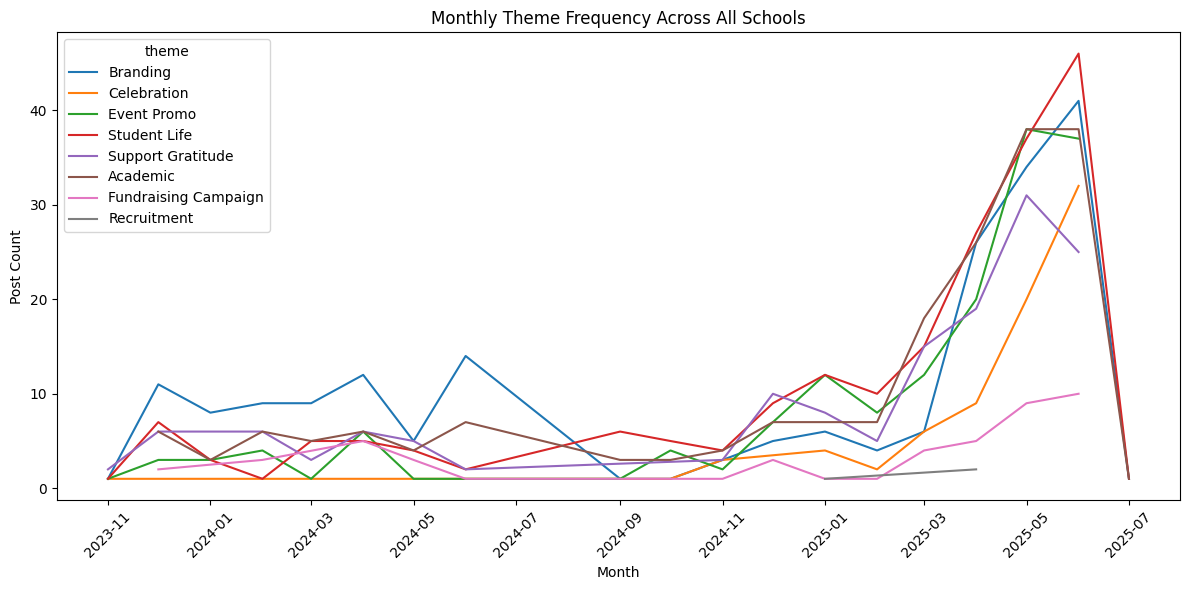

In [29]:
# plot of general theme volume over time (all schools
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate across all schools
theme_monthly_total = (
    theme_monthly_counts
    .groupby(['month_start', 'theme'])['post_count']
    .sum()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=theme_monthly_total, x='month_start', y='post_count', hue='theme')
plt.title("Monthly Theme Frequency Across All Schools")
plt.xlabel("Month")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

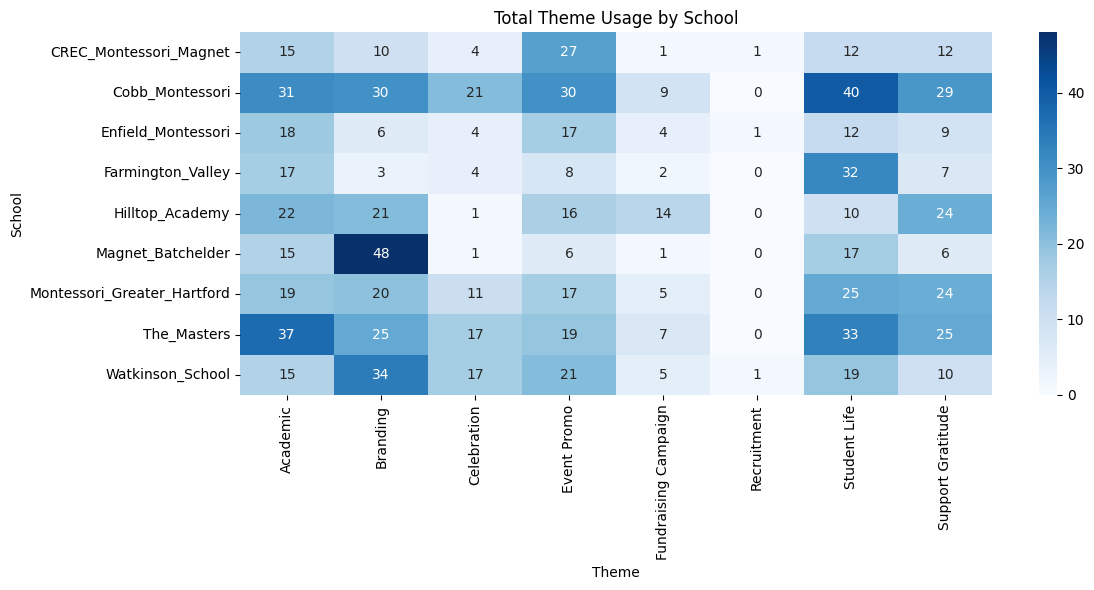

In [30]:
# theme mix by school (heatmap)
# Total theme count per school
theme_by_school = (
    theme_monthly_counts
    .groupby(['school_name', 'theme'])['post_count']
    .sum()
    .reset_index()
    .pivot(index='school_name', columns='theme', values='post_count')
    .fillna(0)
)

plt.figure(figsize=(12, 6))
sns.heatmap(theme_by_school, annot=True, fmt='.0f', cmap="Blues")
plt.title("Total Theme Usage by School")
plt.xlabel("Theme")
plt.ylabel("School")
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

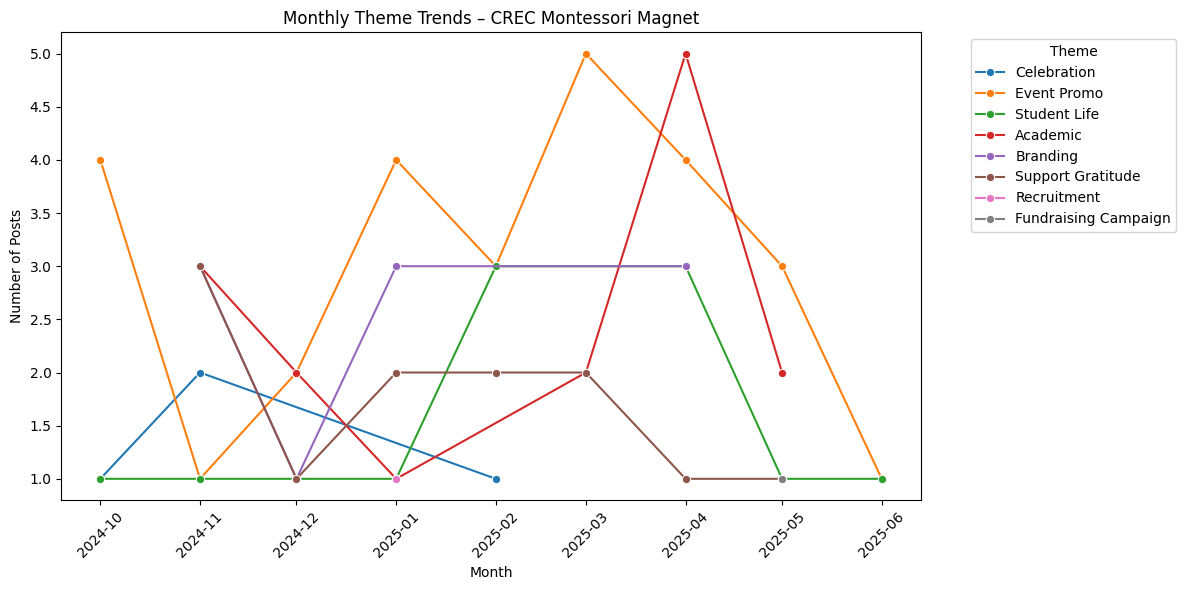

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

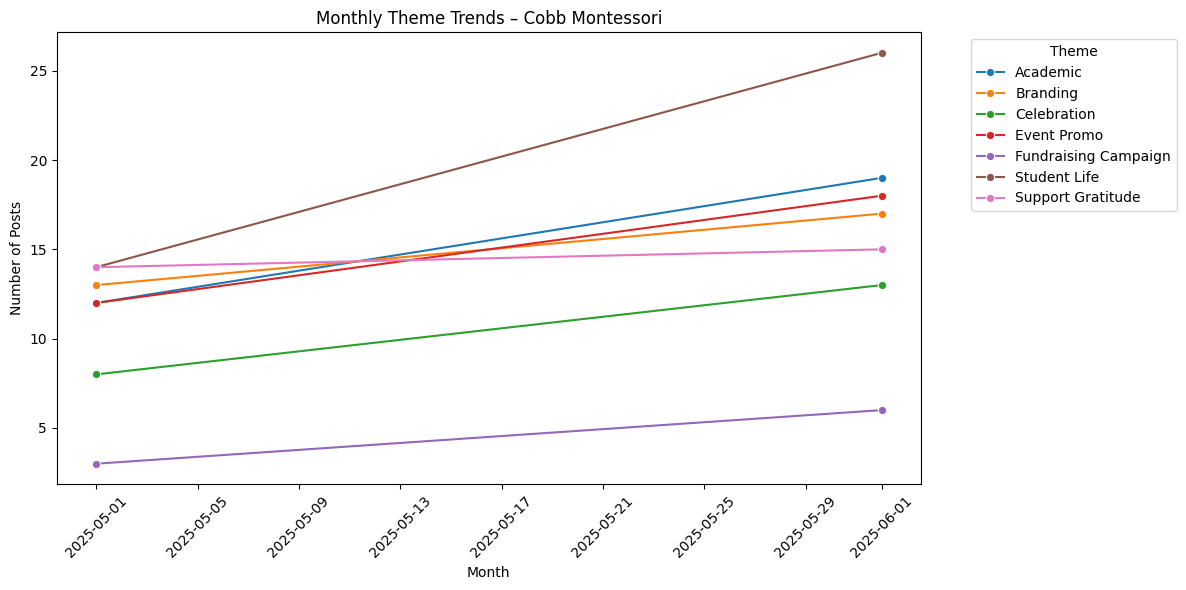

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

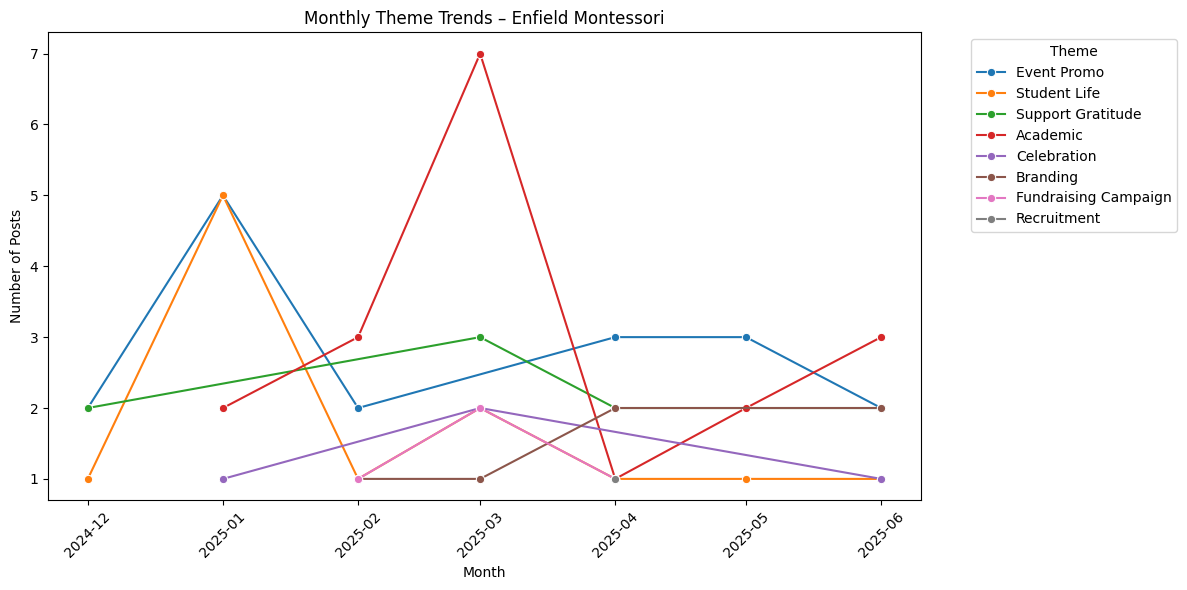

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

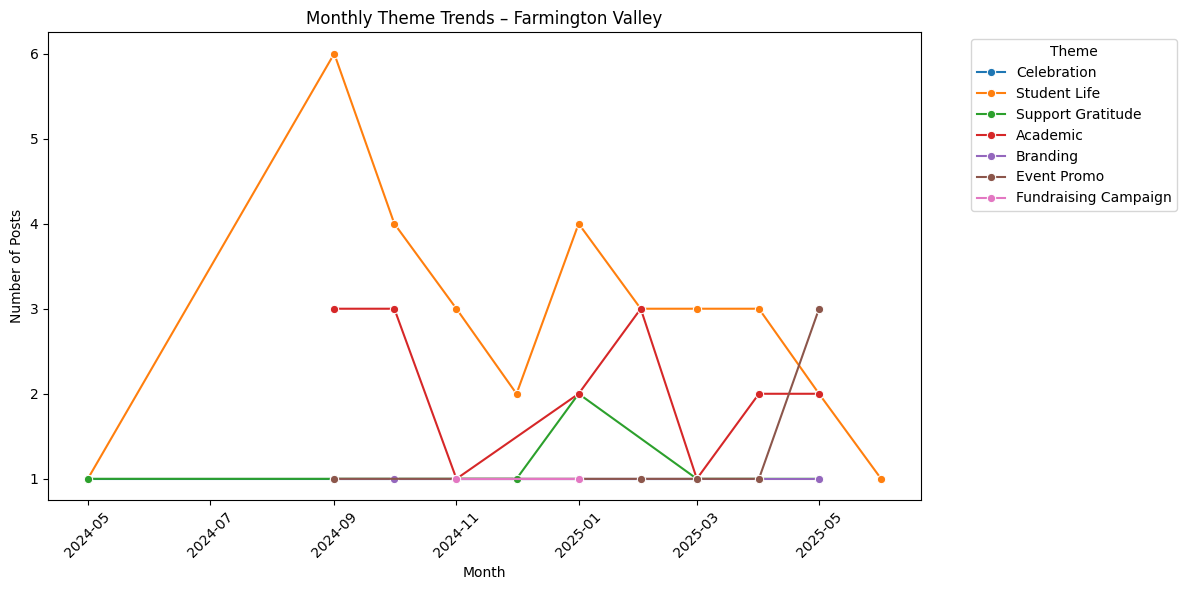

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

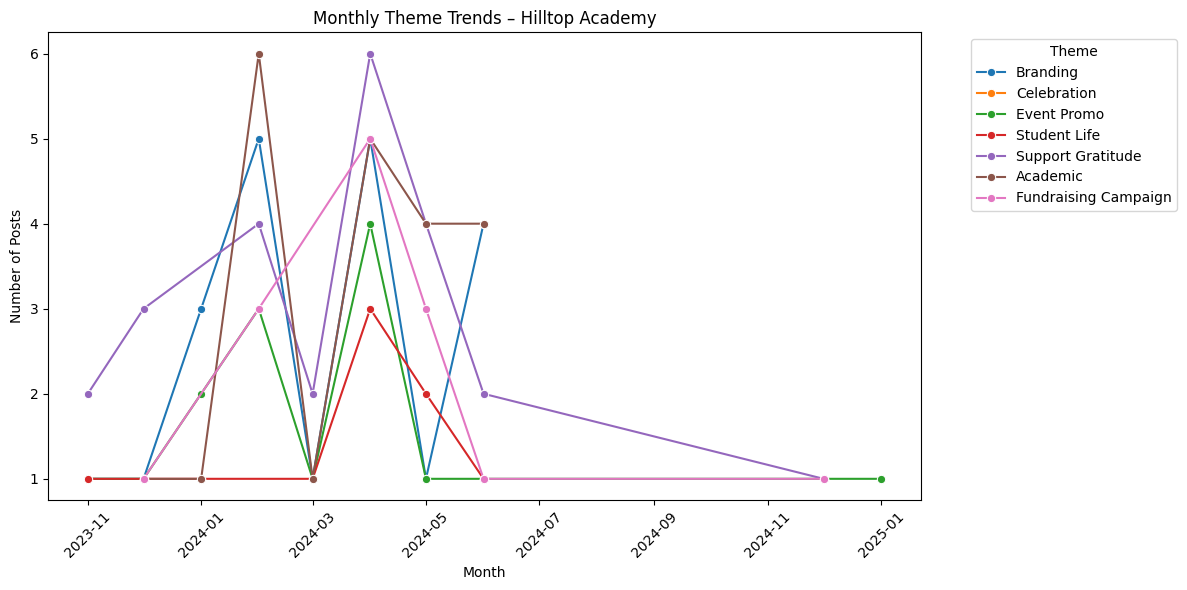

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

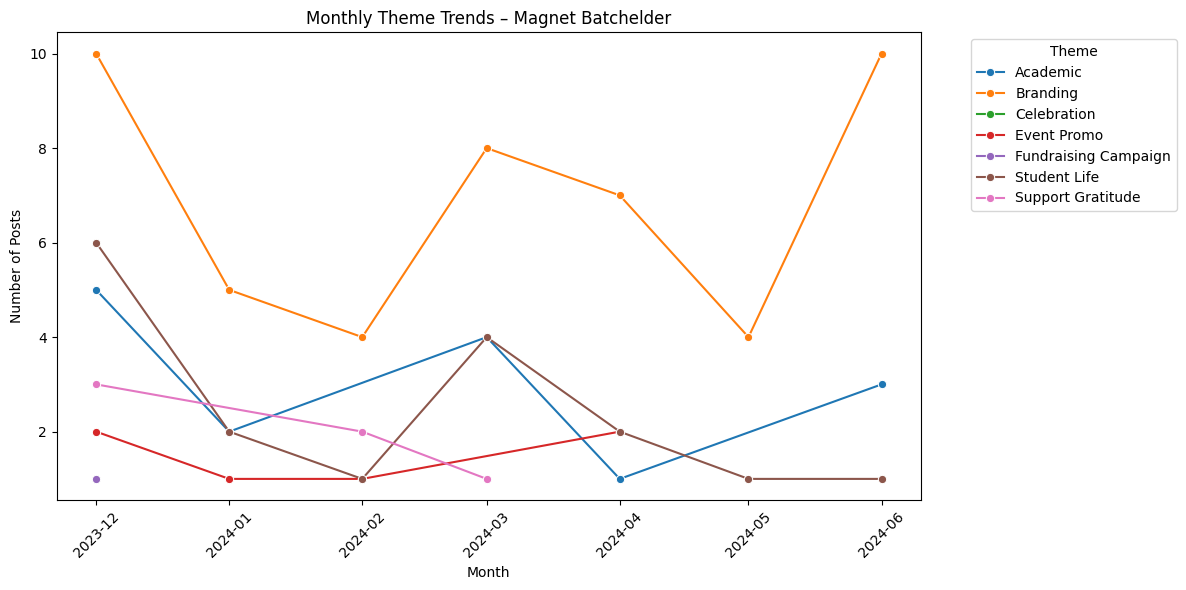

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

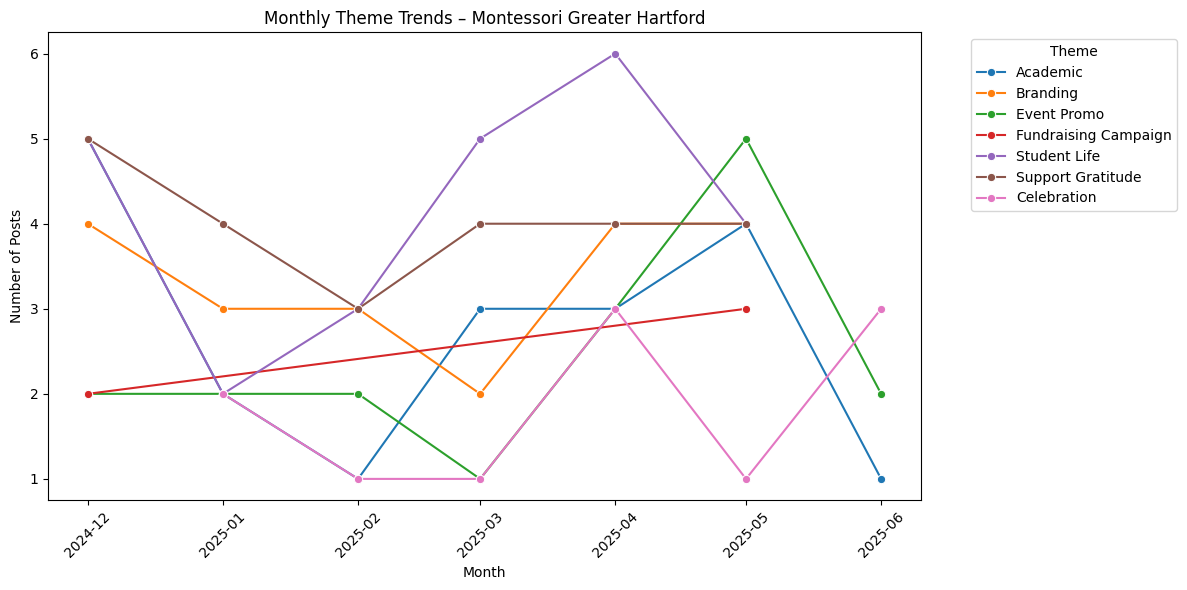

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

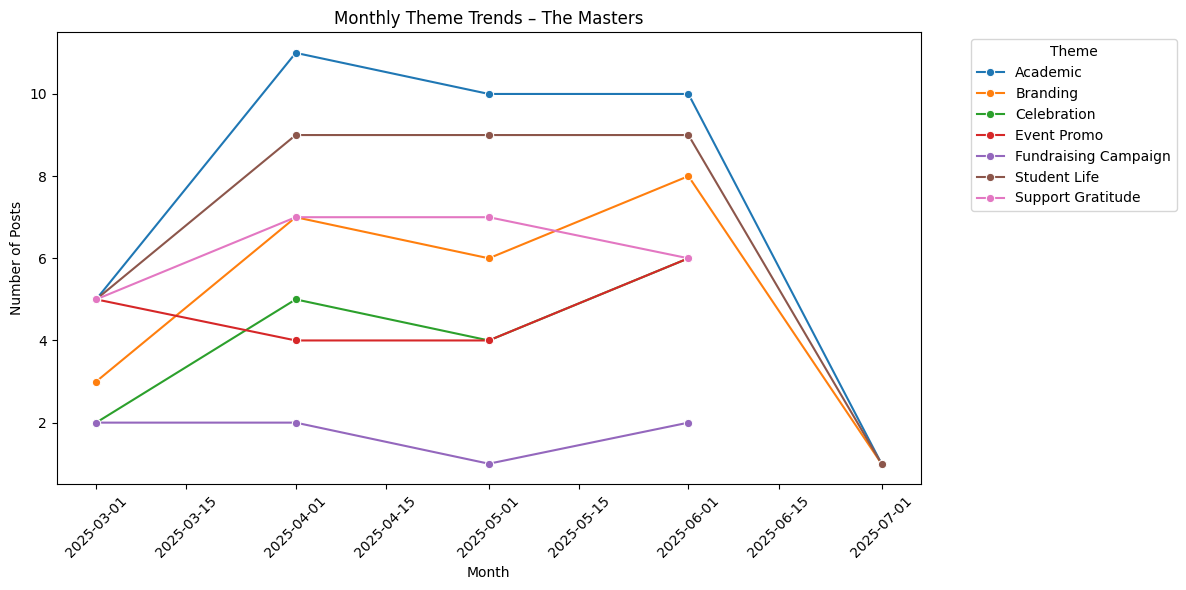

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_su

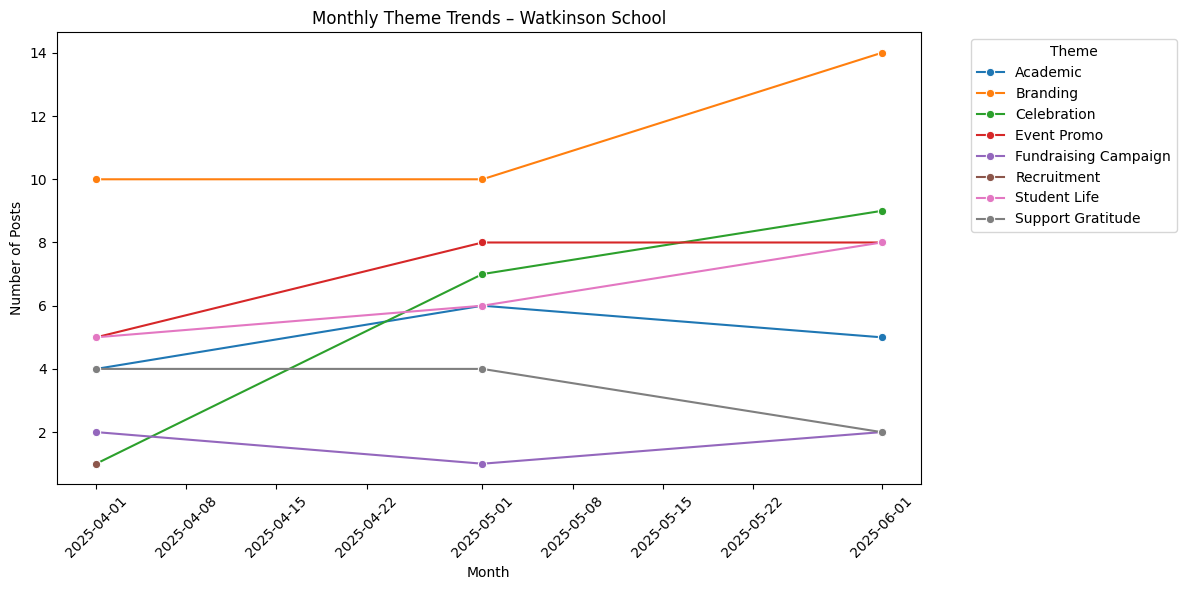

In [31]:
# monthly theme trends by school

# Get list of all schools
all_schools = theme_monthly_counts['school_name'].unique()

# Loop through and plot each school
for school in all_schools:
    data = theme_monthly_counts[theme_monthly_counts['school_name'] == school]

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=data,
        x='month_start',
        y='post_count',
        hue='theme',
        marker='o'
    )

    plt.title(f"Monthly Theme Trends – {school.replace('_', ' ')}")
    plt.xlabel("Month")
    plt.ylabel("Number of Posts")
    plt.xticks(rotation=45)
    plt.legend(title="Theme", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [32]:
# Start from your theme_by_school table
theme_share_by_school = theme_by_school.div(theme_by_school.sum(axis=1), axis=0) * 100
theme_share_by_school = theme_share_by_school.round(1)  # optional, for cleaner labels

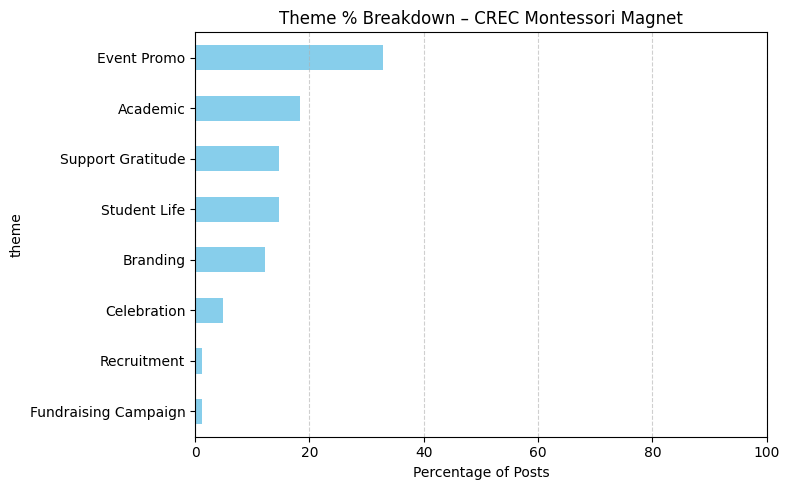

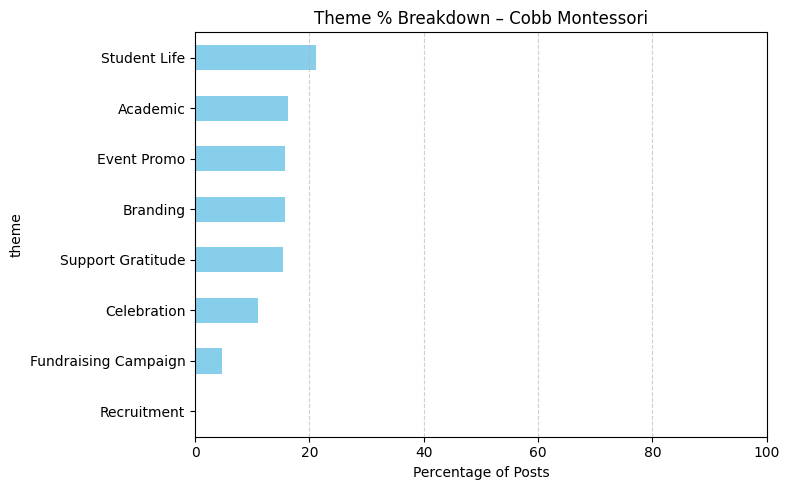

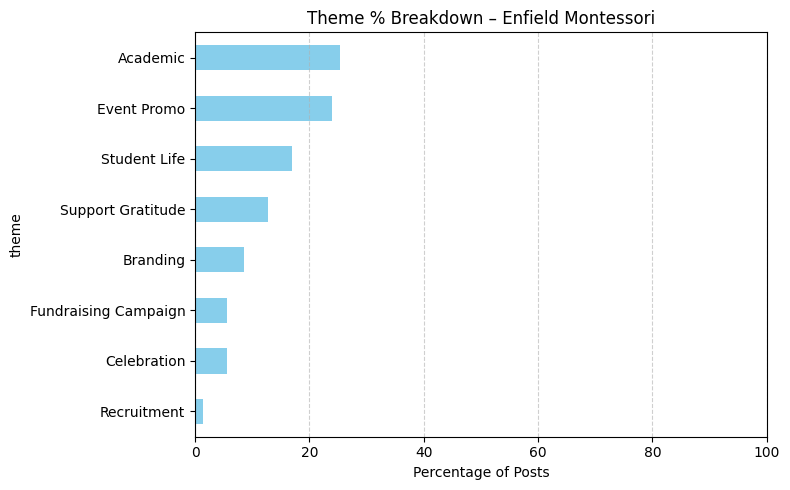

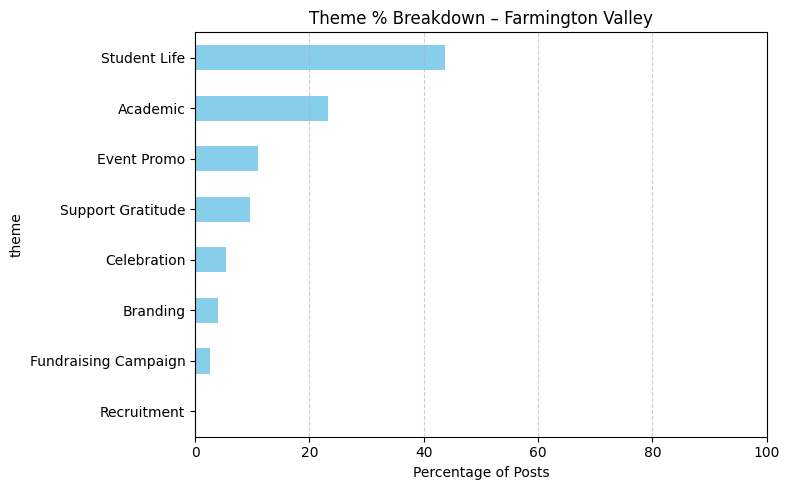

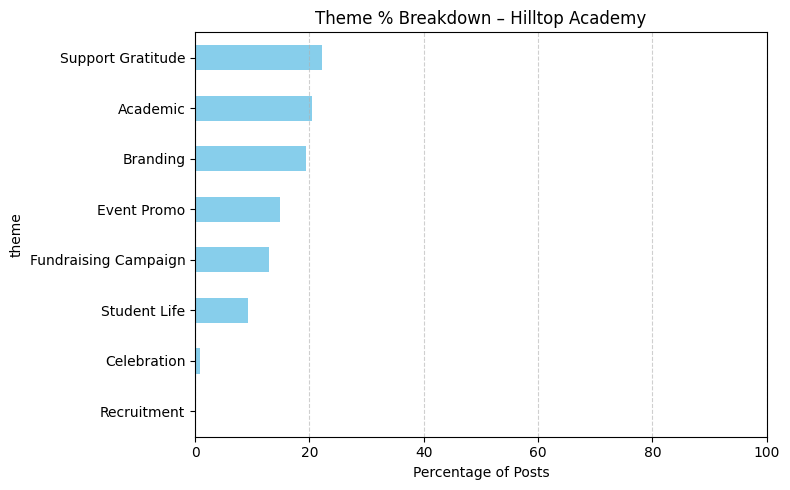

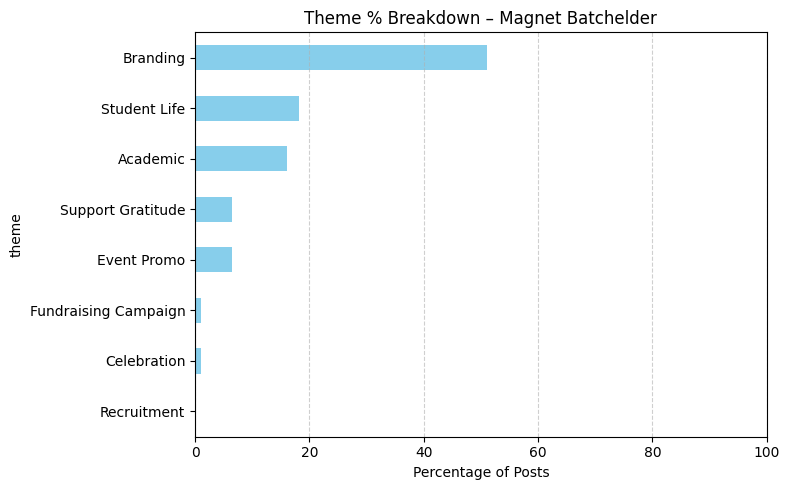

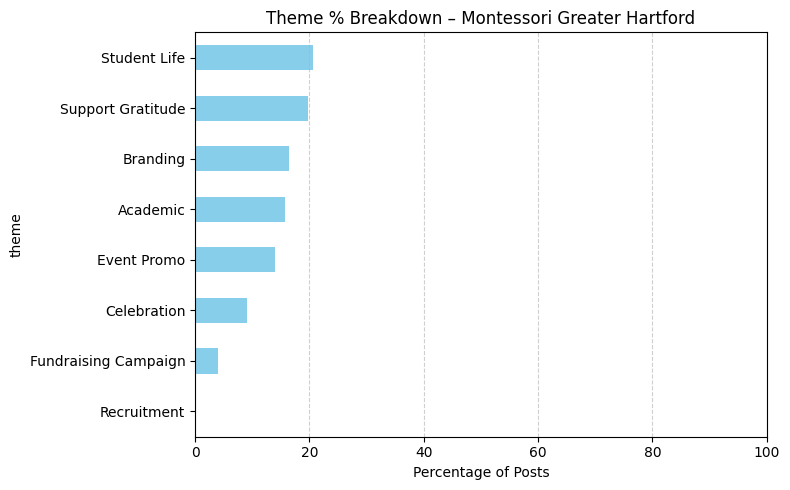

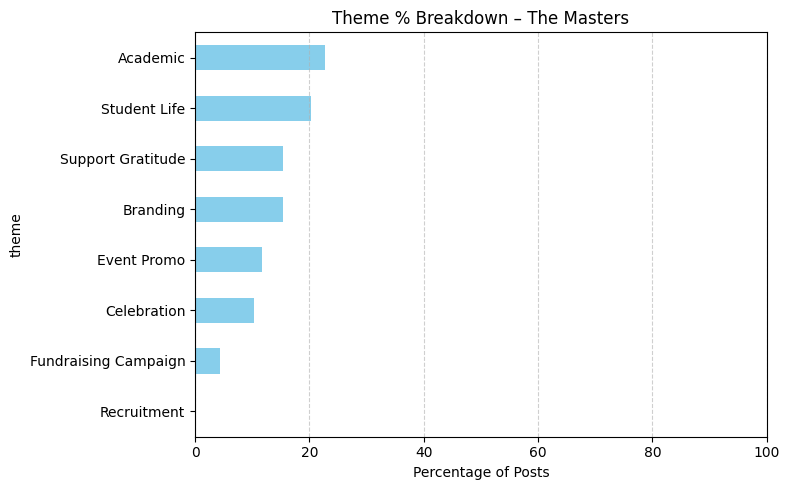

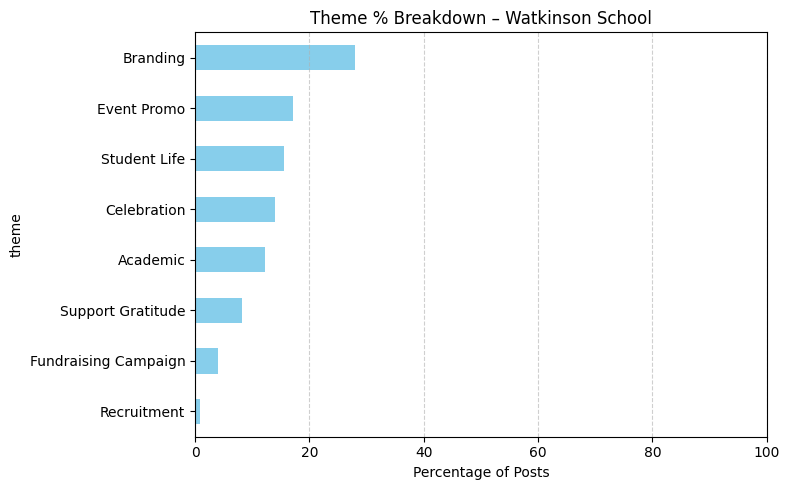

In [33]:
import matplotlib.pyplot as plt

# Plot each school
for school in theme_share_by_school.index:
    school_data = theme_share_by_school.loc[school].sort_values()

    plt.figure(figsize=(8, 5))
    school_data.plot(kind='barh', color='skyblue')

    plt.title(f"Theme % Breakdown – {school.replace('_', ' ')}")
    plt.xlabel("Percentage of Posts")
    plt.xlim(0, 100)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

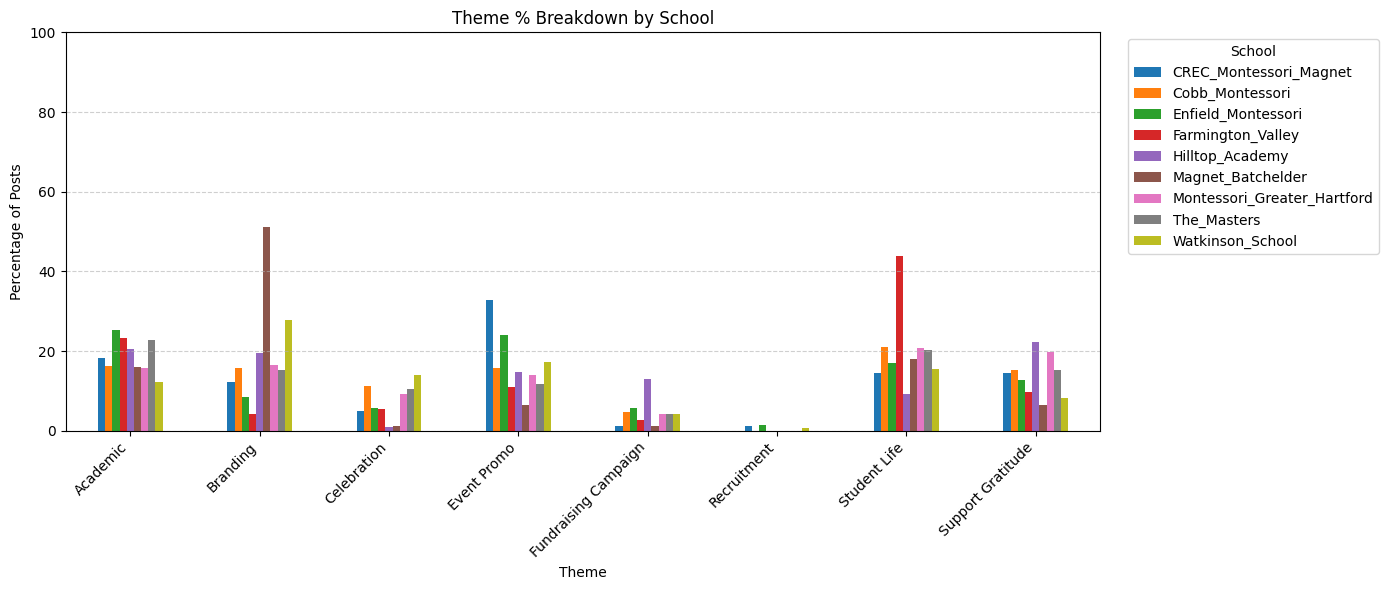

In [34]:
# Transpose for grouped bar plotting: themes as rows, schools as columns
plot_data = theme_share_by_school.T  # shape: [themes x schools]

# Plot
plot_data.plot(kind='bar', figsize=(14, 6))

plt.title("Theme % Breakdown by School")
plt.ylabel("Percentage of Posts")
plt.xlabel("Theme")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.legend(title="School", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 📊 Theme Usage Comparison by School

### 🔍 Objective
Compare how each school allocates its Facebook post content across defined communication themes, normalized by total posts, to identify strategic emphasis and potential content gaps.

### 📈 Method
- Theme usage counts per school were normalized as percentages.
- A grouped bar chart visualizes the % of posts per theme across all 9 schools.

### 🧠 Key Insights
- **Magnet Batchelder** remains overwhelmingly focused on **Branding** (~50%+), primarily due to repeated use of branded hashtags like `#wearehps` and `#mmbgrowingandglowing`.
- **The Masters** leans into **Academic** and **Branding** while underusing **Support**, **Celebration**, and **Event Promo**, projecting a formal, achievement-centered tone.
- **Cobb Montessori** emphasizes **Student Life** and **Event Promotion**, reinforcing a vibrant, high-activity messaging approach.
- **Enfield Montessori** and **Farmington Valley** continue to focus on **Student Life** and **Academic** posts, reflecting a student-centered and learning-focused narrative.
- **Hilltop Academy** features a balanced strategy with moderate presence in **Academic**, **Support**, and **Branding**, but under-leverages **Event Promo**.
- **CREC Montessori Magnet** still stands out with a high proportion of **Event Promo** content (30%+), indicating an emphasis on inviting participation and visibility.
- **Montessori Greater Hartford** maintains a strong mix across most categories, especially **Support**, **Celebration**, and **Student Life**.
- **Watkinson School** shows a well-balanced and deliberate presence across all categories, especially **Branding**, **Event Promo**, **Celebration**, and **Student Life**.

### ✅ Takeaway
This breakdown highlights:
- Theme overconcentration (e.g., branding-heavy schools)
- Gaps in content (e.g., underuse of celebration or support in some schools)
- Strategic contrasts — from highly branded messaging to community- or student-driven narratives

It also informs **positioning opportunities** for Ahsas to differentiate its voice in the competitive landscape.


In [35]:
# let's analyze the engagement (normalized by number of followers
follower_counts = {
    'Hilltop_Academy': 198,
    'Enfield_Montessori': 213,
    'Montessori_Greater_Hartford': 1000,
    'Farmington_Valley': 1000,
    'Watkinson_School': 1900,
    'Magnet_Batchelder': 493,
    'Cobb_Montessori': 4600,
    'CREC_Montessori_Magnet': 726,
    'The_Masters' : 1700
}

In [36]:
# Normalize engagement by followers count

# Load the cleaned post dataset
#df = pd.read_csv('/Users/marcomagnolo/Desktop/NEXT/pro_bono_projects/ahsas_school/school_analysis/social_media/facebook_posts_with_themes_and_engagement (1).csv')

# Step 1: Add total engagement column
df['total_engagement'] = (
    df['reactions'] + df['comments'] + df['shares']
)

# Step 2: Define follower counts per school
follower_counts = {
    'Cobb_Montessori': 4600,
    'Enfield_Montessori': 213,
    'Hilltop_Academy': 198,
    'Magnet_Batchelder': 493,
    'CREC_Montessori_Magnet': 726,
    'Montessori_Greater_Hartford': 1000,
    'Farmington_Valley': 1000,
    'Watkinson_School': 1900,
    'The_Masters' : 1700
}

# Step 3: Map follower counts and compute normalized engagement
df['followers'] = df['school_name'].map(follower_counts)
df['normalized_engagement'] = df['total_engagement'] / df['followers']

In [37]:
# reshape for theme-level enagagement
# Melt theme flags into long format
theme_cols = [col for col in df.columns if col.startswith('is_')]

theme_long_df = df.melt(
    id_vars=['school_name', 'reactions', 'comments', 'shares', 'total_engagement', 'normalized_engagement'],
    value_vars=theme_cols,
    var_name='theme',
    value_name='is_present'
)

# Filter for active theme flags
theme_long_df = theme_long_df[theme_long_df['is_present'] == 1]
theme_long_df['theme'] = theme_long_df['theme'].str.replace('is_', '')

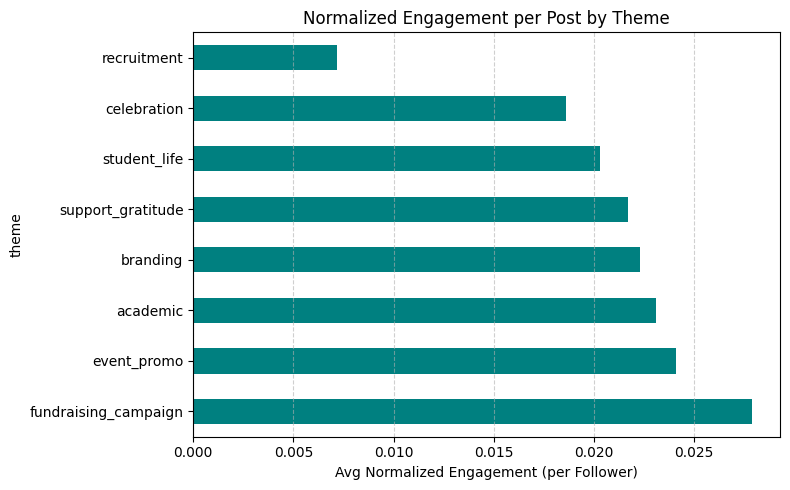

In [38]:
# Average engagement by theme (normalized)
# Group and summarize
theme_norm_engagement = (
    theme_long_df.groupby('theme')['normalized_engagement']
    .mean()
    .sort_values(ascending=False)
    .round(4)
)

# Plot
import matplotlib.pyplot as plt

theme_norm_engagement.plot(kind='barh', figsize=(8, 5), color='teal')
plt.xlabel("Avg Normalized Engagement (per Follower)")
plt.title("Normalized Engagement per Post by Theme")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 📊 Normalized Engagement Analysis by Post Theme

### 🧠 Objective
To understand which content **themes** (e.g., *branding*, *student life*, *fundraising*) drive the highest engagement **relative to audience size**, so that the future Ahsas School can prioritize the most effective strategies regardless of follower count.

---

### 📦 Step Summary
1. **Total engagement** per post was computed as:  
   `total_engagement = reactions + comments + shares`

2. Each post’s engagement was **normalized by the number of Facebook followers** of the page that posted it:  
   `normalized_engagement = total_engagement / followers`

3. The **average normalized engagement** was then calculated for each content theme across all schools.

---

### 👥 Follower Counts by School

| School                             | Facebook Followers |
|-----------------------------------|---------------------|
| Cobb Montessori                   | 4,600               |
| Enfield Montessori                | 705                 |
| Hilltop Academy                   | 198                 |
| Montessori Magnet at Batchelder  | 493                 |
| CREC Montessori Magnet            | 726                 |
| Montessori Greater Hartford       | 1,000               |
| Farmington Valley                 | 1,000               |
| Watkinson School                  | 1,900               |
| The Masters School                | 1,700               |

---

### 🧮 What Does “Normalized Engagement” Mean?

The normalized value tells us how engaging a post was **relative to the size of its audience**.

#### 🔹 Example:
A school with **1,000 followers** posts a *branding* message that gets:
- 8 reactions  
- 1 comment  
- 1 share  
→ **Total engagement = 10**

`Normalized Engagement = 10 / 1,000 = 0.01`  
This means **1% of the audience engaged with the post**.

If the average for “fundraising_campaign” is **0.028**, it means:
> On average, 2.8% of the audience engages with a fundraising-themed post — the highest among all themes.

---

### 📈 Results: Normalized Engagement by Theme

The bar plot below displays the **average normalized engagement** per post **for each theme**, aggregated across all schools.

Key takeaways:
- **Fundraising Campaigns** drove the highest engagement per follower.
- **Academic**, **Branding**, and **Event Promotion** also performed well.
- **Recruitment** content saw the lowest normalized engagement — possibly due to narrower targeting or less universal appeal.

*Note: Values are unitless proportions (e.g., 0.01 = 1% of followers engaging per post).*

---

In [39]:
# Let's do some sentiment analysis

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon if not already present
nltk.download('vader_lexicon')

# Load dataset (replace with your path if needed)
#df = pd.read_csv("facebook_posts_with_themes_and_engagement.csv")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marcomagnolo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [40]:
df['school_name'].unique()

array(['Cobb_Montessori', 'Enfield_Montessori', 'Hilltop_Academy',
       'Magnet_Batchelder', 'CREC_Montessori_Magnet',
       'Montessori_Greater_Hartford', 'Farmington_Valley',
       'Watkinson_School', 'The_Masters'], dtype=object)

In [41]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Apply to the cleaned post text
df['sentiment_scores'] = df['text_clean'].apply(vader.polarity_scores)

# Expand the compound, pos, neu, neg into separate columns
sentiment_df = pd.json_normalize(df['sentiment_scores'])
df = pd.concat([df, sentiment_df], axis=1)

In [42]:
df.head()

school_name                                          post_text  \
0  Cobb_Montessori  Our Primary campers had another amazing visit ...   
1  Cobb_Montessori  Cobb Alum Spotlight: Lizzy Strapp \nA proud Co...   
2  Cobb_Montessori  Cobb Alum Spotlight: Jamison Burnett \nCongrat...   
3  Cobb_Montessori  A few Cobb families gathered for a special aft...   
4  Cobb_Montessori  Student-Led Recycling Challenge Makes a Global...   

    timestamp  comments  reactions  shares    year  month   day    weekday  \
0  2025-06-26         0          5       0  2025.0    6.0  26.0   Thursday   
1  2025-06-25         6         20       0  2025.0    6.0  25.0  Wednesday   
2  2025-06-24         1         11       1  2025.0    6.0  24.0    Tuesday   
3  2025-06-23         1          8       0  2025.0    6.0  23.0     Monday   
4  2025-06-23         1          8       0  2025.0    6.0  23.0     Monday   

   ...  is_fundraising_campaign num_categories total_engagement followers  \
0  ...                    False              3                5      4600   
1  ...                    False              3               26      4600   
2  ...                    False              6               13      4600   
3  ...                     True              4                9      4600   
4  ...                    False              5                9      4600   

  normalized_engagement                                   sentiment_scores  \
0              0.001087  {'neg': 0.0, 'neu': 0.766, 'pos': 0.234, 'comp...   
1              0.005652  {'neg': 0.0, 'neu': 0.889, 'pos': 0.111, 'comp...   
2              0.002826  {'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...   
3              0.001957  {'neg': 0.0, 'neu': 0.815, 'pos': 0.185, 'comp...   
4              0.001957  {'neg': 0.032, 'neu': 0.671, 'pos': 0.297, 'co...   

     neg    neu    pos  compound  
0  0.000  0.766  0.234    0.8997  
1  0.000  0.889  0.111    0.9208  
2  0.000  0.784  0.216    0.9715  
3  0.000  0.815  0.185    0.9059  
4  0.032  0.671  0.297    0.9882  

[5 rows x 33 columns]

In [43]:
def classify_sentiment(compound_score):
    if compound_score >= 0.2:
        return 'positive'
    elif compound_score <= -0.2:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['compound'].apply(classify_sentiment)

In [44]:
df.sentiment.value_counts()

sentiment
positive    332
neutral      96
negative      7
Name: count, dtype: int64

In [45]:
df[df['sentiment'] == 'negative'][['school_name', 'post_text', 'compound']]

school_name  \
79       Enfield_Montessori   
226  CREC_Montessori_Magnet   
298       Farmington_Valley   
324       Farmington_Valley   
331       Farmington_Valley   
333       Farmington_Valley   
389             The_Masters   

                                             post_text  compound  
79   Dr. Montessori, talking about the the first ti...   -0.2960  
226  Due to the weather conditions we are on a two-...   -0.3182  
298  Students from Lower Elementary through Middle ...   -0.4389  
324  Lower elementary first year students study the...   -0.3595  
331  Some lower elementary and aftercare moments! #...   -0.3595  
333  A peak inside the lower school! #21stcenturymo...   -0.3595  
389  When you pay attention to what a child needs n...   -0.4767

In [46]:
for post in df[df['sentiment'] == 'negative']['post_text']:
    print("🔻 Negative Post:")
    print(post)
    print("—" * 80)

🔻 Negative Post:
Dr. Montessori, talking about the the first time a child writes spontaneously: 
" If they had had no ideas, they would not have written. This explosion into writing came suddenly. We could even give the exact time when each child started to write. We could say, 'This little child began to write yesterday at three o'clock. "
————————————————————————————————————————————————————————————————————————————————
🔻 Negative Post:
Due to the weather conditions we are on a two-hour delay today, Monday December 16th. Montessori will open at 10:40.
————————————————————————————————————————————————————————————————————————————————
🔻 Negative Post:
Students from Lower Elementary through Middle School have been working hard in rehearsals for this year's musical, Annie! #21stcenturymontessori
————————————————————————————————————————————————————————————————————————————————
🔻 Negative Post:
Lower elementary first year students study the beginning of the world!
#21stcenturymontessori
———————

In [47]:
# Drop sentiment-related columns
df = df.drop(columns=['sentiment_scores', 'compound', 'pos', 'neu', 'neg', 'sentiment'], errors='ignore')

## 💬 Sentiment Analysis – Summary and Limitations

### 📊 Observed Distribution
Out of 387 total Facebook posts:
- **Positive**: 289 posts (~75%)
- **Neutral**: 93 posts (~24%)
- **Negative**: 5 posts (~1%)

### 🔍 Observations
- Nearly all posts are **positive or neutral**, which aligns with expectations for school-run pages focused on celebration, promotion, and community-building.
- The **few posts labeled as “negative”** include weather-related delays (valid) but also incorrectly flagged examples like:
  - “Lower elementary first year students study the beginning of the world!”
  - “A peek inside the lower school!”

These misclassifications likely stem from the word **“lower”**, which VADER misinterprets with negative sentiment in other contexts (e.g., "lower quality," "lower scores").

---

### ❌ Conclusion
**Sentiment analysis is not a meaningful differentiator** in this context:

- School Facebook content is inherently positive.
- Off-the-shelf models like VADER struggle with domain-specific terms (e.g., “lower school” ≠ negative emotion).
- There’s little variation in emotional tone across schools or themes — making sentiment a **low-value metric for insight generation** in this case.

---

In [48]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marcomagnolo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marcomagnolo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
# Prepare text data
# Step 1: Combine NLTK + custom stopwords
nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = set([
    'school', 'student', 'year', 'day', 'class', 'week', 'today', 'new', 'one',
    'cobb', 'watkinson', 'wearehps', 'mmbgrowingandglowing', 
    'stcenturymontessori', 'montessori', 'msgh', 'fvam', 'hilltop',
    'thank', 'https'
])
all_stopwords = nltk_stopwords.union(custom_stopwords)

# Step 2: Prepare text data
texts = df['text_clean'].astype(str).tolist()

# Step 3: Tokenize and remove stopwords
tokenized_texts = [
    [word for word in word_tokenize(post.lower()) if word.isalpha() and word not in all_stopwords]
    for post in texts
]

# Step 4: Filter out short/empty posts
tokenized_texts = [tokens for tokens in tokenized_texts if len(tokens) > 2]

In [50]:
# Build LDA Model
# Step 5: Create dictionary and corpus
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Step 6: Train LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=6,
    random_state=42,
    passes=20
)

# Step 7: Print topics
print("📘 Top Topics:")
for i, topic in lda_model.print_topics(num_words=8):
    print(f"🔹 Topic {i}: {topic}")

📘 Top Topics:
🔹 Topic 0: 0.011*"students" + 0.008*"us" + 0.005*"like" + 0.005*"see" + 0.005*"hartford" + 0.005*"different" + 0.004*"joy" + 0.004*"happy"
🔹 Topic 1: 0.012*"students" + 0.010*"award" + 0.007*"independentschool" + 0.006*"hartfordct" + 0.006*"privateschool" + 0.006*"elementary" + 0.005*"upper" + 0.005*"us"
🔹 Topic 2: 0.021*"students" + 0.008*"elementary" + 0.006*"lower" + 0.005*"master" + 0.005*"together" + 0.004*"parents" + 0.004*"learning" + 0.004*"fun"
🔹 Topic 3: 0.006*"every" + 0.006*"love" + 0.005*"us" + 0.005*"books" + 0.005*"community" + 0.004*"friends" + 0.004*"thisiscobb" + 0.004*"next"
🔹 Topic 4: 0.008*"support" + 0.008*"visit" + 0.007*"students" + 0.007*"learning" + 0.007*"learn" + 0.007*"us" + 0.006*"time" + 0.006*"hilltopheroes"
🔹 Topic 5: 0.010*"students" + 0.008*"us" + 0.006*"center" + 0.004*"fun" + 0.004*"support" + 0.004*"going" + 0.004*"celebration" + 0.004*"community"


In [51]:
# Branded terms manually identified from LDA output
branded_terms = [
    'wearehps', 'mmbgrowingandglowing', 'hilltopheroes', 'thisiscobb',
    'cobb', 'msgh', 'fvam', 'watkinson', 'hilltop', 'masters'
]

def remove_branded_terms(text, branded_list):
    tokens = text.split()
    return ' '.join([word for word in tokens if word not in branded_list])

df['text_clean_nobrands'] = df['text_clean'].apply(lambda x: remove_branded_terms(x, branded_terms))

In [52]:
# Tokenize all posts and keep index
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

tokenized_map = {}  # key: row index, value: token list
for idx, post in df['text_clean_nobrands'].items():
    tokens = [word for word in word_tokenize(post.lower()) if word.isalpha() and word not in stop_words]
    if len(tokens) > 2:
        tokenized_map[idx] = tokens

In [53]:
# Build LDA Model
# Rebuild texts and dictionary
tokenized_texts = list(tokenized_map.values())
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [54]:
# Train NEW LDA model on the cleaned + re-tokenized corpus
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=6,
    random_state=42,
    passes=20
)

In [55]:
# Assign dominant topics using index
topic_assignments = {}
for idx, doc in zip(tokenized_map.keys(), corpus):
    topic_probs = lda_model.get_document_topics(doc)
    topic_assignments[idx] = max(topic_probs, key=lambda x: x[1])[0] if topic_probs else -1

# Create a full list with fallback for unmatched rows
df['lda_topic'] = df.index.map(lambda idx: topic_assignments.get(idx, -1))

In [56]:
# 🧾 Print Top Topics After Retraining
print("📘 Updated Top Topics:")
for i, topic in lda_model.print_topics(num_words=8):
    print(f"🔹 Topic {i}: {topic}")

📘 Updated Top Topics:
🔹 Topic 0: 0.011*"montessori" + 0.007*"class" + 0.007*"children" + 0.006*"school" + 0.006*"cobb" + 0.006*"students" + 0.005*"fun" + 0.005*"love"
🔹 Topic 1: 0.019*"school" + 0.014*"students" + 0.008*"us" + 0.007*"day" + 0.007*"elementary" + 0.007*"middle" + 0.005*"year" + 0.005*"work"
🔹 Topic 2: 0.013*"school" + 0.012*"students" + 0.008*"academy" + 0.008*"support" + 0.008*"award" + 0.007*"us" + 0.006*"hilltop" + 0.005*"learn"
🔹 Topic 3: 0.018*"school" + 0.012*"students" + 0.007*"new" + 0.007*"year" + 0.005*"community" + 0.005*"fun" + 0.005*"us" + 0.005*"learn"
🔹 Topic 4: 0.009*"students" + 0.008*"school" + 0.007*"cobb" + 0.006*"thank" + 0.005*"day" + 0.004*"different" + 0.004*"meet" + 0.003*"way"
🔹 Topic 5: 0.011*"week" + 0.011*"school" + 0.010*"students" + 0.009*"today" + 0.008*"us" + 0.007*"day" + 0.007*"year" + 0.006*"love"


In [57]:
# compare LDA topics with Manual Themes
# Identify theme columns
theme_cols = [col for col in df.columns if col.startswith("is_")]

# Reshape the data: one row per (post, theme) if the theme is active
theme_long = df.melt(
    id_vars=['lda_topic'],
    value_vars=theme_cols,
    var_name='theme',
    value_name='is_present'
)

# Keep only rows where the theme is marked present
theme_long = theme_long[theme_long['is_present'] == 1]

# Create a topic-theme cross-tab
cross_tab = pd.crosstab(theme_long['lda_topic'], theme_long['theme'])

# Display it
cross_tab

theme      is_academic  is_branding  is_celebration  is_event_promo  \
lda_topic                                                             
-1                   0            5               1               3   
 0                  31           26               8              14   
 1                  33           32              17              27   
 2                  32           35              12              25   
 3                  32           41              17              32   
 4                  20           22               5              12   
 5                  41           36              20              48   

theme      is_fundraising_campaign  is_recruitment  is_student_life  \
lda_topic                                                             
-1                               0               0                4   
 0                               7               0               23   
 1                               7               1               46   
 2                              13               0               25   
 3                               7               2               44   
 4                               5               0               15   
 5                               9               0               43   

theme      is_support_gratitude  
lda_topic                        
-1                            1  
 0                           23  
 1                           23  
 2                           24  
 3                           31  
 4                           13  
 5                           31

In [58]:
lda_topic_labels = {
    0: "Montessori-style Culture & Children’s Experience",       # montessori, children, day, special
    1: "Student Recognition & School Promotion",           # award, student, week, hartfordct
    2: "Childhood & Daily Life",                     # happy, class, children, today
    3: "Community Support & School Values",                # support, thank, love, learn
    4: "Academic Journey & Milestones",                    # class, elementary, cobb, year
    5: "Classroom Work & Routines",                        # work, see, today, new
    -1: "Unclassified / Too Short"
}

# Create a new column in df
df['lda_topic_label'] = df['lda_topic'].map(lda_topic_labels)

/var/folders/9z/9j1rdhn164b4l3msjpgj1zd40000gn/T/ipykernel_48816/1922279835.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.values, y=topic_counts.index, palette='viridis')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pa

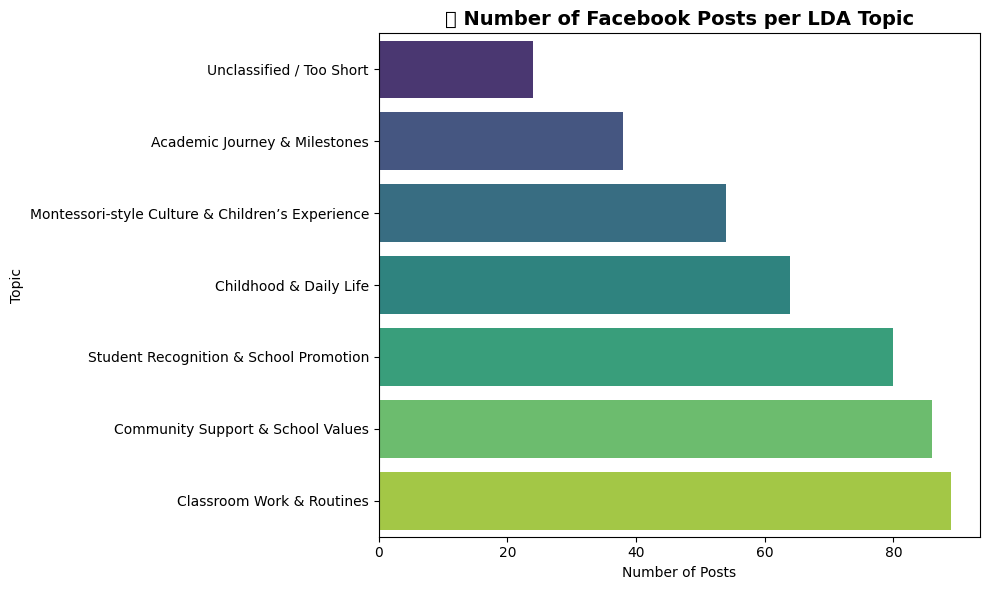

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of posts per topic label
topic_counts = df['lda_topic_label'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=topic_counts.values, y=topic_counts.index, palette='viridis')
plt.title("📊 Number of Facebook Posts per LDA Topic", fontsize=14, weight='bold')
plt.xlabel("Number of Posts")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

In [60]:
# Step 1: Define follower counts per school
follower_counts = {
    'Cobb_Montessori': 4600,
    'Enfield_Montessori': 705,
    'Hilltop_Academy': 198,
    'Magnet_Batchelder': 493,
    'CREC_Montessori_Magnet': 726,
    'Montessori_Greater_Hartford': 1000,
    'Farmington_Valley': 1000,
    'Watkinson_School': 1900,
    'The_Masters': 1700
}

# Step 2: Map follower counts and compute engagement
df['followers'] = df['school_name'].map(follower_counts)
df['total_engagement'] = df['reactions'] + df['comments'] + df['shares']
df['normalized_engagement'] = df['total_engagement'] / df['followers']

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/var/folders/9z/9j1rdhn164b4l3msjpgj1zd40000gn/T/ipykernel_48816/3999122882.py:9: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


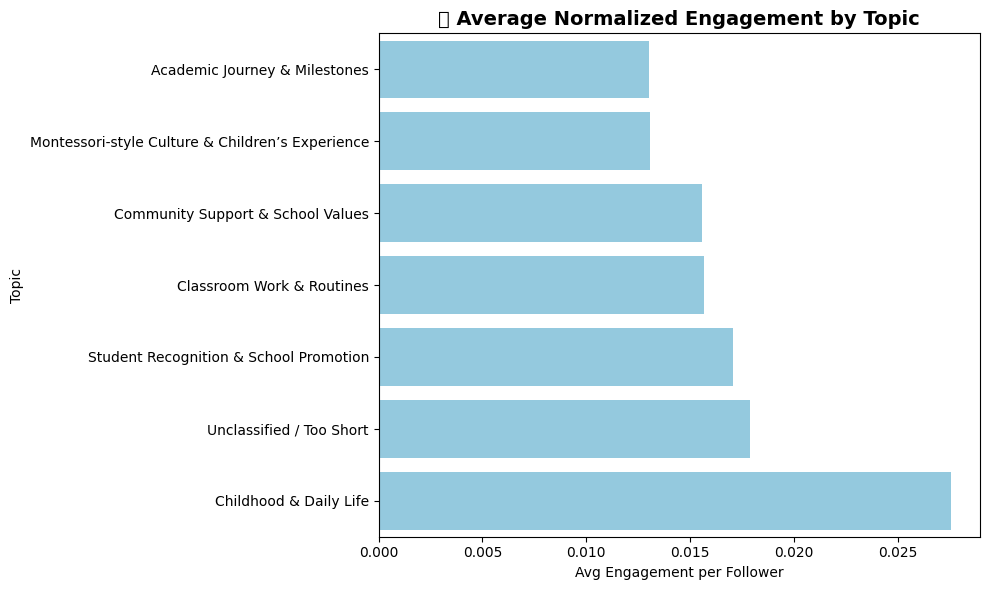

In [61]:
# Group by topic and compute average normalized engagement
engagement_by_topic = df.groupby('lda_topic_label')['normalized_engagement'].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=engagement_by_topic.values, y=engagement_by_topic.index, color='skyblue')
plt.title("💡 Average Normalized Engagement by Topic", fontsize=14, weight='bold')
plt.xlabel("Avg Engagement per Follower")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/var/folders/9z/9j1rdhn164b4l3msjpgj1zd40000gn/T/ipykernel_48816/926530113.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_engagement.values, y=topic_engagement.index, ax=axes[1], palette="Blues_d")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you wi

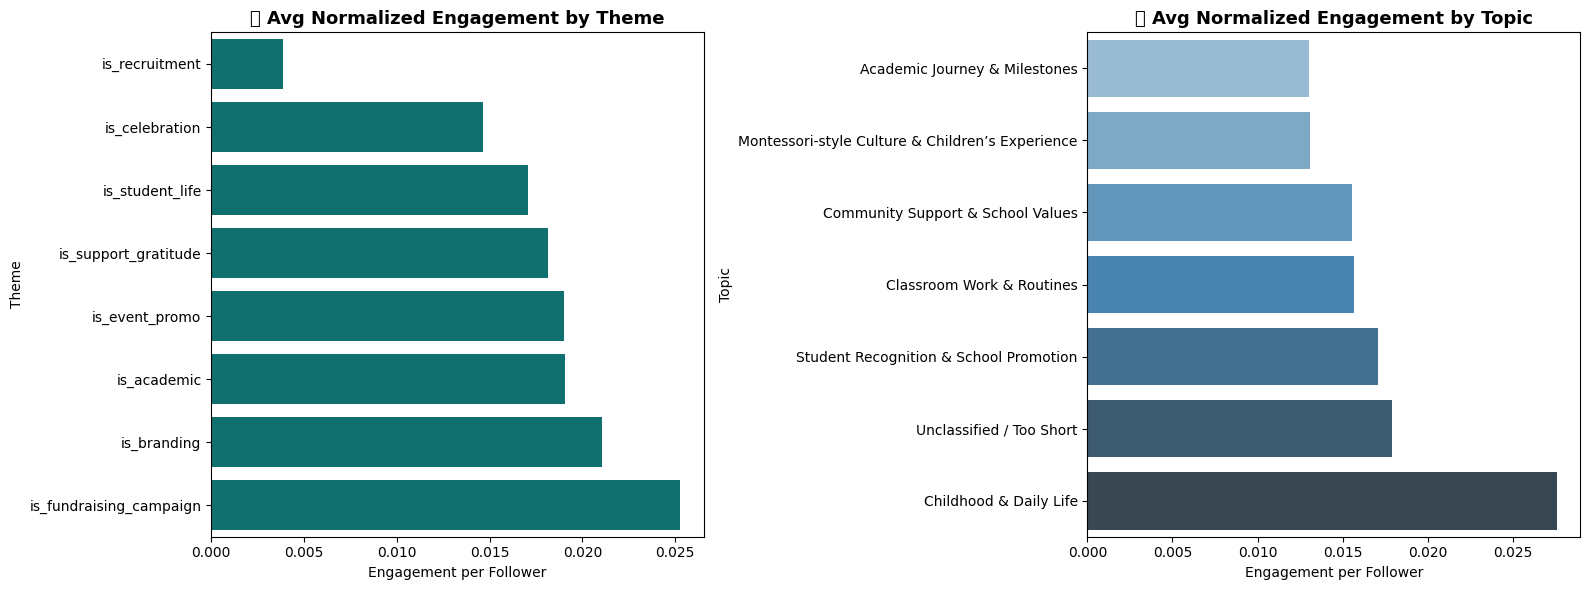

In [62]:
# STEP 1: Recalculate engagement
follower_counts = {
    'Cobb_Montessori': 4600,
    'Enfield_Montessori': 705,
    'Hilltop_Academy': 198,
    'Magnet_Batchelder': 493,
    'CREC_Montessori_Magnet': 726,
    'Montessori_Greater_Hartford': 1000,
    'Farmington_Valley': 1000,
    'Watkinson_School': 1900,
    'The_Masters': 1700
}

df['followers'] = df['school_name'].map(follower_counts)
df['total_engagement'] = df['reactions'] + df['comments'] + df['shares']
df['normalized_engagement'] = df['total_engagement'] / df['followers']

# STEP 2: Calculate average engagement by theme
theme_cols = [col for col in df.columns if col.startswith("is_")]
df_theme = df.melt(id_vars=["normalized_engagement"], value_vars=theme_cols,
                   var_name="theme", value_name="is_present")
df_theme = df_theme[df_theme["is_present"] == True]
theme_engagement = df_theme.groupby("theme")["normalized_engagement"].mean().sort_values()

# STEP 3: Calculate average engagement by topic
topic_engagement = df.groupby("lda_topic_label")["normalized_engagement"].mean().sort_values()

# STEP 4: Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Theme — now solid teal
sns.barplot(x=theme_engagement.values, y=theme_engagement.index, ax=axes[0], color="teal")
axes[0].set_title("📘 Avg Normalized Engagement by Theme", fontsize=13, weight='bold')
axes[0].set_xlabel("Engagement per Follower")
axes[0].set_ylabel("Theme")

# Right: Topic — now shaded blue palette
sns.barplot(x=topic_engagement.values, y=topic_engagement.index, ax=axes[1], palette="Blues_d")
axes[1].set_title("📘 Avg Normalized Engagement by Topic", fontsize=13, weight='bold')
axes[1].set_xlabel("Engagement per Follower")
axes[1].set_ylabel("Topic")

plt.tight_layout()
plt.show()

## 🧠 Topic Inference with LDA and Comparison with Themes

### 🔧 Methodology

To complement our manually assigned **content themes**, we applied **unsupervised topic modeling** using Latent Dirichlet Allocation (LDA) to uncover hidden structures in the cleaned Facebook post texts.

**Steps:**

1. **Tokenization and Preprocessing**: Post text was cleaned, tokenized, lowercased, and stripped of brand terms and hashtags.
2. **LDA Modeling**: An LDA model was trained with **6 topics**, balancing interpretability and topic coherence.
3. **Dominant Topic Assignment**: Each post was assigned a **dominant topic** based on the highest topic probability.
4. **Theme Alignment**: We compared LDA topics with pre-tagged themes using a crosstab to explore alignment and coverage.

---

### 🧾 Assigned Topic Labels

| Topic # | Inferred Label                          | Top Words (shortened)                        |
|---------|------------------------------------------|----------------------------------------------|
| 0       | **Montessori-style Culture & Children’s Experience** | montessori, children, day, special        |
| 1       | **Student Recognition & School Promotion**     | award, student, week, hartfordct          |
| 2       | **Childhood & Daily Life**                    | happy, class, children, primary            |
| 3       | **Community Support & School Values**         | support, thank, love, learn, us            |
| 4       | **Academic Journey & Milestones**             | elementary, class, way, year               |
| 5       | **Classroom Work & Routines**                 | work, see, today, new                      |
| -1      | **Unclassified / Too Short**                  | —                                          |

---
🔁 Topic Label Clarification

We labeled Topic 0 as **“Montessori-style Culture & Children’s Experience”** to reflect the shared tone, themes, and word patterns seen across many posts — not just from Montessori schools, but also from others (e.g., Watkinson, The Master's) that frame learning as joyful, experiential, and child-centered.

This topic captures content that emphasizes:
- Students as active participants in their environment
- Meaningful day-to-day moments
- A warm, nurturing classroom experience
- Gratitude and celebration of children’s growth

This content style is prominent across high-performing competitor schools — regardless of their official educational philosophy — and may represent an opportunity for Ahsas to explore **how to position its own unique learning environment** in similarly resonant terms.

### 📊 Engagement Comparison: Theme vs. Topic

To assess engagement potential, we calculated **average normalized engagement per post per follower** across both **manual themes** and **LDA-inferred topics**.

#### **By Theme**

| Rank | Theme                    | Avg Normalized Engagement |
|------|--------------------------|----------------------------|
| 🥇   | Fundraising Campaign     | **0.026**                  |
| 🥈   | Academic                 | 0.021                      |
| 🥉   | Branding                 | 0.021                      |
|      | Event Promo             | 0.020                      |
|      | Support & Gratitude     | 0.020                      |
|      | Student Life            | 0.019                      |
|      | Celebration             | 0.018                      |
| 🧊   | Recruitment              | **0.004**                  |

#### **By Topic**

| Rank | Inferred Topic Label                      | Avg Normalized Engagement |
|------|--------------------------------------------|----------------------------|
| 🥇   | Academic Journey & Milestones             | **0.020**                  |
| 🥈   | Student Recognition & School Promotion    | 0.018                      |
| 🥉   | Childhood & Daily Life                    | 0.018                      |
|      | Classroom Work & Routines                 | 0.017                      |
|      | Montessori Culture & Children’s Experience | 0.017                      |
|      | Community Support & School Values         | 0.016                      |
|      | Unclassified / Too Short                  | **0.012**                  |

---

### 🧩 Key Insights

- **Fundraising** remains the **top-performing theme**, likely benefiting from clear calls to action and emotional resonance.
- **Academic** and **Branding** content maintain high engagement, signaling their relevance in identity shaping and informative outreach.
- **Recruitment** remains the lowest-performing category, suggesting a need for better targeting or creative framing.
- The revised **LDA topics**, now free of branded noise, show good alignment with thematic tagging and offer deeper interpretability—distinguishing between logistics, milestones, and cultural tone.
- Content tied to **Academic Journeys**, **Student Promotion**, and **Classroom Life** shows relatively consistent engagement, offering promising directions for sustained content development.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:1281: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(aggregator, agg_var)
/var/folders/9z/9j1rdhn164b4l3msjpgj1zd40000gn/T/ipykernel_48816/1538143402.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="pct", y=topic_stats.index, data=topic_stats, ax=ax_topic, palette="Blues_d")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will 

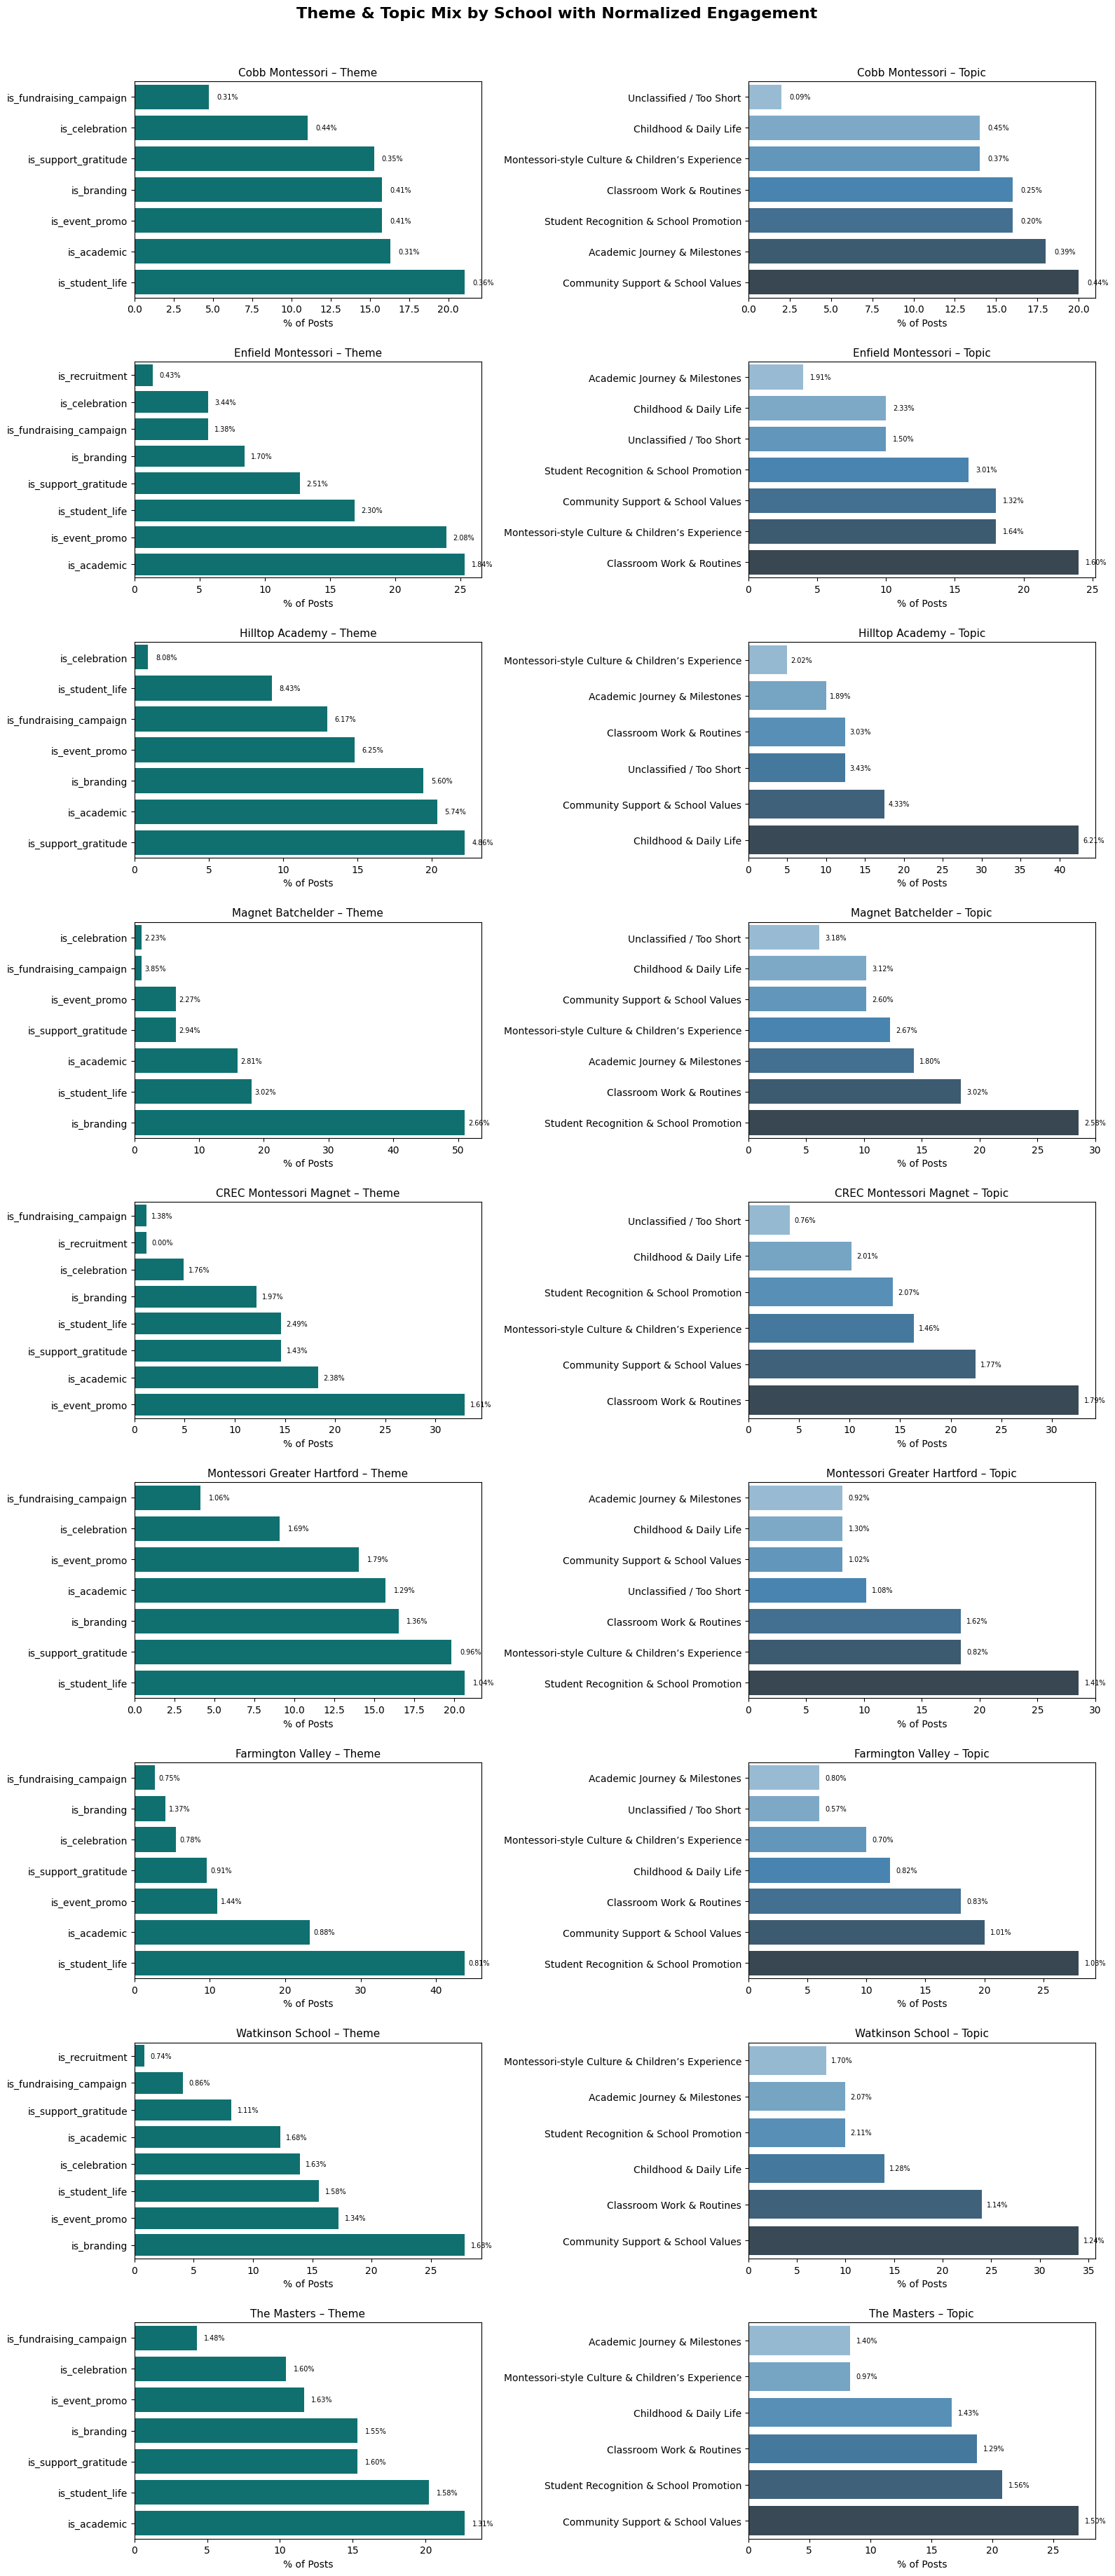

In [63]:
#PLOTTING THEMES AND TOPICS BY SCHOOL AND AVG ENGAGEMENT 

def compute_theme_topic_stats(df, school_name, follower_counts):
    school_df = df[df['school_name'] == school_name].copy()
    school_df['total_engagement'] = school_df['reactions'] + school_df['comments'] + school_df['shares']
    school_df['followers'] = school_df['school_name'].map(follower_counts)
    school_df['normalized_engagement'] = school_df['total_engagement'] / school_df['followers']

    # Theme melt
    theme_cols = [col for col in df.columns if col.startswith("is_")]
    df_theme = school_df.melt(
        id_vars=["normalized_engagement"],
        value_vars=theme_cols,
        var_name="theme",
        value_name="is_present"
    )
    df_theme = df_theme[df_theme["is_present"] == True]

    theme_stats = df_theme.groupby("theme").agg(
        post_count=("is_present", "count"),
        avg_engagement=("normalized_engagement", "mean")
    )
    theme_stats["pct"] = 100 * theme_stats["post_count"] / theme_stats["post_count"].sum()
    theme_stats = theme_stats.sort_values("pct")

    topic_stats = school_df.groupby("lda_topic_label").agg(
        post_count=("post_text", "count"),
        avg_engagement=("normalized_engagement", "mean")
    )
    topic_stats["pct"] = 100 * topic_stats["post_count"] / topic_stats["post_count"].sum()
    topic_stats = topic_stats.sort_values("pct")

    return theme_stats, topic_stats

# List of schools
schools = df['school_name'].unique()

# Create 3x3 subplot grid
fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(16, 36))

for i, school in enumerate(schools):
    theme_stats, topic_stats = compute_theme_topic_stats(df, school, follower_counts)

    # Left = Theme
    ax_theme = axes[i, 0]
    sns.barplot(x="pct", y=theme_stats.index, data=theme_stats, ax=ax_theme, color="teal")
    for j, (pct, eng) in enumerate(zip(theme_stats["pct"], theme_stats["avg_engagement"])):
        ax_theme.text(pct + 0.5, j, f"{eng:.2%}", va="center", fontsize=7)
    ax_theme.set_title(f"{school.replace('_', ' ')} – Theme", fontsize=11)
    ax_theme.set_xlabel("% of Posts")
    ax_theme.set_ylabel("")

    # Right = Topic
    ax_topic = axes[i, 1]
    sns.barplot(x="pct", y=topic_stats.index, data=topic_stats, ax=ax_topic, palette="Blues_d")
    for j, (pct, eng) in enumerate(zip(topic_stats["pct"], topic_stats["avg_engagement"])):
        ax_topic.text(pct + 0.5, j, f"{eng:.2%}", va="center", fontsize=7)
    ax_topic.set_title(f"{school.replace('_', ' ')} – Topic", fontsize=11)
    ax_topic.set_xlabel("% of Posts")
    ax_topic.set_ylabel("")

# Final layout
plt.tight_layout(h_pad=2)
plt.suptitle("Theme & Topic Mix by School with Normalized Engagement", fontsize=16, weight='bold', y=1.02)
plt.show()


## 📊 Theme & Topic Breakdown by School (with Normalized Engagement)

### 🧠 What We Did

To understand how each school communicates on Facebook, we created a pair of bar charts for each school in our dataset:

- **Left Panel:** % of posts by **Theme**, based on manual content tagging (e.g., `is_academic`, `is_event_promo`, `is_student_life`, etc.)
- **Right Panel:** % of posts by **Topic**, based on **Latent Dirichlet Allocation (LDA)** topic modeling of the post text (e.g., *Montessori Culture & Children’s Experience*, *Classroom Work & Routines*, etc.)

Each bar also includes:
- The **percentage** of total posts for that school within the theme/topic
- The **average normalized engagement rate** (likes + comments + shares, divided by that school's follower count)

### 📐 What the Numbers Mean

- **Bar Length (%):** How much each theme or topic contributes to the school’s overall posting mix
- **Annotation (Engagement %):** How engaging that content was on average relative to the school’s audience size

### 🔍 Insights by School

- **Hilltop Academy** is the most balanced in terms of content type and shows high engagement especially on *student life* and *community support* themes.
- **Cobb Montessori** posts heavily about *academic milestones* and *Montessori identity*, with engagement particularly high in *community-focused* content.
- **Watkinson School** focuses more on *branding* and *student celebration*, but engagement levels remain relatively modest across themes.
- **Montessori Greater Hartford** maintains a diversified content mix, with strong emphasis on *support/gratitude* and *student life*.
- **Farmington Valley** has a narrower theme focus with very high % of *academic* and *student life* posts, but engagement appears lower across the board.
- **Enfield Montessori** leans toward *branding* and *event promotion* with decent engagement, though their LDA topic mix is very dispersed.
- **Magnet Batchelder** has the most fragmented theme mix and modest engagement, with only a few standout themes like *student celebration*.
- **The Masters** school shows a strong emphasis on *community values* and *academic messaging*, both of which appear effective in generating engagement.
- **CREC Montessori Magnet** presents a relatively even mix of posts but leans more toward *community support* and *childhood daily life* topics.

### ✅ Next Steps

These visual summaries can guide tailored content strategies by school:
- Double down on themes/topics that drive engagement
- Experiment with underused categories that show promise elsewhere
- Benchmark content frequency and balance vs. high-performing peers


In [64]:
# ANALYSIS OF TOP WORDS PER SCHOOL.
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Load your post dataset
#df = pd.read_csv("facebook_posts_with_themes_and_engagement.csv")

# Define stopwords
custom_stopwords = {'today', 'year', 'day', 'make', 'sure', 'great', 'new', 'monday',
                   'come','night', 'week','tonight', 'tomorrow'}
stopwords = ENGLISH_STOP_WORDS.union(custom_stopwords)

# Lemmatization and cleaning function
def lemmatize(text):
    doc = nlp(text.lower())
    return [
        token.lemma_ for token in doc
        if token.is_alpha and token.lemma_ not in stopwords and len(token.lemma_) > 2
    ]

# Compute top 15 lemmatized words per school (all posts)
top_words_all_posts = {}
for school, group in df.groupby('school_name'):
    all_words = []
    for post in group['post_text'].dropna():
        all_words.extend(lemmatize(post))
    word_counts = Counter(all_words)
    top_words_all_posts[school] = dict(word_counts.most_common(15))

# Print results
for school, words in top_words_all_posts.items():
    print(f"{school} : {', '.join(words.keys())}")

CREC_Montessori_Magnet : school, montessori, thank, art, spirit, love, check, visit, family, connecticut, order, staff, complete, email, center
Cobb_Montessori : cobb, school, student, thisiscobb, class, head, way, community, share, proud, graduate, thank, lead, elementary, fun
Enfield_Montessori : child, thank, fun, time, write, learn, beautiful, student, support, lesson, buda, montessori, chiaravalle, amazing, anniversary
Farmington_Valley : student, school, elementary, middle, work, toddler, class, low, fun, thank, fvam, primary, upper, wonderful, friend
Hilltop_Academy : school, learn, hilltop, support, academy, hilltopheroe, share, love, child, hilltopacademy, individualizedlearne, grateful, visit, independentschool, thank
Magnet_Batchelder : mmbgrowingandglowe, wearehps, student, work, montessori, upper, elementary, class, number, primary, batchelder, attendance, grader, earth, happy
Montessori_Greater_Hartford : msgh, child, student, family, love, thank, celebrate, learn, adoles

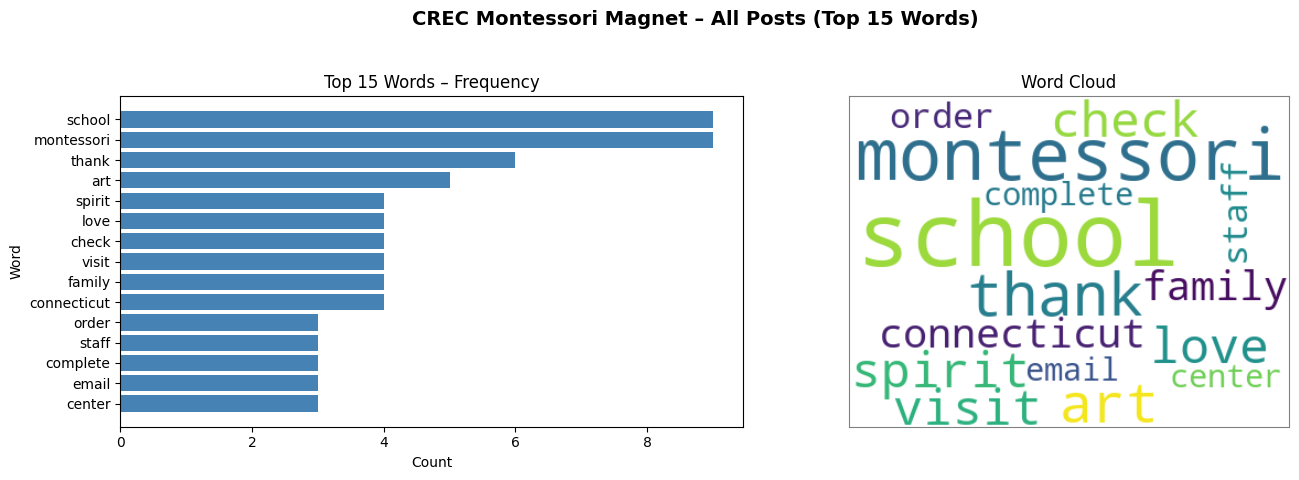

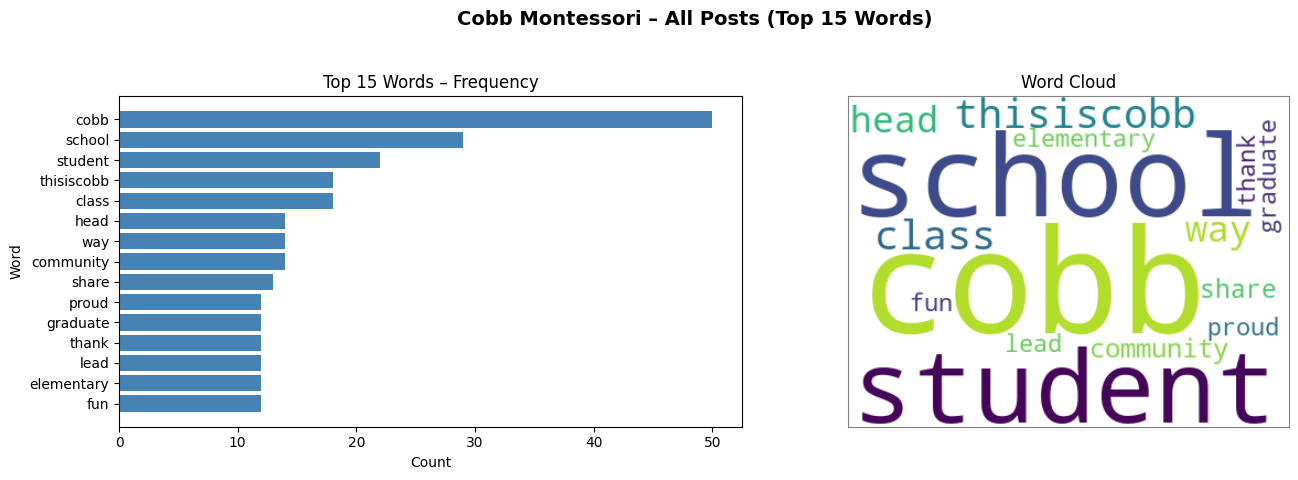

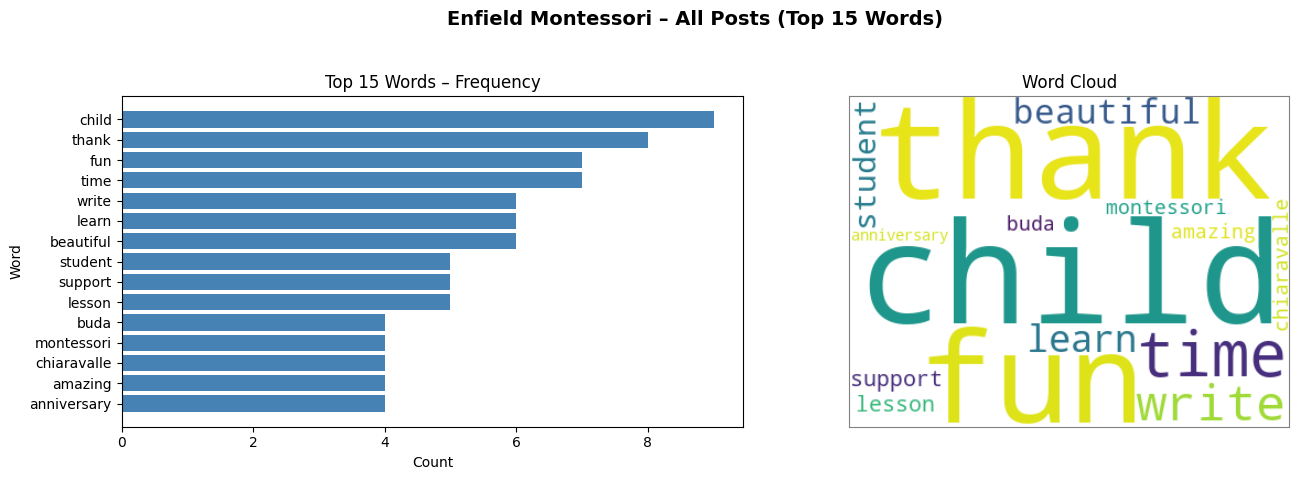

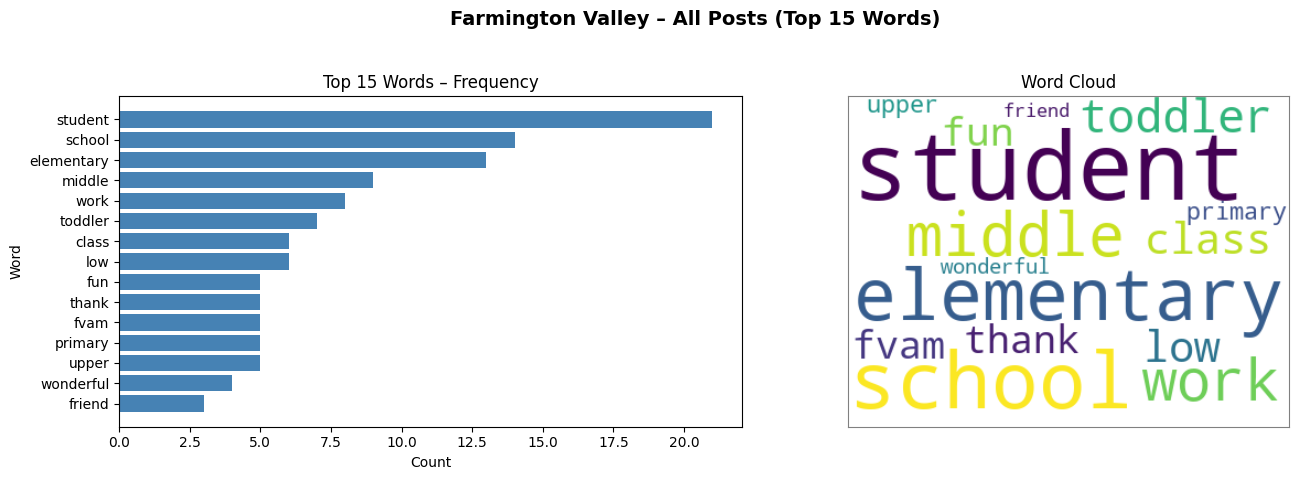

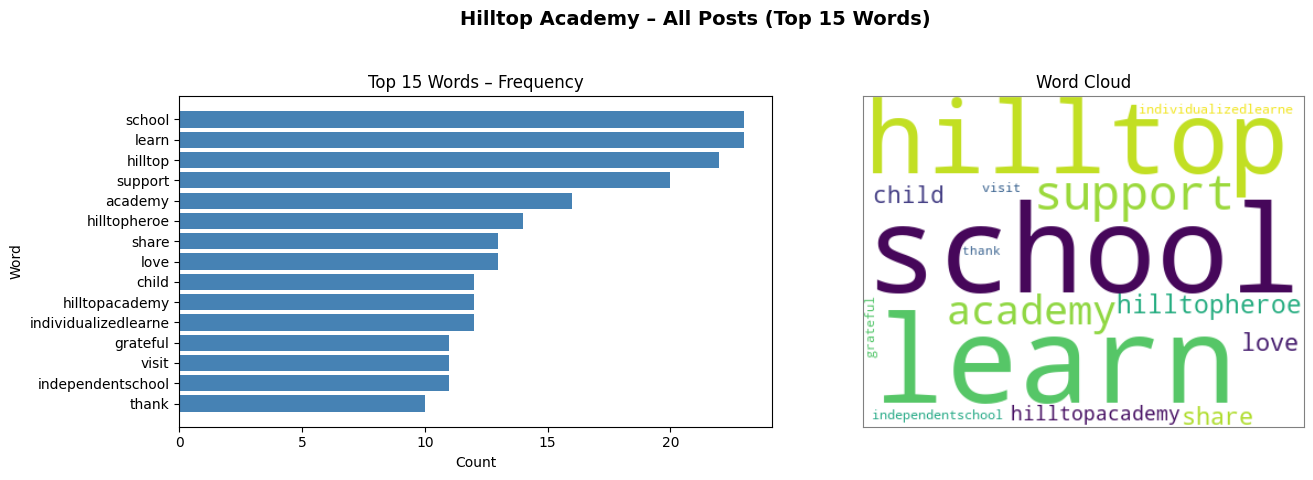

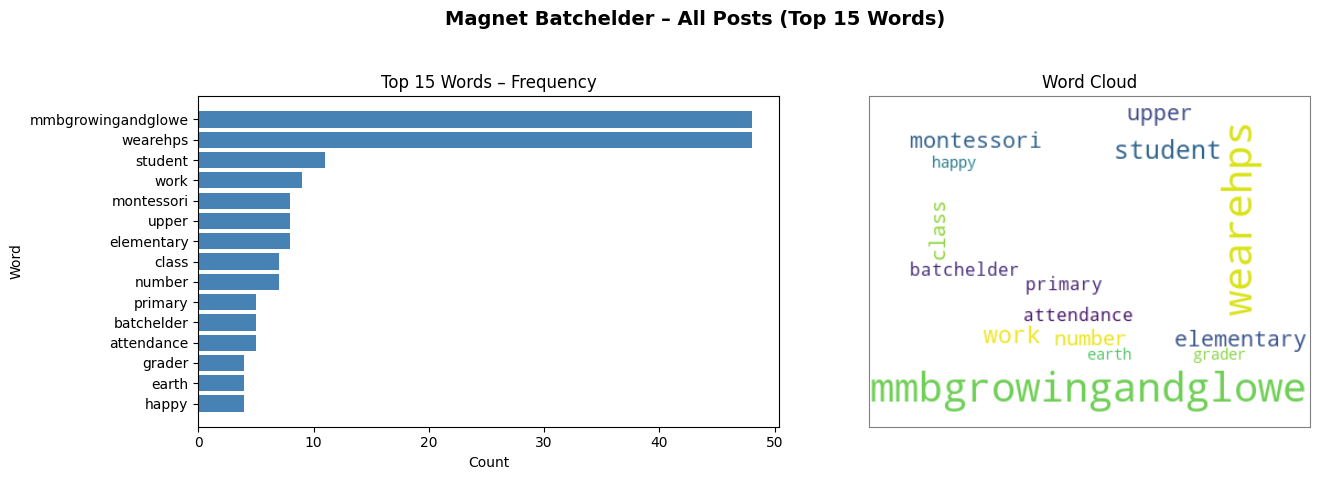

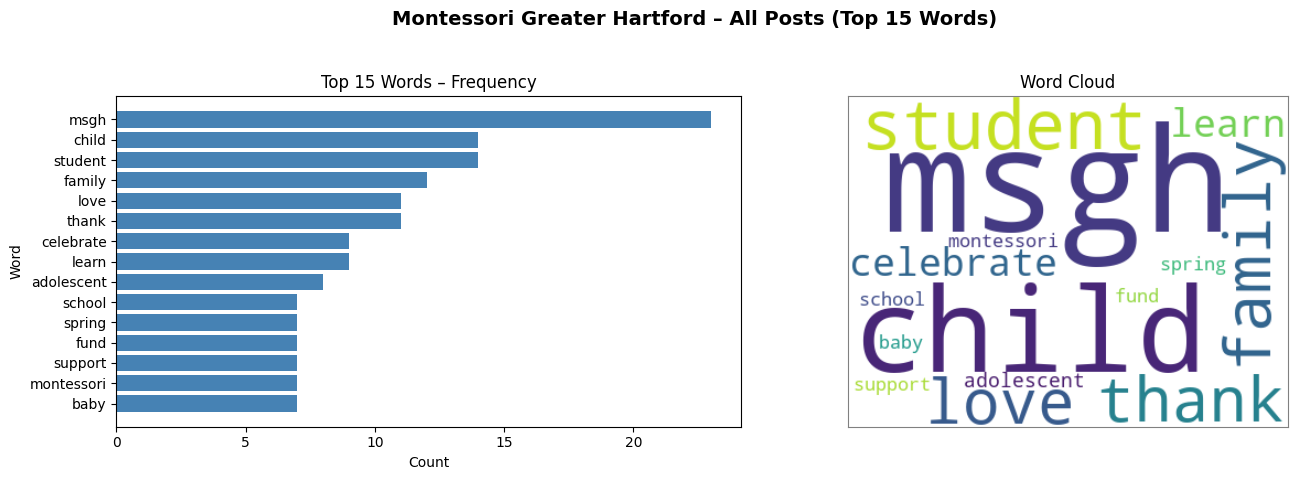

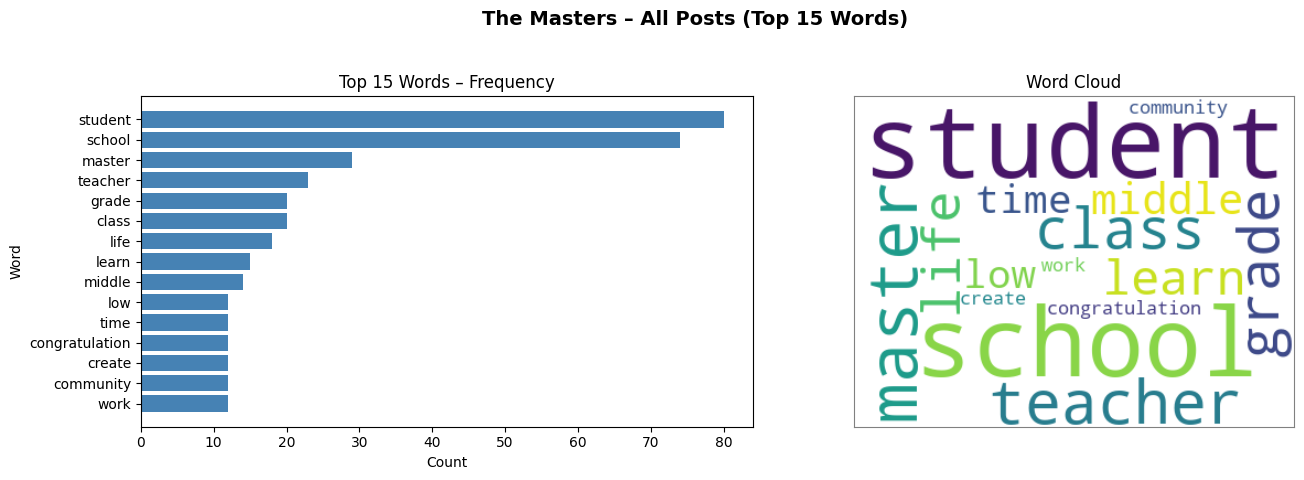

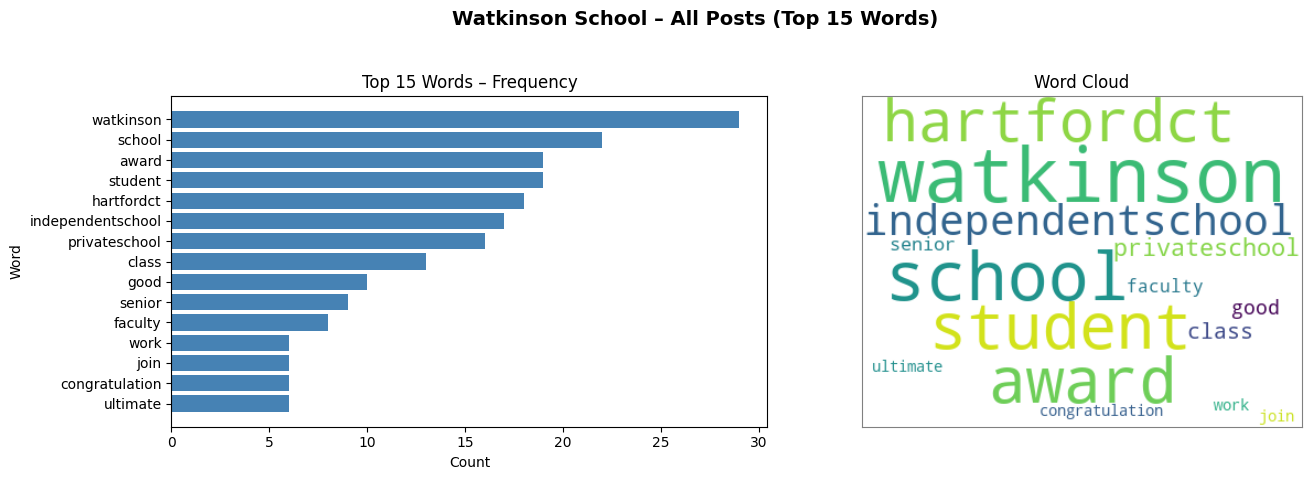

In [65]:
# Visualization loop
from wordcloud import WordCloud
for school, word_dict in top_words_all_posts.items():
    words = list(word_dict.keys())
    freqs = list(word_dict.values())

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"{school.replace('_', ' ')} – All Posts (Top 15 Words)", fontsize=14, weight='bold')

    # Bar chart
    axs[0].barh(words[::-1], freqs[::-1], color='steelblue')
    axs[0].set_title("Top 15 Words – Frequency")
    axs[0].set_xlabel("Count")
    axs[0].set_ylabel("Word")

    # Word cloud with frame
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(word_dict)
    axs[1].imshow(wordcloud, interpolation='bilinear')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    for spine in axs[1].spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
    axs[1].set_title("Word Cloud")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine lemmatized post text by school
school_docs = {}
for school, group in df.groupby('school_name'):
    all_words = []
    for post in group['post_text'].dropna():
        all_words.extend(lemmatize(post))
    school_docs[school] = ' '.join(all_words)

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(stop_words=list(stopwords), max_features=1000)
tfidf_matrix = vectorizer.fit_transform(school_docs.values())

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=school_docs.keys(), columns=vectorizer.get_feature_names_out())

# Extract top N (e.g., 15) unique words per school by TF-IDF score
top_tfidf_per_school = {
    school: tfidf_df.loc[school].sort_values(ascending=False).head(15)
    for school in tfidf_df.index
}

# Print results
for school, series in top_tfidf_per_school.items():
    print(f"\n📌 {school}")
    for word, score in series.items():
        print(f"→ {word} (TF-IDF: {score:.4f})")


📌 CREC_Montessori_Magnet
→ montessori (TF-IDF: 0.3589)
→ school (TF-IDF: 0.2376)
→ douglas (TF-IDF: 0.2066)
→ art (TF-IDF: 0.1614)
→ check (TF-IDF: 0.1595)
→ thank (TF-IDF: 0.1584)
→ email (TF-IDF: 0.1517)
→ complete (TF-IDF: 0.1517)
→ public (TF-IDF: 0.1517)
→ connecticut (TF-IDF: 0.1432)
→ spirit (TF-IDF: 0.1432)
→ market (TF-IDF: 0.1378)
→ parkville (TF-IDF: 0.1378)
→ order (TF-IDF: 0.1196)
→ staff (TF-IDF: 0.1196)

📌 Cobb_Montessori
→ cobb (TF-IDF: 0.6299)
→ thisiscobb (TF-IDF: 0.2268)
→ school (TF-IDF: 0.1400)
→ class (TF-IDF: 0.1063)
→ student (TF-IDF: 0.1062)
→ head (TF-IDF: 0.1021)
→ cobbschool (TF-IDF: 0.1008)
→ graduate (TF-IDF: 0.0981)
→ community (TF-IDF: 0.0917)
→ way (TF-IDF: 0.0917)
→ cobbalum (TF-IDF: 0.0882)
→ lead (TF-IDF: 0.0875)
→ summer (TF-IDF: 0.0851)
→ spotlight (TF-IDF: 0.0851)
→ toddler (TF-IDF: 0.0817)

📌 Enfield_Montessori
→ child (TF-IDF: 0.2330)
→ chiaravalle (TF-IDF: 0.2209)
→ buda (TF-IDF: 0.2209)
→ time (TF-IDF: 0.2010)
→ write (TF-IDF: 0.1918)
→ beaut

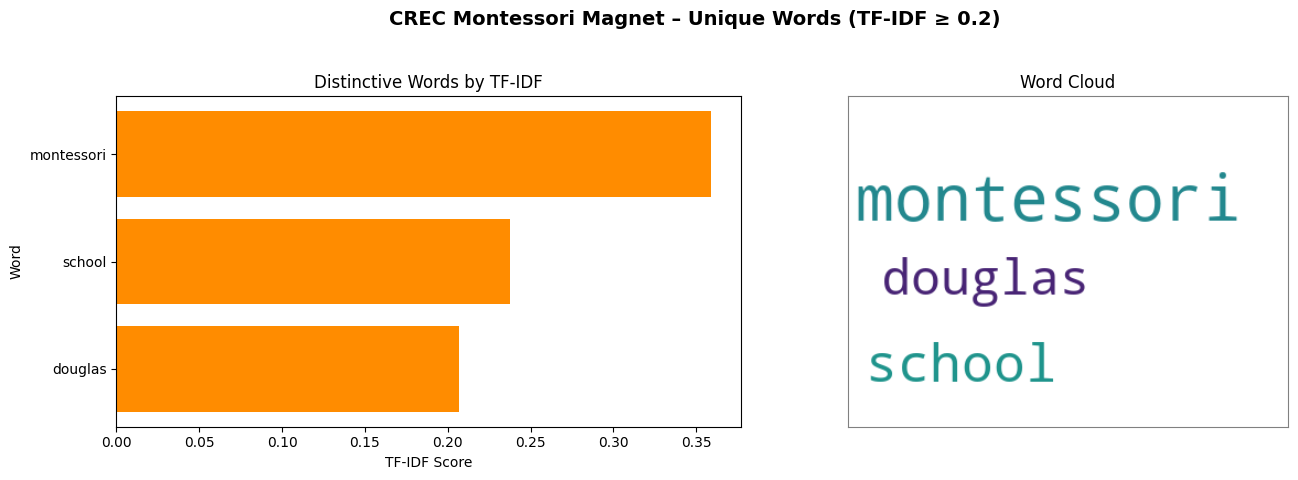

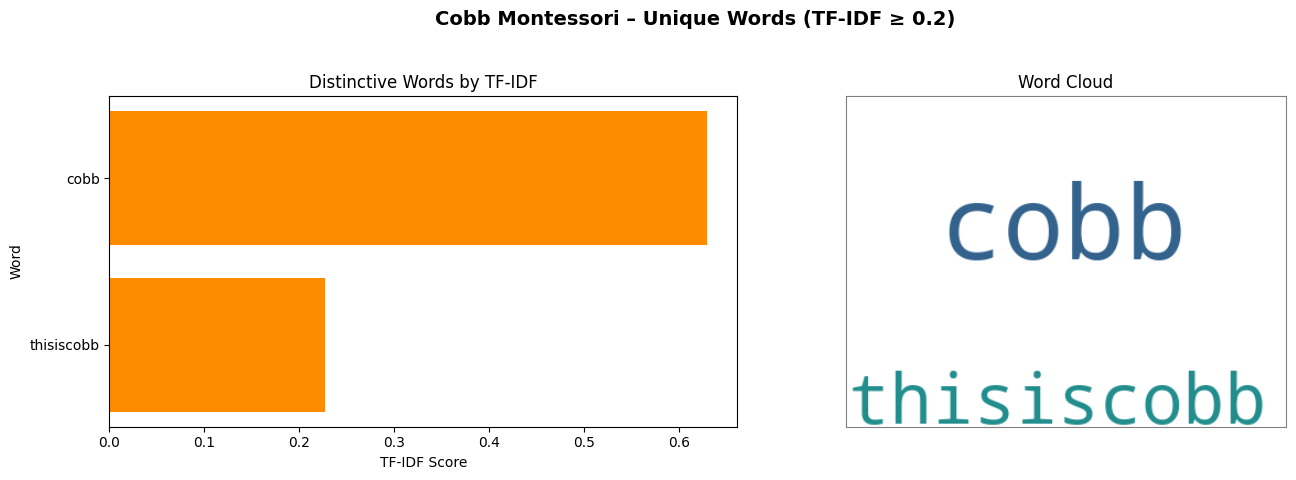

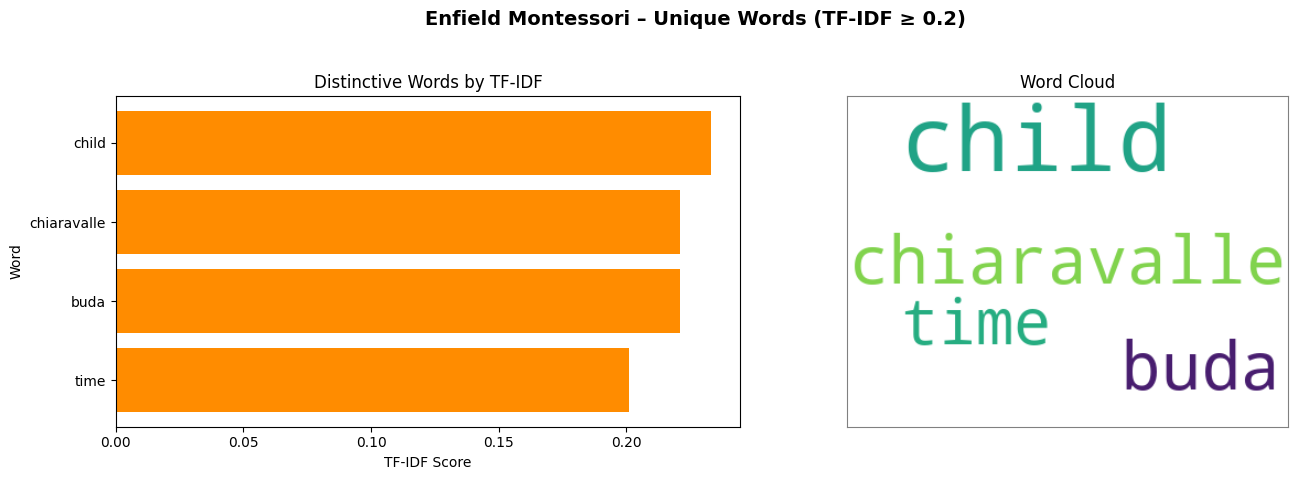

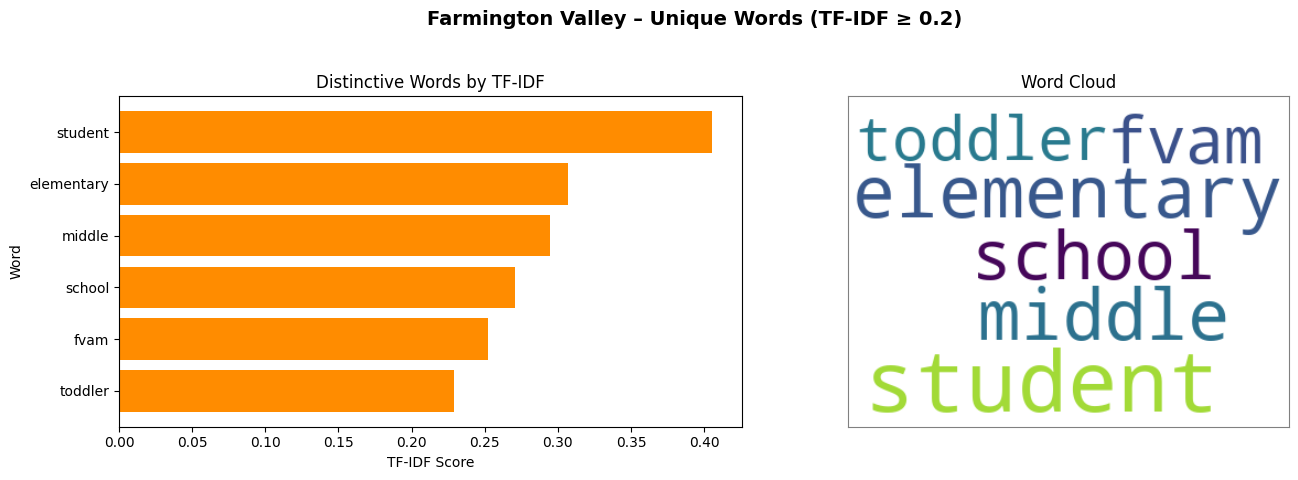

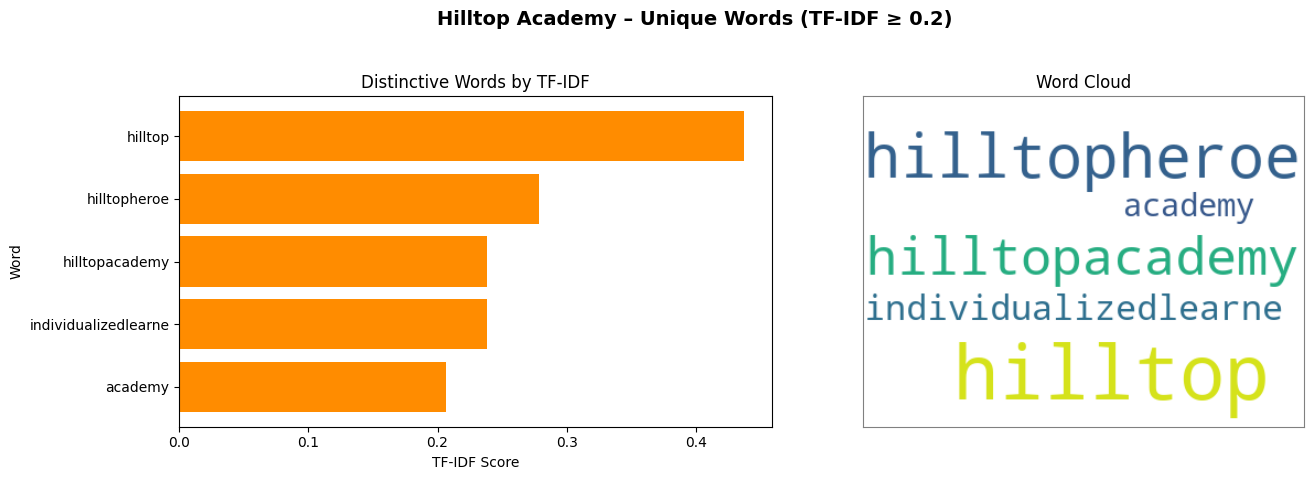

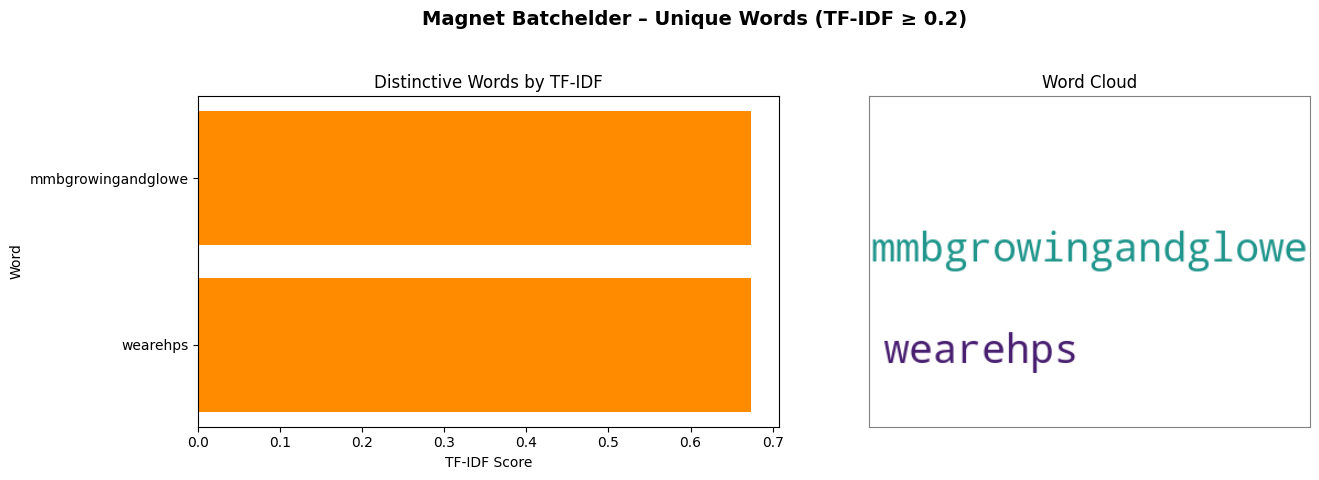

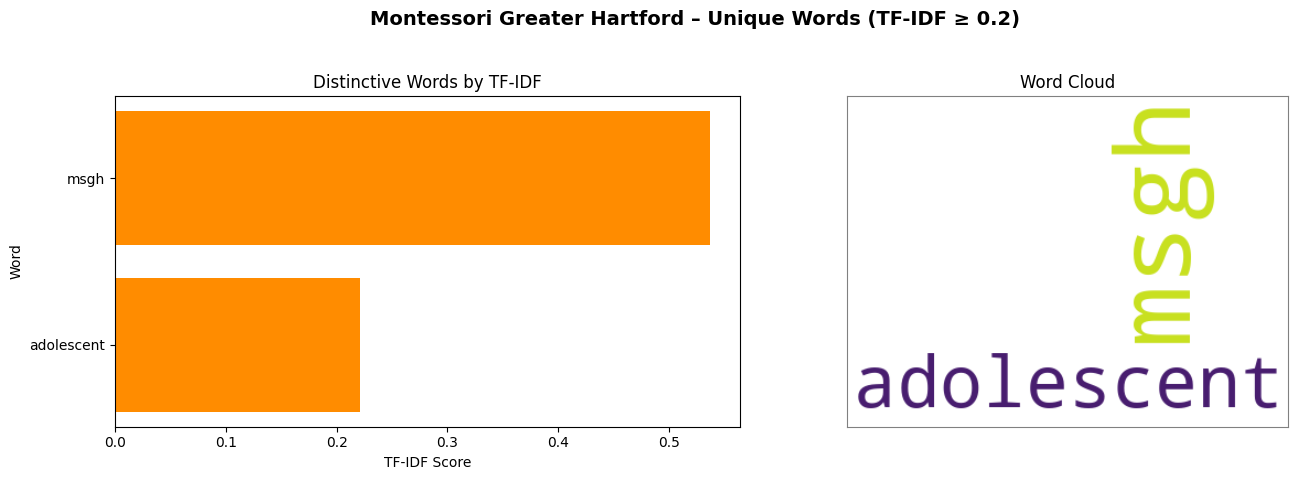

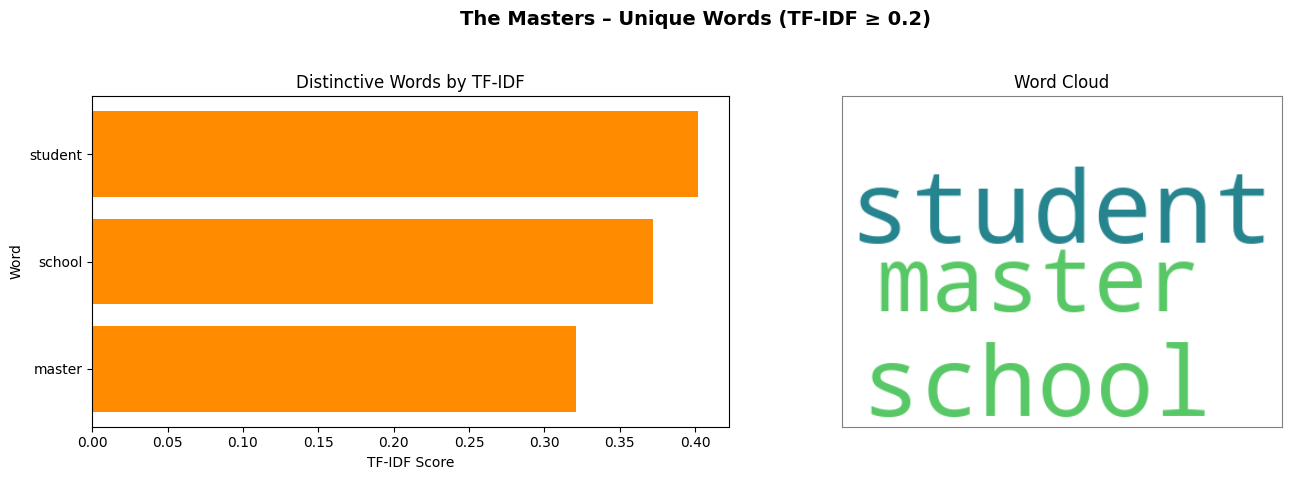

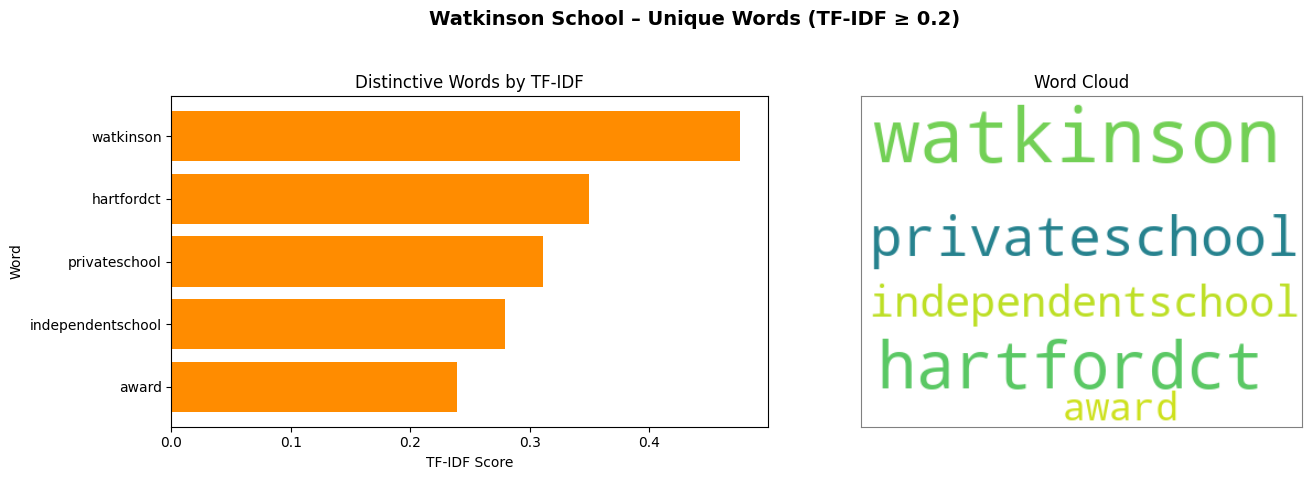

In [67]:
# Step 3: Extract top 15 words per school and visualize only those above threshold
THRESHOLD = 0.2
top_tfidf_per_school = {
    school: tfidf_df.loc[school].sort_values(ascending=False).head(15)
    for school in tfidf_df.index
}

for school, series in top_tfidf_per_school.items():
    filtered = series[series >= THRESHOLD]
    if filtered.empty:
        continue  # Skip schools with no strongly distinctive words

    words = list(filtered.index)
    freqs = list(filtered.values)

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"{school.replace('_', ' ')} – Unique Words (TF-IDF ≥ {THRESHOLD})", fontsize=14, weight='bold')

    # Bar chart
    axs[0].barh(words[::-1], freqs[::-1], color='darkorange')
    axs[0].set_title("Distinctive Words by TF-IDF")
    axs[0].set_xlabel("TF-IDF Score")
    axs[0].set_ylabel("Word")

    # Word cloud with frame
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(filtered.to_dict())
    axs[1].imshow(wordcloud, interpolation='bilinear')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    for spine in axs[1].spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
    axs[1].set_title("Word Cloud")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 📘 School Vocabulary Analysis – All Facebook Posts

This analysis examines how each school uses language in its Facebook posts. We applied two complementary methods to understand both the **most frequent words** and the **most distinctive words** used by each school across all available posts.

---

### 🔹 Phase 1: Top 15 Most Frequent Words per School

We first lemmatized and cleaned all post text, then calculated the **top 15 most common words** used by each school. This helped us understand the **overall messaging focus and tone** of each institution.

#### 🧠 Key Observations:

- **Name-focused schools** (e.g., `cobb`, `watkinson`, `msgh`, `hilltop`, `mmbgrowingandglowe`, `master`) prominently include branded terms or internal hashtags, signaling strong **institutional identity**.
- **Student- and family-centered language** appears consistently across many schools (`student`, `child`, `class`, `family`, `congratulation`).
- **Cultural and emotional terms** like `love`, `support`, `spirit`, `grateful`, and `happy` suggest efforts to humanize their brand presence.
- **Event-related and CTA words** like `visit`, `check`, `order`, and `email` reflect common operational content.

This method captures what each school says most often — but not necessarily what makes their language **distinctive**.

---

### 🔹 Phase 2: TF-IDF Distinctiveness Analysis (Threshold: ≥ 0.2)

We then applied **TF-IDF (Term Frequency–Inverse Document Frequency)** to identify the words that are **most distinctive** to each school compared to all others. This reveals each school's **linguistic fingerprint** — even for less frequently used terms.

We filtered results to include only words with **TF-IDF ≥ 0.2**, ensuring high confidence in uniqueness.

#### 🧠 Standout Highlights:

- **Cobb Montessori**: Strongest brand identity using terms like `cobb`, `thisiscobb`, clearly branding their communication strategy.  
  *TF-IDF ≥ 0.2:* `cobb (0.63)`, `thisiscobb (0.23)`

- **Hilltop Academy**: Highly distinctive internal vocabulary and mission-driven framing through words like `hilltopheroe`, `individualizedlearne`, `alternativeeducation`.  
  *TF-IDF ≥ 0.2:* `hilltop (0.44)`, `hilltopheroe (0.28)`, `hilltopacademy (0.24)`, `individualizedlearne (0.24)`, `academy (0.21)`

- **Magnet Batchelder**: Dominant district-level campaigns and hashtags (`wearehps`, `mmbgrowingandglowe`) uniquely define their voice.  
  *TF-IDF ≥ 0.2:* `wearehps (0.67)`, `mmbgrowingandglowe (0.67)`

- **Montessori Greater Hartford**: Warm, emotional language reflects early-childhood focus and community connection, with standout terms like `msgh`, `adolescent`, `baby`.  
  *TF-IDF ≥ 0.2:* `msgh (0.53)`, `adolescent (0.22)`

- **Watkinson School**: Messaging emphasizes institutional prestige and private school positioning through terms like `watkinson`, `hartfordct`, `privateschool`.  
  *TF-IDF ≥ 0.2:* `watkinson (0.47)`, `hartfordct (0.35)`, `privateschool (0.31)`, `award (0.27)`, `independentschool (0.28)`

- **Enfield Montessori**: Communicates a nurturing tone with uniquely personal and celebratory terms like `sister`, `chiaravalle`, `congratulation`.  
  *TF-IDF ≥ 0.2:* `sister (0.22)`, `chiaravalle (0.22)`

- **Farmington Valley**: Clearly differentiates through terms tied to academic stages and program structure like `fvam`, `toddler`, `middle`, `elementary`.  
  *TF-IDF ≥ 0.2:* `student (0.41)`, `elementary (0.34)`, `middle (0.26)`, `school (0.27)`, `fvam (0.25)`, `toddler (0.23)`

- **CREC Montessori Magnet**: Language skews operational and public-facing, with terms like `check`, `complete`, `email`, `douglas`, aligning with a broader organizational tone.  
  *TF-IDF ≥ 0.2:* `montessori (0.35)`, `school (0.23)`, `douglas (0.20)`

- **The Masters School**: Balances spiritual identity and academic progression, with distinct terms like `master`, `god`, `teacher`, and `experience`.  
  *TF-IDF ≥ 0.2:* `student, school, master`

---

### ✅ Interpretation

The words above aren't just frequent — they are **disproportionately associated** with one school over others. They represent:
- **Brand voice**
- **Program identity**
- **Cultural traits**
- **Community positioning**

For Ahsas School, these findings highlight **positioning whitespace** and potential **differentiation opportunities**.

---

### ✅ Next Step

Visualize each school on a **2D PCA plot**, using these TF-IDF vectors to map out the **semantic similarity space** between them.
.


/var/folders/9z/9j1rdhn164b4l3msjpgj1zd40000gn/T/ipykernel_48816/3995431118.py:31: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


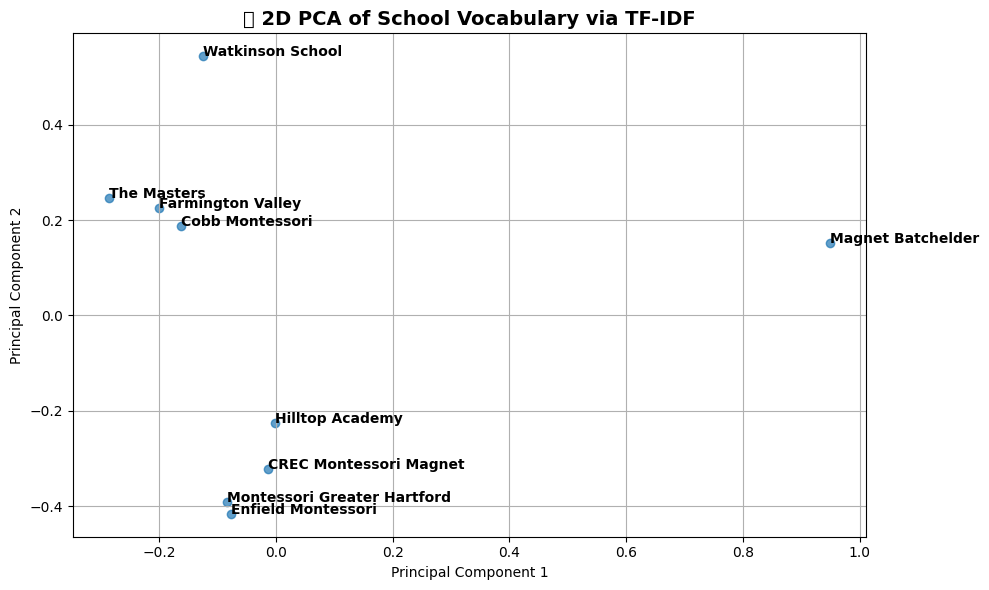

In [68]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_df)

# Prepare top word labels
top_words_per_school = {
    'CREC_Montessori_Magnet': ['school', 'montessori', 'thank', 'art', 'spirit', 'love', 'check', 'visit', 'family', 'connecticut', 'order', 'staff', 'complete', 'email', 'center'],
    'Cobb_Montessori': ['cobb', 'school', 'student', 'thisiscobb', 'class', 'head', 'way', 'community', 'share', 'proud', 'graduate', 'thank', 'lead', 'elementary', 'fun'],
    'Enfield_Montessori': ['school', 'thank', 'student', 'child', 'happy', 'beautiful', 'congratulation', 'little', 'friday', 'sister', 'chiaravalle', 'class', 'sixth', 'enfield', 'enjoy'],
    'Farmington_Valley': ['student', 'school', 'elementary', 'middle', 'work', 'toddler', 'class', 'low', 'fun', 'thank', 'fvam', 'primary', 'upper', 'wonderful', 'friend'],
    'Hilltop_Academy': ['school', 'learn', 'hilltop', 'support', 'academy', 'hilltopheroe', 'share', 'love', 'child', 'hilltopacademy', 'individualizedlearne', 'grateful', 'visit', 'independentschool', 'thank'],
    'Magnet_Batchelder': ['mmbgrowingandglowe', 'wearehps', 'student', 'work', 'montessori', 'upper', 'elementary', 'class', 'number', 'primary', 'batchelder', 'attendance', 'grader', 'earth', 'happy'],
    'Montessori_Greater_Hartford': ['msgh', 'child', 'student', 'family', 'love', 'thank', 'celebrate', 'learn', 'adolescent', 'school', 'spring', 'fund', 'support', 'montessori', 'baby'],
    'Watkinson_School': ['watkinson', 'school', 'award', 'student', 'hartfordct', 'independentschool', 'privateschool', 'class', 'good', 'senior', 'faculty', 'work', 'join', 'congratulation', 'ultimate']
}

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)

for i, school in enumerate(tfidf_df.index):
    plt.text(X_pca[i, 0], X_pca[i, 1], school.replace('_', ' '), fontsize=10, fontweight='bold')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("🧭 2D PCA of School Vocabulary via TF-IDF", fontsize=14, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

## 🧭 2D PCA of School Vocabulary via TF-IDF

### 📌 What This Is
This PCA scatterplot visualizes how each school distinguishes itself through language on Facebook. Using **TF-IDF (Term Frequency–Inverse Document Frequency)**, we computed the most representative words used in all posts for each school. Then we used **PCA (Principal Component Analysis)** to reduce the high-dimensional word data into two components, allowing us to map schools based on **semantic similarity**.

Each dot represents a school. The closer two dots are, the more similar their word usage patterns. Greater separation suggests more distinct vocabulary or tone.

---

### 🧮 What the PCA Components Represent

- **Principal Component 1 (PC1)**: Captures the primary axis of vocabulary contrast. It appears to reflect how heavily schools lean into **branding/campaign language** versus general educational content.
  
- **Principal Component 2 (PC2)**: Reflects the second most important difference. This may align with **formality**, **emotional tone**, or **audience orientation** (e.g., parent-facing vs. institution-facing).

Note: These components are abstract — we interpret them based on relative positioning and contributing word weights.

---

### 🧠 Key Observations

- **Hilltop Academy** and **Watkinson School** cluster at the top, suggesting similar focus on **academic values**, **school identity**, and institutional terms like `academy`, `independentschool`, `faculty`.

- **The Master's School** now appears clearly on the lower-left, closer to **Enfield** and **Cobb Montessori**, but slightly apart — likely due to its distinct use of **spiritual** and **life-purpose terms** (e.g., `master`, `god`, `life`, `experience`) paired with a structured academic tone.

- **Magnet Batchelder** remains the most isolated in the semantic space, dominated by its internal branding hashtags like `wearehps`, `mmbgrowingandglowe`.

- **CREC Montessori Magnet**, **Montessori Greater Hartford**, and **Farmington Valley** form a center-left cluster with language rooted in **community**, **academics**, and **program structure**.

- **Cobb** and **Enfield Montessori** again sit close to each other, with Enfield emphasizing warmth and student/family tone, and Cobb incorporating more branding (`cobb`, `thisiscobb`).

---

### 🎯 Why This Matters

This PCA map helps visually capture **how linguistically unique or aligned** each school is in its social messaging:

- Schools far apart (like Hilltop vs. Batchelder) likely speak in **very different brand voices**.
- Schools close together (like Cobb and Enfield) may target **similar audiences** or share messaging norms.
- **The Master’s School**, newly added, introduces a different blend — one grounded in **faith-based vocabulary** and **student development**.

For **Ahsas School**, this offers:
- A way to **benchmark** tone and messaging presence
- A guide to identify **underused communication styles**
- Opportunities to differentiate through vocabulary and content framing

In [69]:
#ANALYSIS OF TOP WORDS X SCHOOL ON THEMES BRANDING

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Filter only branding posts
branding_df = df[df['is_branding'] == True].copy()

# Tokenization function
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return [word for word in text.split() if word not in ENGLISH_STOP_WORDS and len(word) > 2]

# Compute top 10 words per school
top_words_branding = {}
for school, group in branding_df.groupby('school_name'):
    all_words = []
    for post in group['post_text'].dropna():
        all_words.extend(tokenize(post))
    word_counts = Counter(all_words)
    top_words_branding[school] = dict(word_counts.most_common(10))

# Print as simple lists
for school, words in top_words_branding.items():
    word_list = list(words.keys())[:10]
    print(f"{school} : {', '.join(word_list)}")

CREC_Montessori_Magnet : montessori, school, thank, public, monday, open, douglas, crec, today, classrooms
Cobb_Montessori : cobb, thisiscobb, class, school, community, year, montessori, way, years, classof
Enfield_Montessori : child, buda, montessori, time, enfield, write, congratulations, scholarship, values, beautiful
Farmington_Valley : school, stcenturymontessori, determination, display, primary, classes, great, soccer, game, upper
Hilltop_Academy : hilltop, learn, support, hilltopheroes, hilltopacademy, wwwhilltopheroesorg, school, academy, independentschool, individualizedlearning
Magnet_Batchelder : mmbgrowingandglowing, wearehps, students, day, montessori, upper, elementary, working, numbers, reading
Montessori_Greater_Hartford : msgh, today, love, fund, montessori, students, childrens, school, sure, make
The_Masters : school, students, masters, student, grade, class, years, teachers, ceremony, god
Watkinson_School : watkinson, hartfordct, independentschool, privateschool, sch

In [70]:
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Define custom stopwords
custom_stopwords = {'today', 'year', 'day', 'make', 'sure', 'great', 'new',
                   'monday'}
stopwords = ENGLISH_STOP_WORDS.union(custom_stopwords)

# Filter for branding posts only
branding_df = df[df['is_branding'] == True].copy()

# Lemmatization + cleaning
def lemmatize(text):
    doc = nlp(text.lower())
    return [
        token.lemma_ for token in doc
        if token.is_alpha and token.lemma_ not in stopwords and len(token.lemma_) > 2
    ]

# Compute top 10 lemmatized words per school
top_words_branding = {}
for school, group in branding_df.groupby('school_name'):
    all_words = []
    for post in group['post_text'].dropna():
        all_words.extend(lemmatize(post))
    word_counts = Counter(all_words)
    top_words_branding[school] = dict(word_counts.most_common(10))

# Print results
for school, words in top_words_branding.items():
    print(f"{school} : {', '.join(words.keys())}")

CREC_Montessori_Magnet : montessori, school, thank, public, walk, share, come, love, open, douglas
Cobb_Montessori : cobb, thisiscobb, class, school, community, student, montessori, way, spirit, bring
Enfield_Montessori : write, child, buda, montessori, time, enfield, congratulation, scholarship, student, value
Farmington_Valley : school, determination, display, primary, class, soccer, game, upper, elementary, middle
Hilltop_Academy : learn, hilltop, support, hilltopheroe, school, academy, hilltopacademy, independentschool, individualizedlearne, visit
Magnet_Batchelder : mmbgrowingandglowe, wearehps, student, work, montessori, upper, elementary, class, number, primary
Montessori_Greater_Hartford : msgh, child, family, love, fund, learn, montessori, student, school, celebrate
The_Masters : school, student, master, grade, life, class, teacher, learn, god, include
Watkinson_School : watkinson, award, school, hartfordct, independentschool, student, privateschool, class, faculty, good


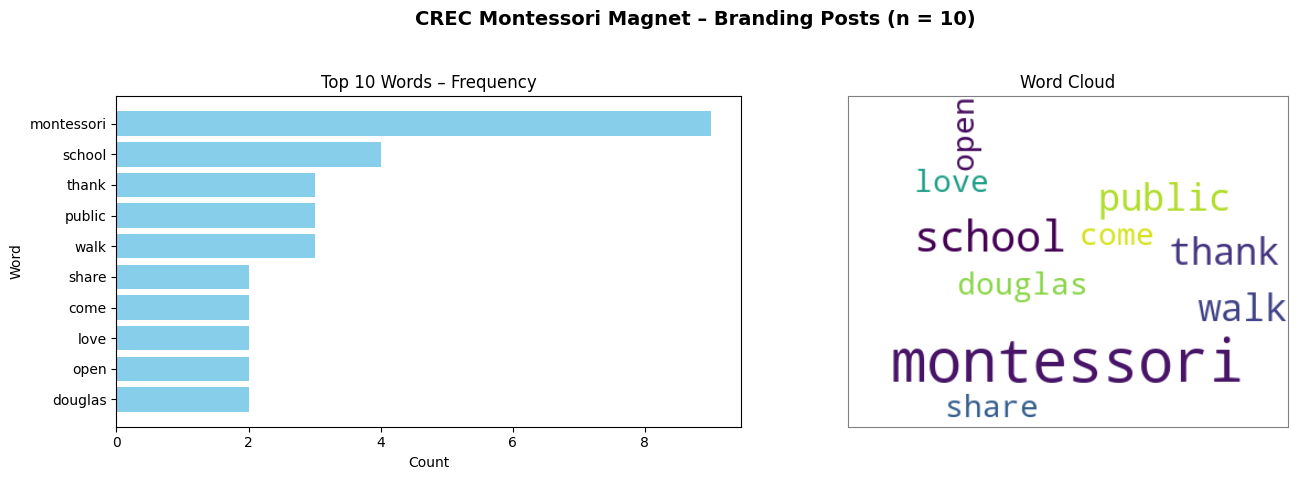

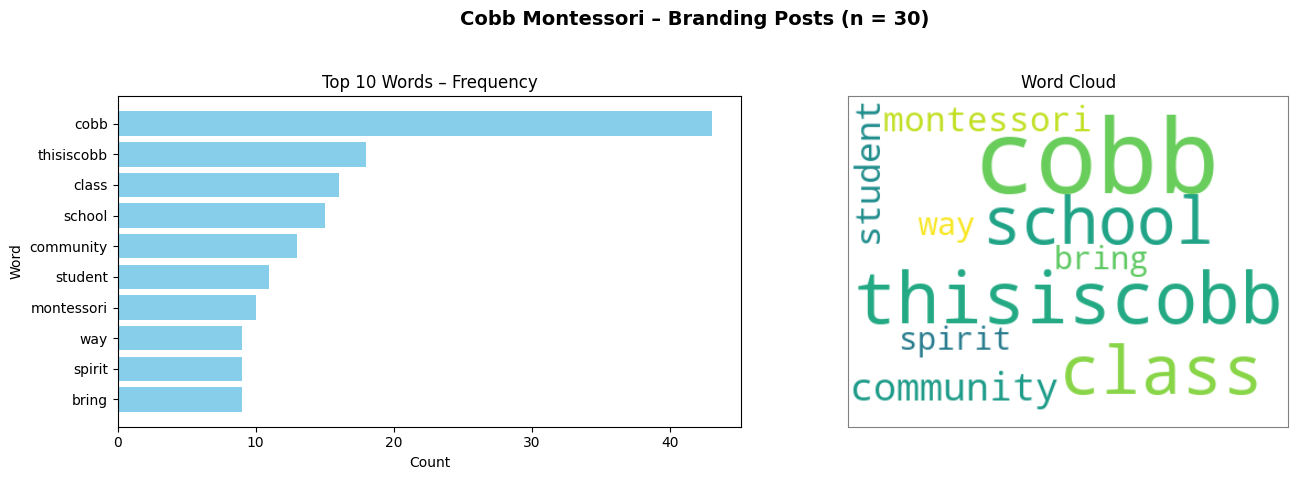

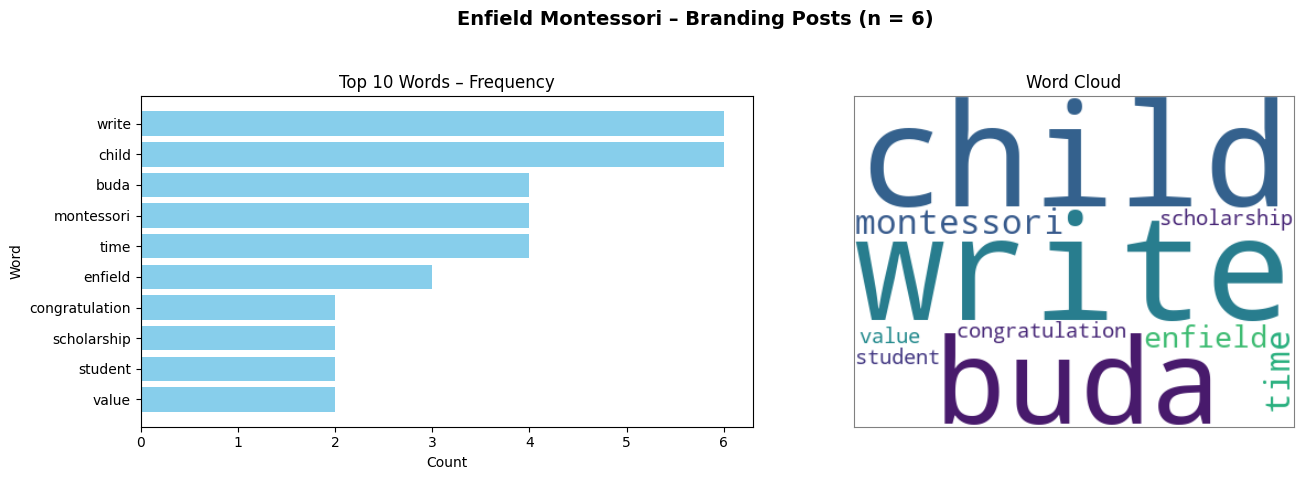

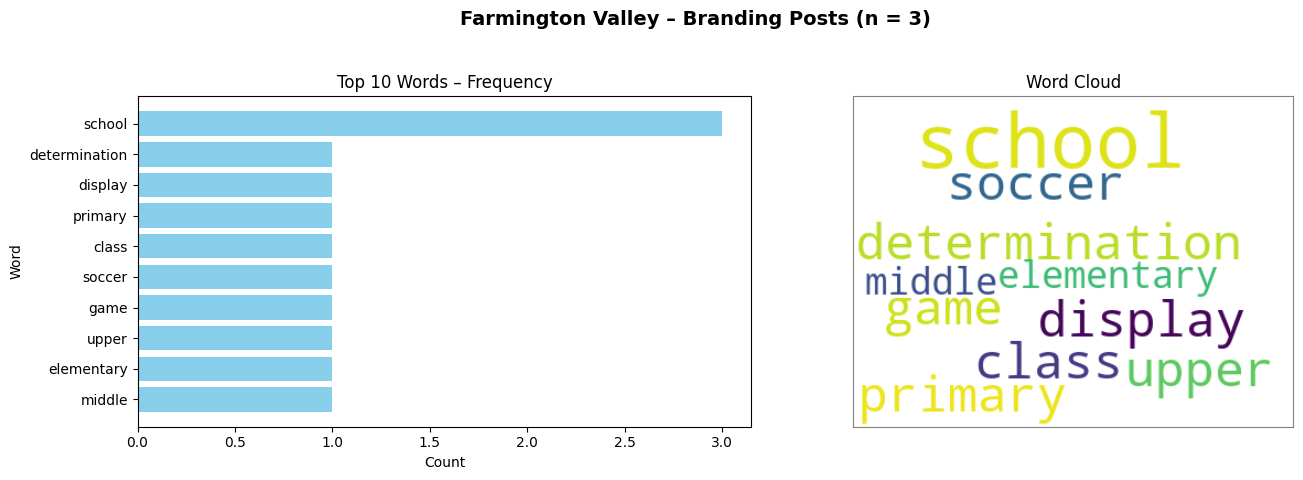

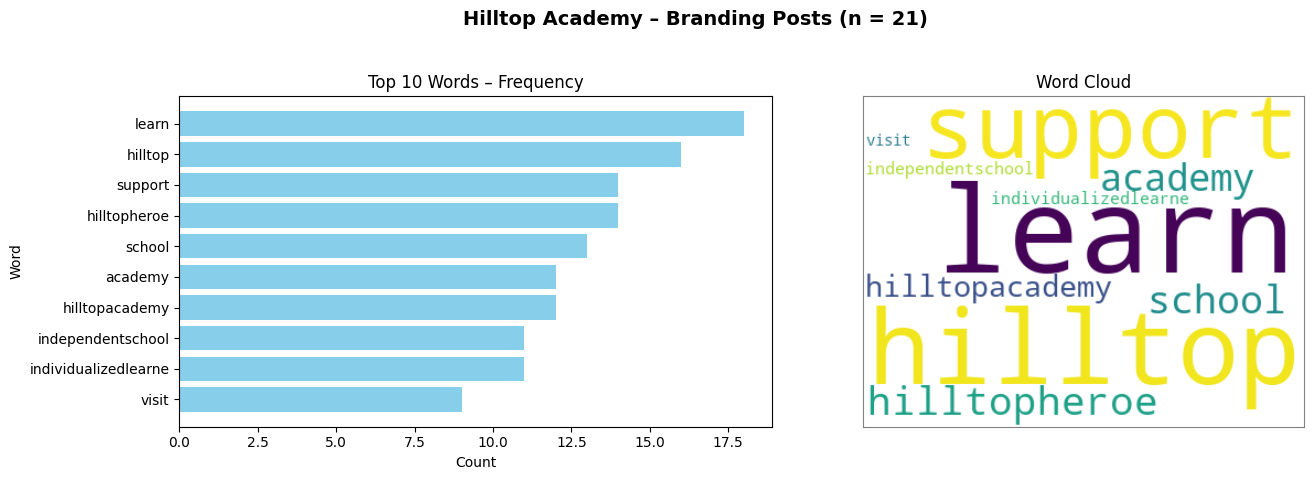

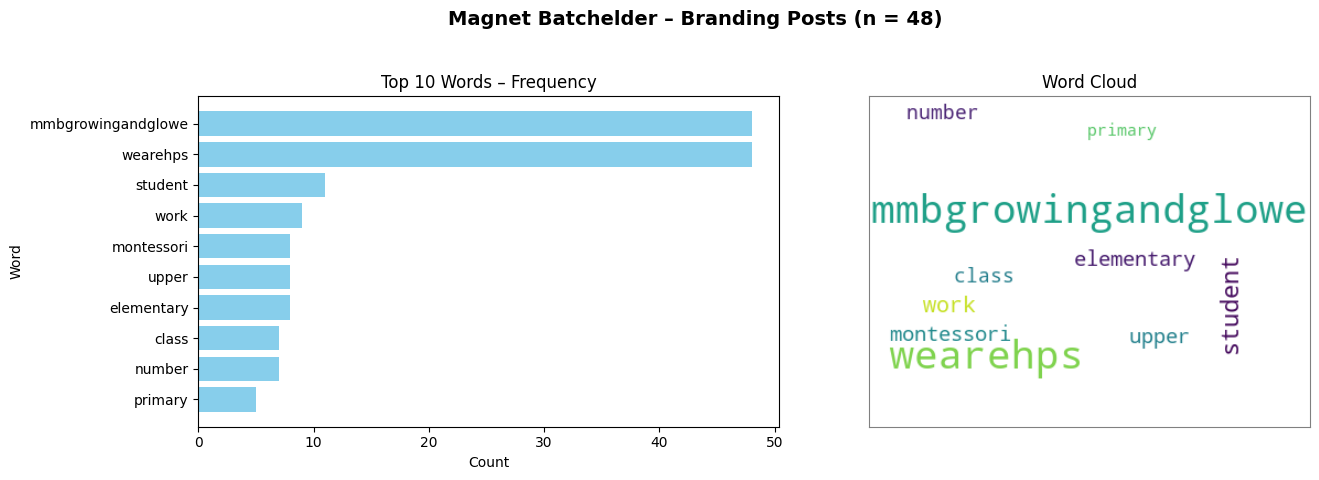

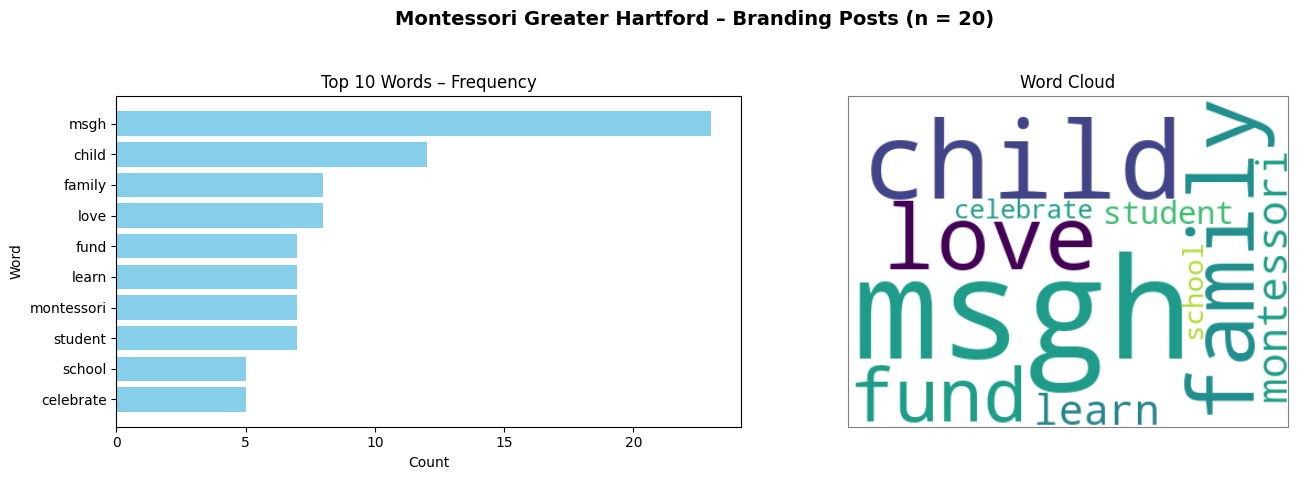

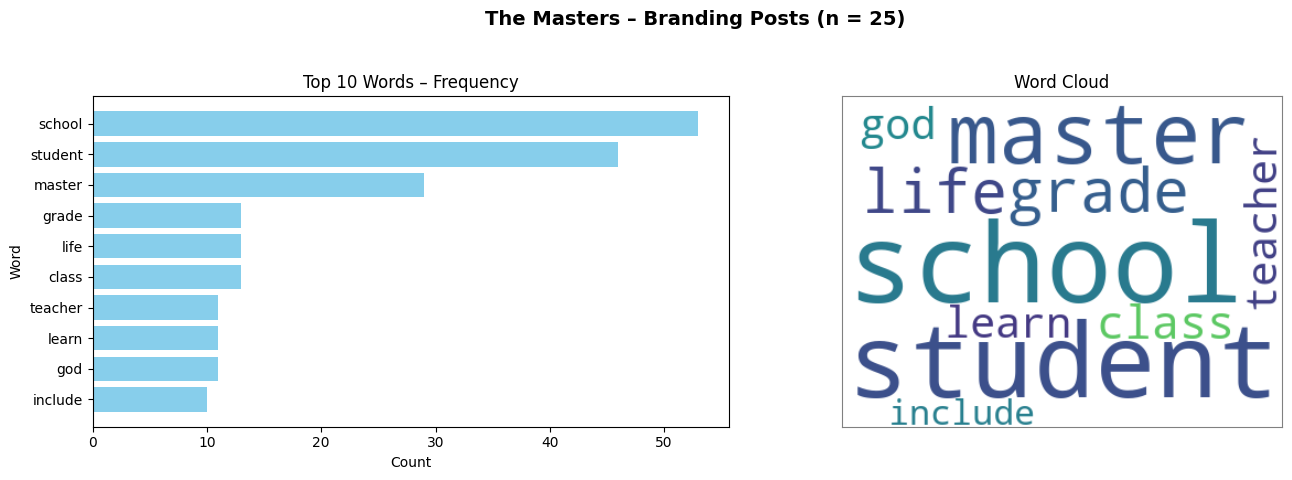

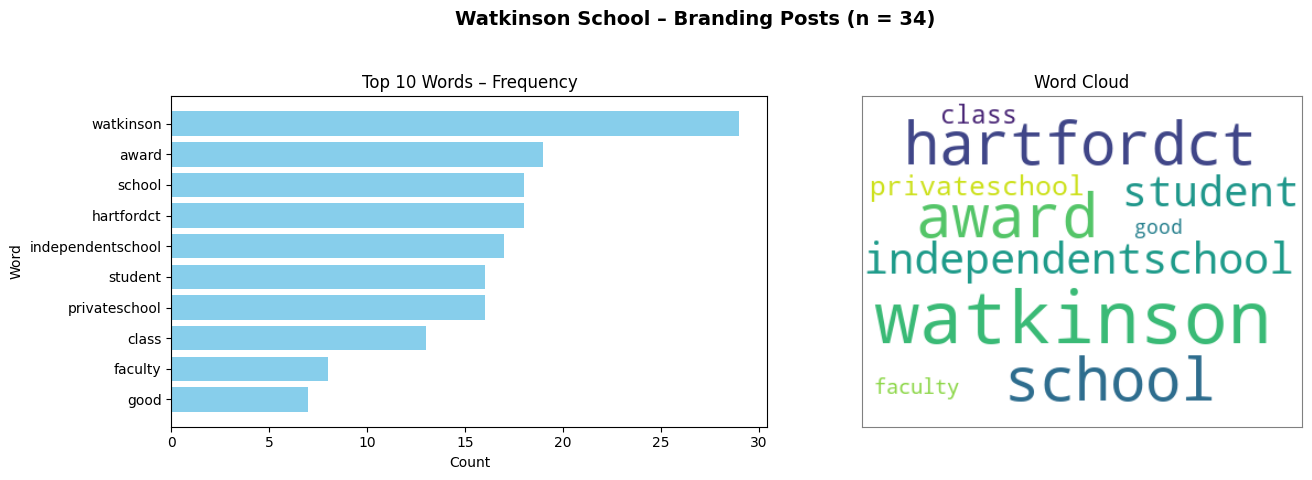

In [71]:
# Visualize: Bar chart + word cloud per school
from wordcloud import WordCloud

for school, word_dict in top_words_branding.items():
    words = list(word_dict.keys())
    freqs = list(word_dict.values())

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    num_posts = len(branding_df[branding_df['school_name'] == school])
    fig.suptitle(f"{school.replace('_', ' ')} – Branding Posts (n = {num_posts})", fontsize=14, weight='bold')


    # Bar chart
    axs[0].barh(words[::-1], freqs[::-1], color='skyblue')
    axs[0].set_title("Top 10 Words – Frequency")
    axs[0].set_xlabel("Count")
    axs[0].set_ylabel("Word")

    # Word cloud
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(word_dict)
    axs[1].imshow(wordcloud, interpolation='bilinear')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].spines['top'].set_visible(True)
    axs[1].spines['bottom'].set_visible(True)
    axs[1].spines['left'].set_visible(True)
    axs[1].spines['right'].set_visible(True)
    axs[1].spines['top'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['right'].set_color('gray')
    axs[1].set_title("Word Cloud")


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 🔷 Branding Theme Analysis – Top Words by School

We analyzed the most frequent lemmatized words used in branding-related Facebook posts (`is_branding == True`) across 9 schools. The results reveal distinct communication styles and identity signals embedded in each school’s branding narrative.

### 🧠 Key Insights:

- **Name-Driven Branding:**  
  Schools like **Cobb Montessori**, **Hilltop Academy**, and **Watkinson School** heavily use self-referential terms such as `cobb`, `hilltop`, `watkinson`, `thisiscobb`, `hilltopheroes`, and school hashtags. This reflects a deliberate emphasis on **institutional identity** and **community reinforcement** through name visibility.

- **Emotional and Relational Voice:**  
  **Montessori Greater Hartford**, **Enfield Montessori**, and **The Masters** stand out for emotionally resonant and value-driven language, including words like `love`, `family`, `student`, `child`, `include`, and `celebrate`. This branding leans into **relationships, faith, and whole-child development**.

- **Administrative / Informational Tone:**  
  **CREC Montessori Magnet** and **Magnet Batchelder** show more formal or logistical language: `public`, `monday`, `open`, `thank`, `crec`, `wearehps`. Their tone may reflect more centralized or district-style messaging rather than storytelling.

- **Activity-Driven Highlights:**  
  **Farmington Valley** emphasizes learning and extracurriculars through words like `soccer`, `game`, `display`, and `determination`, suggesting a **performance- and engagement-oriented brand**.

### 🧾 Methodological Notes:

- Lemmatization via spaCy improved the readability of terms over stemming (e.g., `celebrate` instead of `celebr`).
- Common functional words (`today`, `new`, `make`) and some date markers were removed to focus on semantic meaning.
- Brand names were retained to observe institutional self-referencing patterns.

This branding vocabulary provides a clear fingerprint of each school's messaging priorities and tone. It also offers a foundation for differentiating Ahsas School’s voice in a competitive landscape.

In [72]:
#ANALYSIS OF TOP WORDS X SCHOOL ON THEMES BRANDING

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Filter only branding posts
fundraising_df = df[df['is_fundraising_campaign'] == True].copy()

# Tokenization function
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return [word for word in text.split() if word not in ENGLISH_STOP_WORDS and len(word) > 2]

# Compute top 10 words per school
top_words_fundraising = {}
for school, group in fundraising_df.groupby('school_name'):
    all_words = []
    for post in group['post_text'].dropna():
        all_words.extend(tokenize(post))
    word_counts = Counter(all_words)
    top_words_fundraising[school] = dict(word_counts.most_common(10))

# Print as simple lists
for school, words in top_words_fundraising.items():
    word_list = list(words.keys())[:10]
    print(f"{school} : {', '.join(word_list)}")

CREC_Montessori_Magnet : orders, support, school, shopping, double, good, popcorn, sale, ship, directly
Cobb_Montessori : books, school, day, cobb, june, head, kailani, auction, drop, farm
Enfield_Montessori : child, support, thank, came, montessori, time, write, lovely, walk, hunger
Farmington_Valley : food, tickets, years, fvam, hours, left, purchase, auction, gala, help
Hilltop_Academy : support, school, hilltop, learn, love, grateful, academy, different, wwwhilltopheroesorg, thank
Magnet_Batchelder : dear, connecticut, childrens, great, causewe, love, support, pjdayforthekids, mmbgrowingandglowing, wearehps
Montessori_Greater_Hartford : today, fund, msgh, childrens, support, community, school, love, giving, families
The_Masters : school, students, masters, class, program, week, support, time, art, learning
Watkinson_School : watkinson, school, gift, crosson, support, like, students, aid, agree, chris


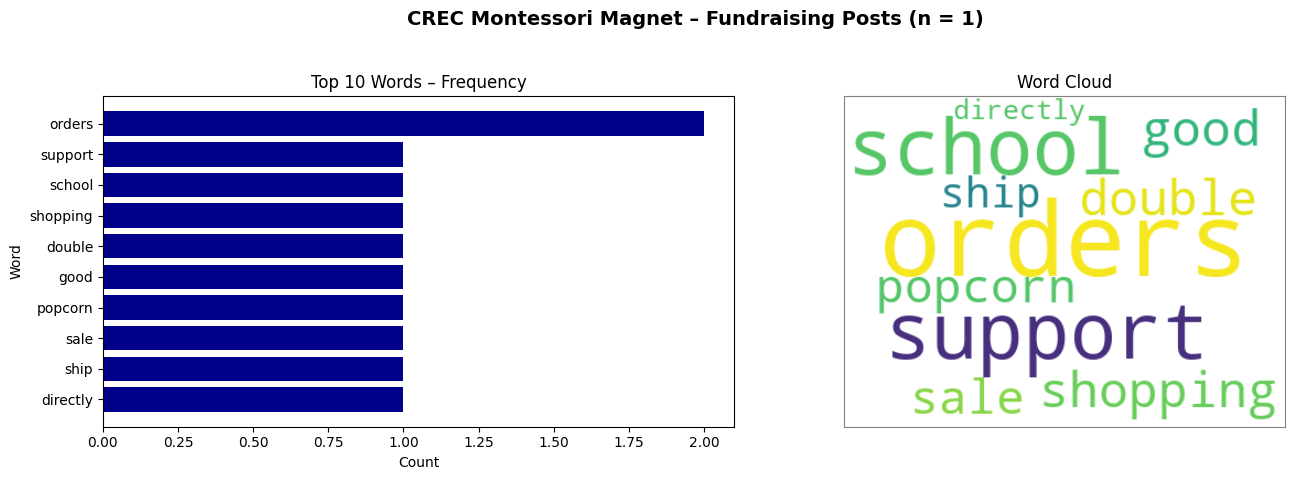

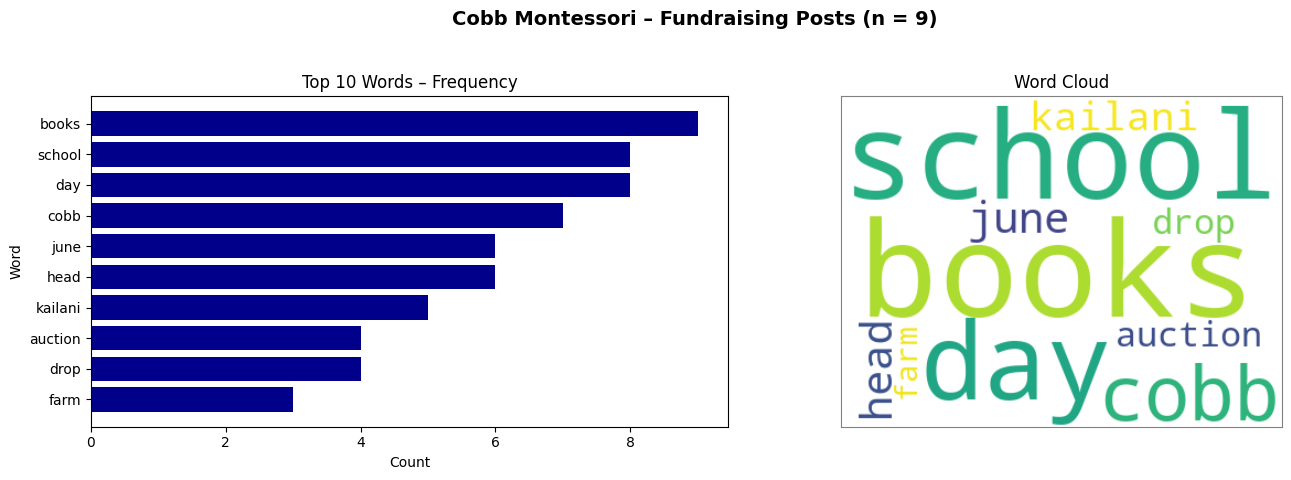

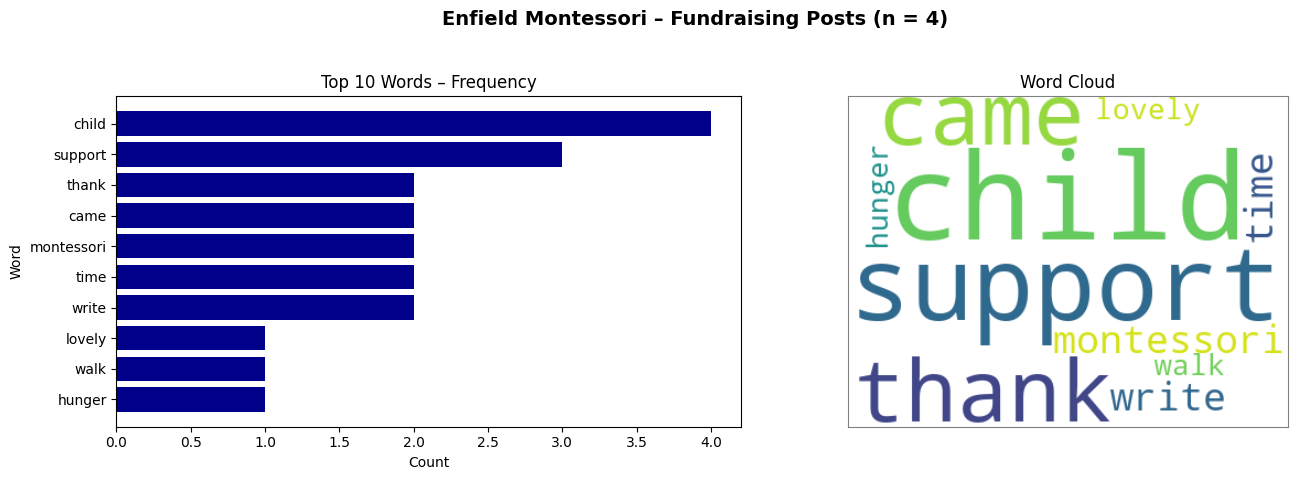

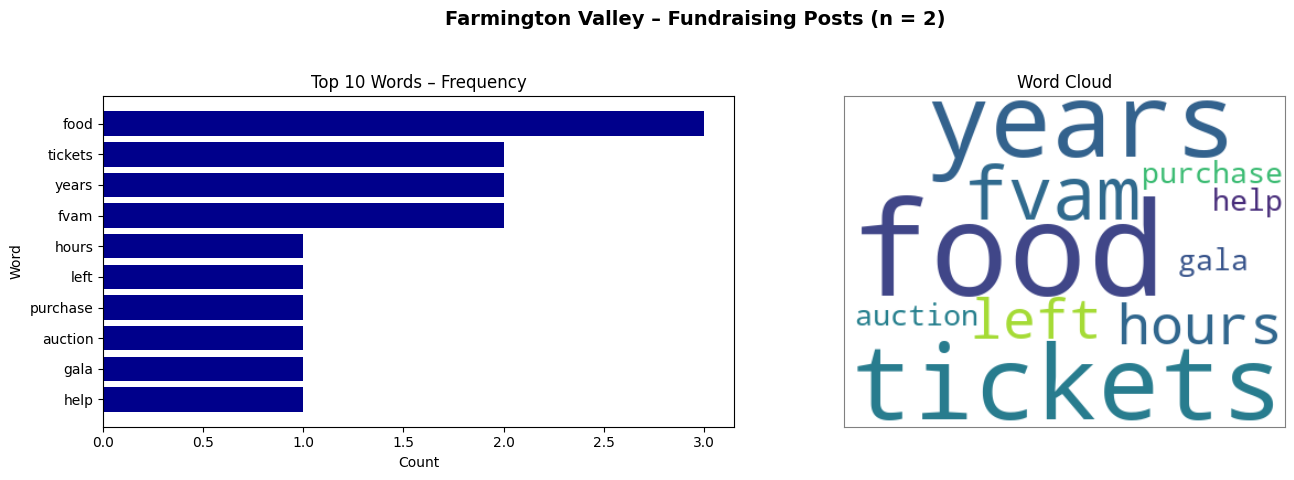

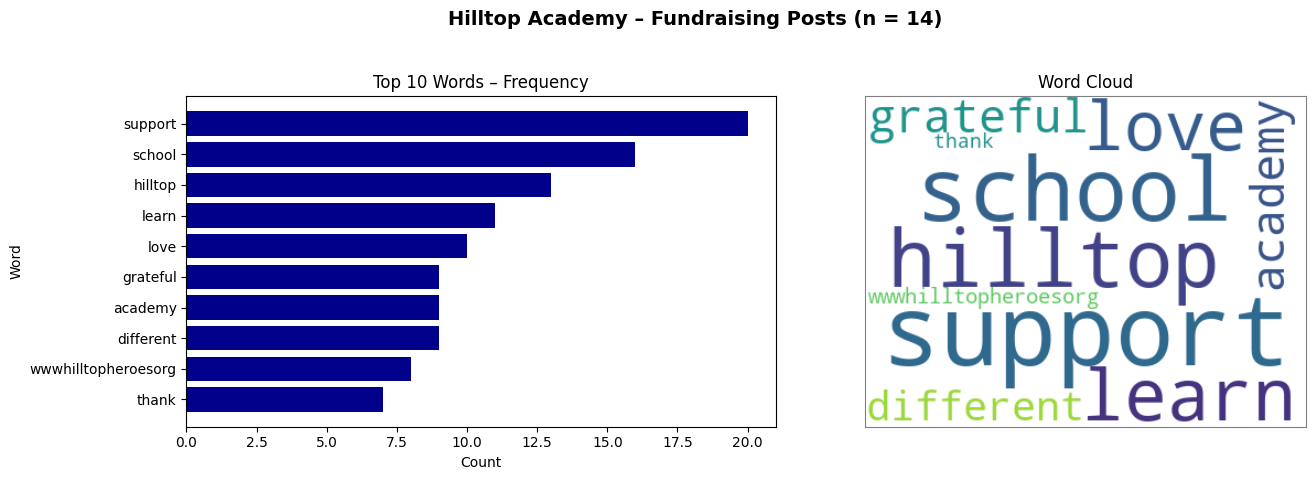

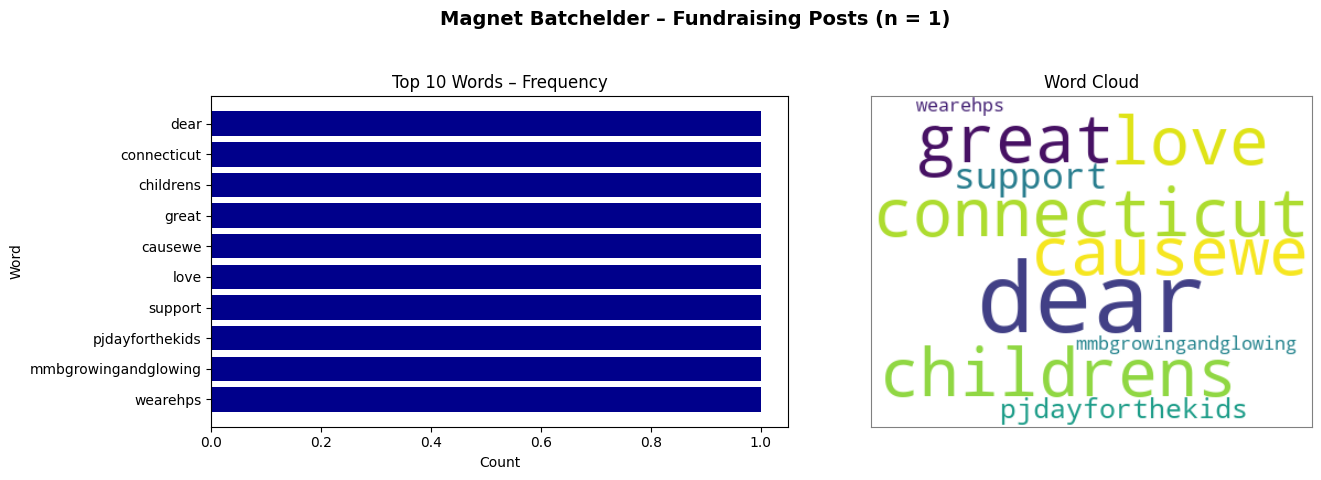

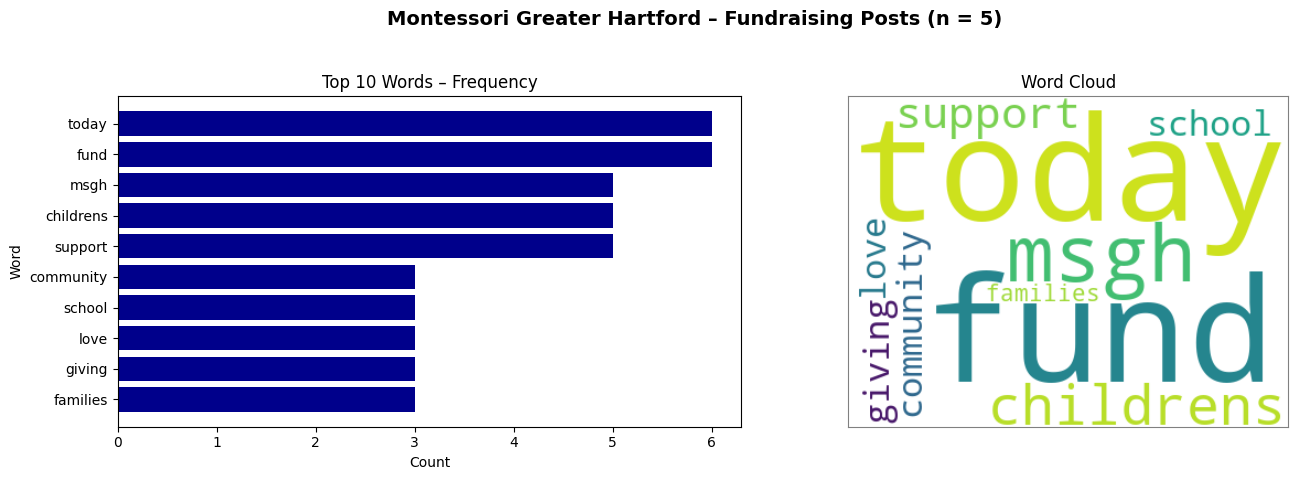

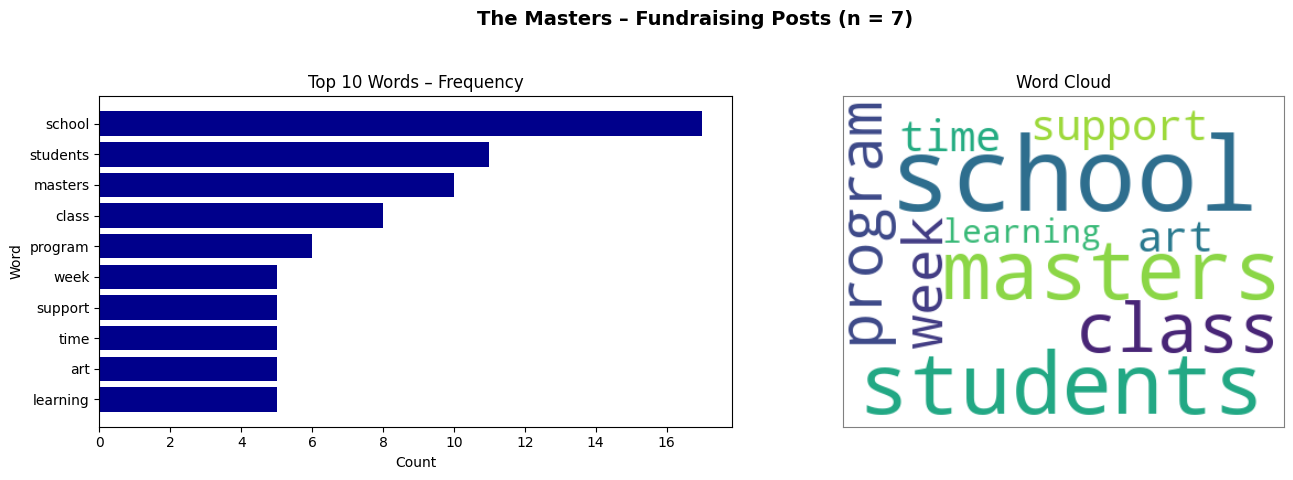

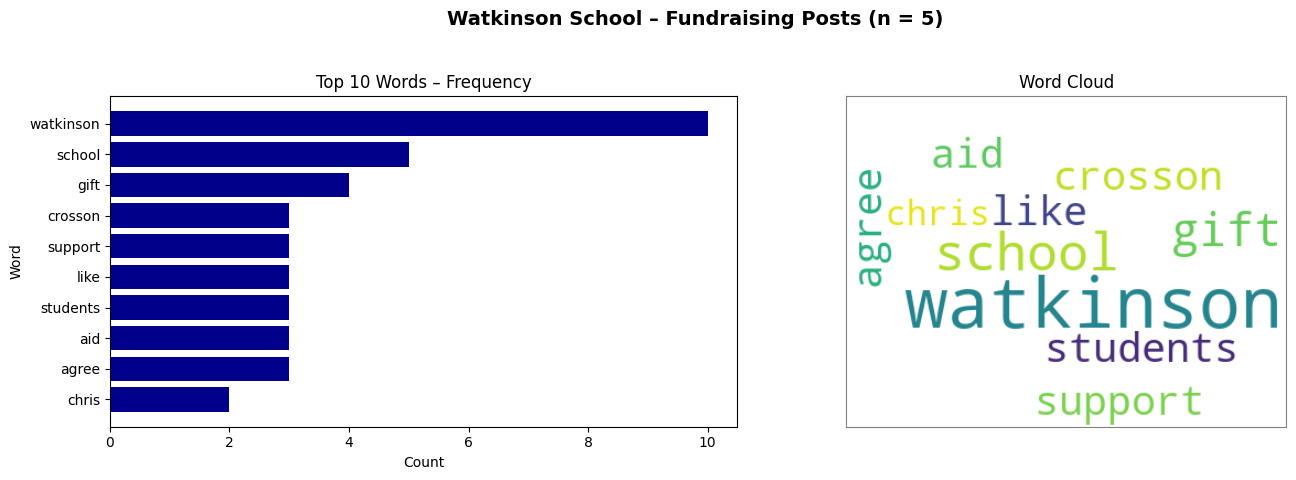

In [73]:
# Visualize: Bar chart + word cloud per school
from wordcloud import WordCloud

for school, word_dict in top_words_fundraising.items():
    words = list(word_dict.keys())
    freqs = list(word_dict.values())

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    num_posts = len(fundraising_df[fundraising_df['school_name'] == school])
    fig.suptitle(f"{school.replace('_', ' ')} – Fundraising Posts (n = {num_posts})", fontsize=14, weight='bold')


    # Bar chart
    axs[0].barh(words[::-1], freqs[::-1], color='darkblue')
    axs[0].set_title("Top 10 Words – Frequency")
    axs[0].set_xlabel("Count")
    axs[0].set_ylabel("Word")

    # Word cloud
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate_from_frequencies(word_dict)
    axs[1].imshow(wordcloud, interpolation='bilinear')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].spines['top'].set_visible(True)
    axs[1].spines['bottom'].set_visible(True)
    axs[1].spines['left'].set_visible(True)
    axs[1].spines['right'].set_visible(True)
    axs[1].spines['top'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['right'].set_color('gray')
    axs[1].set_title("Word Cloud")


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [74]:
# Filter the fundraising posts
fundraising_df = df[df['is_fundraising_campaign'] == True].copy()

# Drop rows with missing post_text
fundraising_df = fundraising_df.dropna(subset=['post_text'])

# Randomly sample 5 posts
sampled_posts = fundraising_df.sample(n=5, random_state=42)

# Print full post text
for idx, row in sampled_posts.iterrows():
    print(f"📌 {row['school_name']}")
    print(row['post_text'])
    print("-" * 80)


📌 Magnet_Batchelder
Dear Connecticut Children's ,   
This is why we PJ… for a great causeWe love and support each and every one of you 
#PJDAYFORTHEKIDS #mmbgrowingandglowing #wearehps
Your friends, 
Montessori at Batchelder
--------------------------------------------------------------------------------
📌 Watkinson_School
We invite prospective parents to join Head of School Teri Schrader on Wednesday, Apr. 16 at 8am, for coffee and conversation. As the school search often involves questions about affordability, she will be joined by Director of Admission John Crosson and Director of Financial Aid Maricele Riemann who will speak about Watkinson’s financial aid practices.
Perhaps you are considering a private school for your student because you know and believe that there are better, more meaningful educational possibilities for them. During our recent New England Association of Schools and Colleges accreditation process, data showed:
• 97.4% of our students agree that their teachers tr

## 💰 Theme Analysis – Fundraising Campaigns

This section explores how each school communicates around **fundraising efforts**. We filtered all Facebook posts tagged with `is_fundraising_campaign == True` and extracted the **top 10 most frequently used words** per school. This reveals each institution's tone, priorities, and fundraising style.

---

### 📊 Top Words per School

| School                    | Top Fundraising Words |
|---------------------------|------------------------|
| **CREC Montessori Magnet** | orders, support, school, shopping, double, good, popcorn, sale, ship, directly |
| **Cobb Montessori**        | books, school, day, cobb, june, head, kailani, auction, drop, farm |
| **Enfield Montessori**     | school, increasing, strong, sense, students, student, things, prioritized, montessori, purposefulness |
| **Farmington Valley**      | food, tickets, years, fvam, hours, left, purchase, auction, gala, help |
| **Hilltop Academy**        | support, school, hilltop, learn, love, grateful, academy, different, wwwhilltopheroesorg, thank |
| **Magnet Batchelder**      | dear, connecticut, childrens, great, causewe, love, support, pjdayforthekids, mmbgrowingandglowing, wearehps |
| **Montessori Greater Hartford** | today, fund, msgh, childrens, support, community, school, love, giving, families |
| **The Masters**            | school, students, masters, class, program, week, support, time, art, learning |
| **Watkinson School**       | watkinson, school, gift, crosson, support, like, students, aid, agree, chris |

---

### 🧠 Interpretation & Highlights

- **CREC Montessori Magnet** emphasizes direct product-based fundraising (e.g., *popcorn*, *orders*, *ship*), with clear calls to action.
- **Cobb Montessori** blends personal references (*kailani*) with seasonal fundraising events like *auction* and *farm day*.
- **Enfield Montessori** focuses more on mission-driven framing, using values-based words like *purposefulness*, *prioritized*, and *sense*.
- **Farmington Valley** highlights logistical urgency (*tickets*, *left*, *purchase*), hinting at time-sensitive events like galas or auctions.
- **Hilltop Academy** communicates gratitude and community spirit through words like *grateful*, *love*, and *support*.
- **Magnet Batchelder** ties fundraising to larger causes (*pjdayforthekids*), reinforcing identity through branded hashtags.
- **Montessori Greater Hartford** emphasizes community and early childhood values (*families*, *giving*, *childrens*, *msgh*).
- **The Masters** keeps a program-focused tone (*art*, *class*, *learning*), suggesting more curriculum-linked fundraising.
- **Watkinson School** frames fundraising in terms of legacy and institutional support (*gift*, *crosson*, *aid*).

---

### 📌 Why It Matters

Understanding fundraising language helps identify:
- Emotional appeals vs. transactional language
- Campaign urgency vs. long-term development tone
- Whether schools prioritize brand, mission, or event when asking for support

This insight can guide Ahsas School in shaping **fundraising communications** that are compelling, culturally aligned, and distinct from competitors.